In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
from glob import glob
import random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
import time
import gc
import traceback
from PIL import Image
from transformers import AutoModel, ViTForImageClassification, ViTConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score





## Chest X-ray Dataset



 Dataset Information:
Total number of images: 4200
Class distribution:
label
Normal          3500
Tuberculosis     700
Name: count, dtype: int64


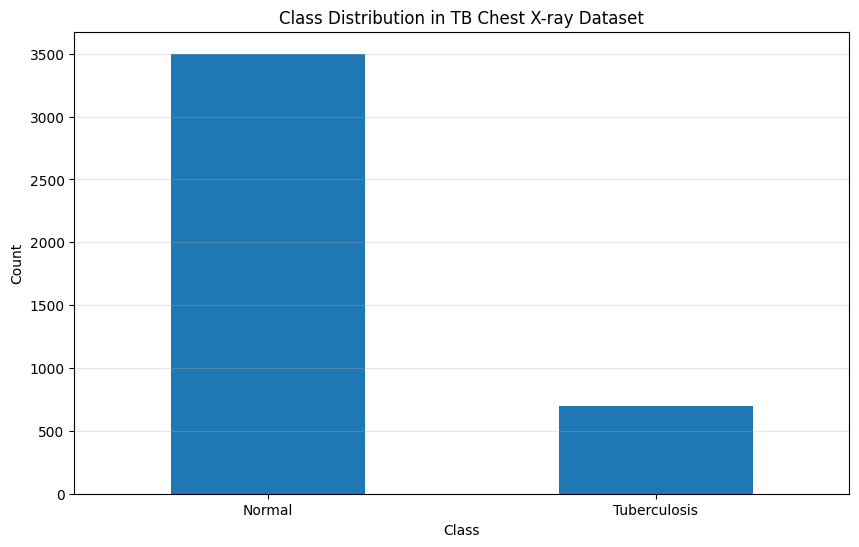

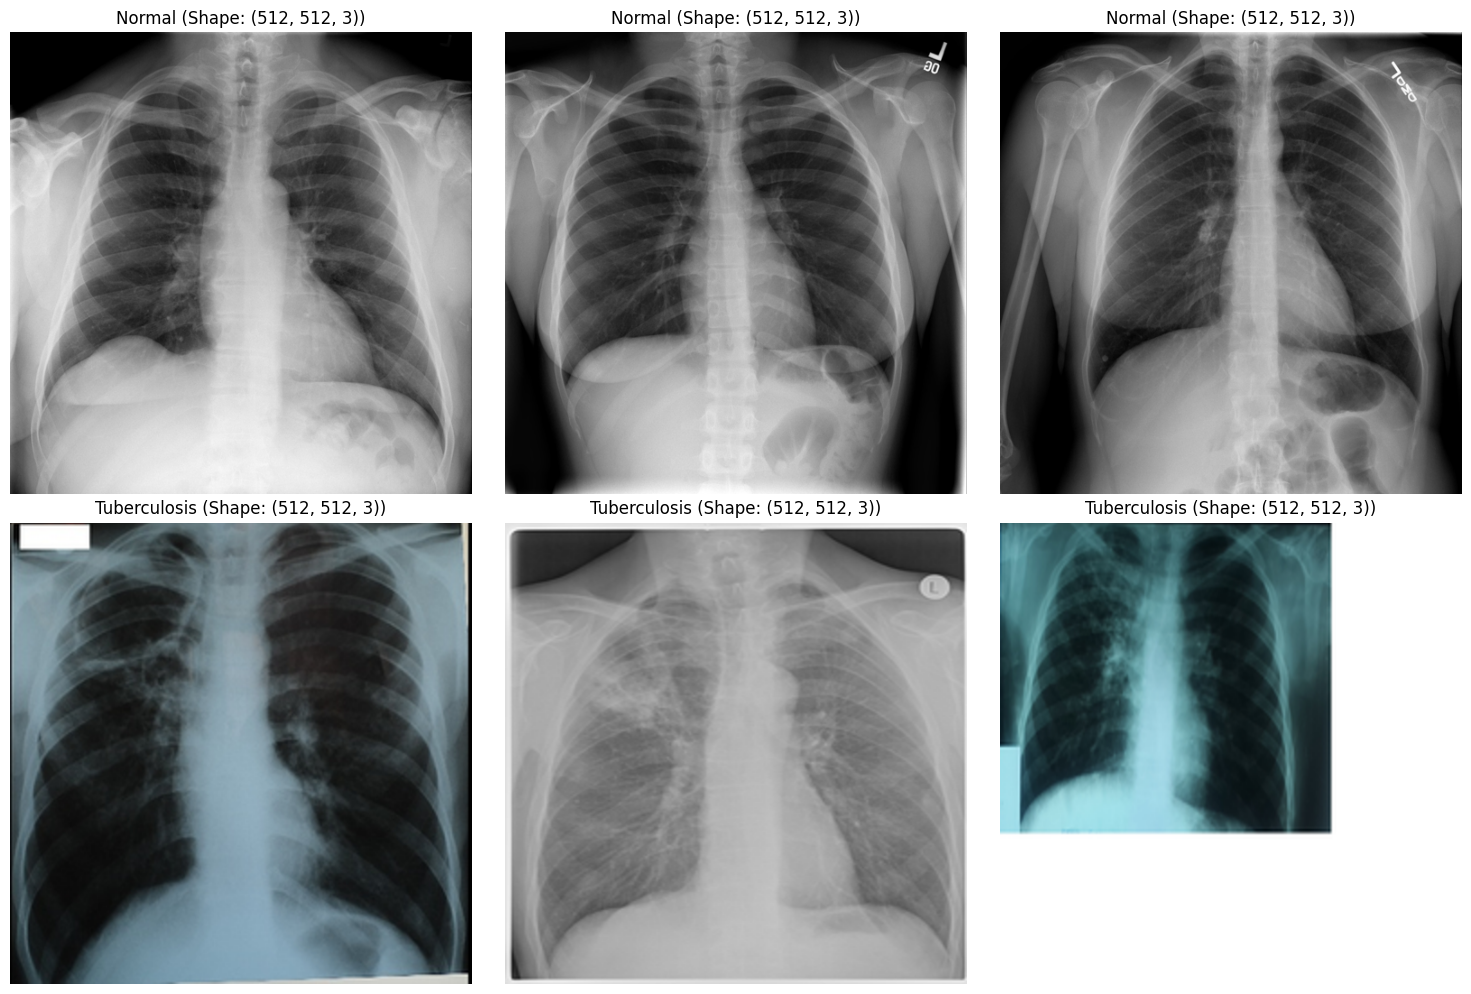


 Train/Test Split:
Training set: 3360 images
Testing set: 840 images

Class distribution in training set:
label
Normal          2800
Tuberculosis     560
Name: count, dtype: int64

Class distribution in testing set:
label
Normal          700
Tuberculosis    140
Name: count, dtype: int64
Analyzing 100 sample images...

 Image Statistics:
Height (pixels): Mean=512.0, Std=0.0
Width (pixels): Mean=512.0, Std=0.0
Aspect Ratio: Mean=1.000

 Analyzing class features...


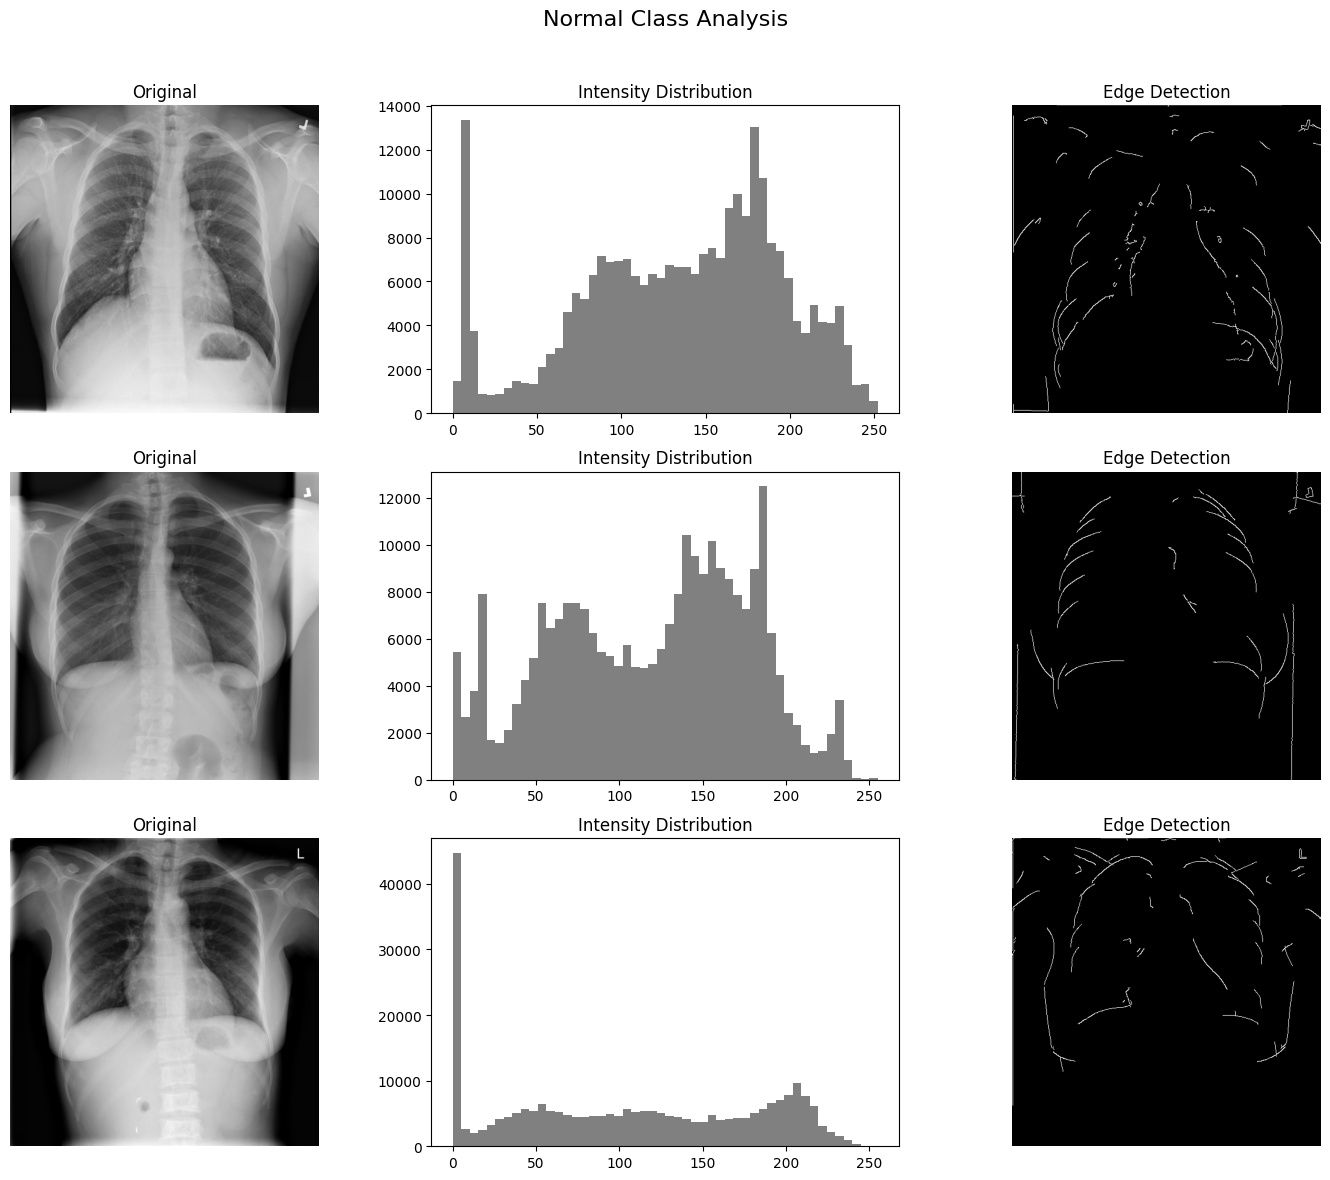

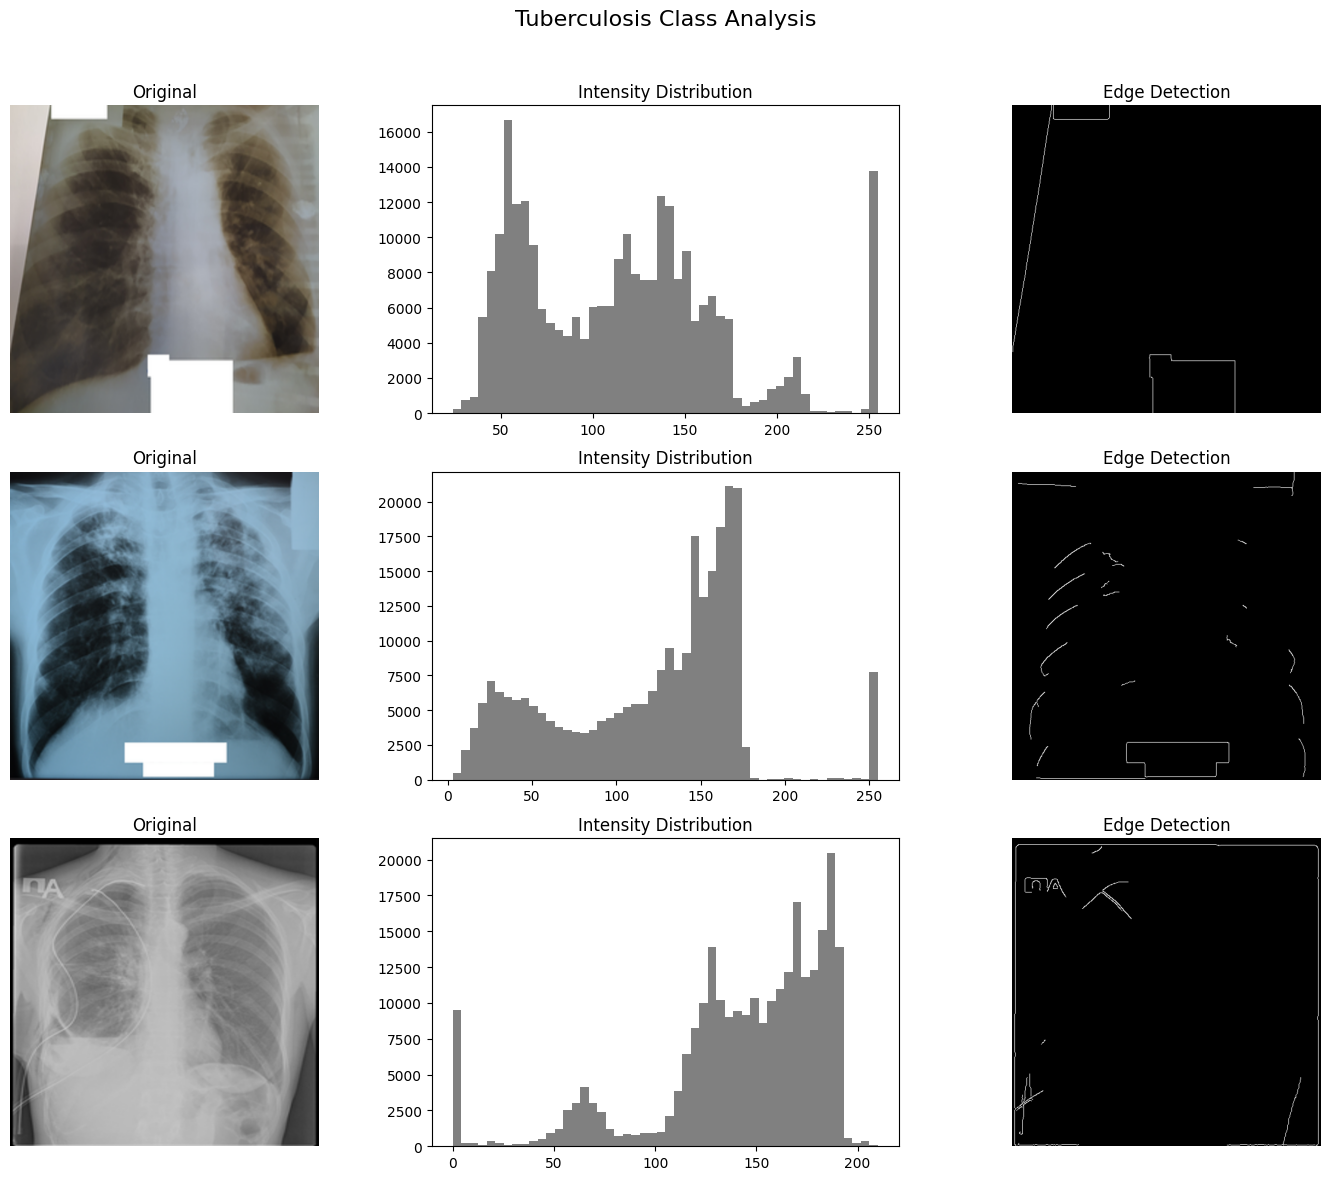

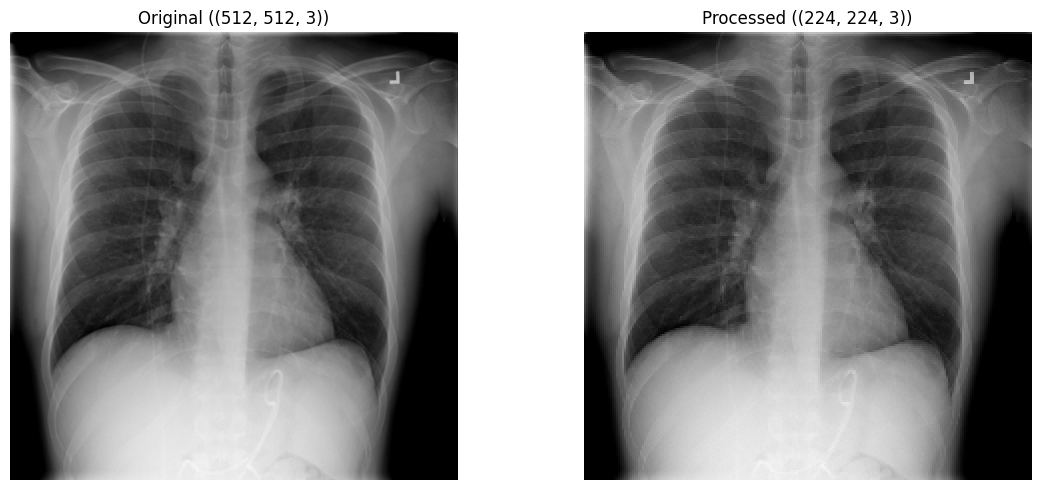

In [ ]:

base_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
normal_path = os.path.join(base_path, 'Normal')
tb_path = os.path.join(base_path, 'Tuberculosis')

def create_dataset_df(normal_dir, tb_dir):
    normal_files = glob(os.path.join(normal_dir, '*.png'))
    tb_files = glob(os.path.join(tb_dir, '*.png'))
    
    files = normal_files + tb_files
    labels = ['Normal'] * len(normal_files) + ['Tuberculosis'] * len(tb_files)
    
    return pd.DataFrame({
        'image_path': files,
        'label': labels
    })


if os.path.exists(normal_path) and os.path.exists(tb_path):
    df = create_dataset_df(normal_path, tb_path)
    
    print("\n Dataset Information:")
    print(f"Total number of images: {len(df)}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    plt.figure(figsize=(10, 6))
    df['label'].value_counts().plot(kind='bar')
    plt.title('Class Distribution in TB Chest X-ray Dataset')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    plt.figure(figsize=(15, 10))
    for i, label in enumerate(['Normal', 'Tuberculosis']):
        sample_paths = df[df['label'] == label]['image_path'].sample(min(3, len(df[df['label'] == label]))).tolist()
        
        for j, path in enumerate(sample_paths):
            plt.subplot(2, 3, i*3 + j + 1)
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"{label} (Shape: {img.shape})")
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    
   
    train_df, test_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42,
        stratify=df['label']  
    )
    
    print("\n Train/Test Split:")
    print(f"Training set: {len(train_df)} images")
    print(f"Testing set: {len(test_df)} images")
    print("\nClass distribution in training set:")
    print(train_df['label'].value_counts())
    print("\nClass distribution in testing set:")
    print(test_df['label'].value_counts())
    
    # Image statistics analysis
    def analyze_image_statistics(dataframe):
        heights = []
        widths = []
        aspects = []
        
        sample_size = min(100, len(dataframe))
        sample_df = dataframe.sample(sample_size)
        print(f"Analyzing {sample_size} sample images...")
        for path in sample_df['image_path']:
            try:
                img = cv2.imread(path)
                if img is not None:
                    h, w = img.shape[:2]
                    heights.append(h)
                    widths.append(w)
                    aspects.append(w/h)
            except Exception as e:
                print(f"Error processing image {path}: {e}")
        
        return {
            'height': {'mean': np.mean(heights), 'std': np.std(heights)},
            'width': {'mean': np.mean(widths), 'std': np.std(widths)},
            'aspect_ratio': {'mean': np.mean(aspects), 'std': np.std(aspects)}
        }
    
    # Analyze image statistics
    stats = analyze_image_statistics(df)
    print("\n Image Statistics:")
    print(f"Height (pixels): Mean={stats['height']['mean']:.1f}, Std={stats['height']['std']:.1f}")
    print(f"Width (pixels): Mean={stats['width']['mean']:.1f}, Std={stats['width']['std']:.1f}")
    print(f"Aspect Ratio: Mean={stats['aspect_ratio']['mean']:.3f}")
    
    # Class-specific image analysis
    def analyze_class_features(label, num_samples=3):
        class_df = df[df['label'] == label]
        sample_paths = class_df['image_path'].sample(num_samples).tolist()
        plt.figure(figsize=(15, 12))
        for i, path in enumerate(sample_paths):
            plt.subplot(num_samples, 3, i*3 + 1)
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Original")
            plt.axis('off')
            plt.subplot(num_samples, 3, i*3 + 2)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            plt.hist(gray.ravel(), bins=50, color='gray')
            plt.title(f"Intensity Distribution")
            plt.subplot(num_samples, 3, i*3 + 3)
            edges = cv2.Canny(gray, 100, 200)
            plt.imshow(edges, cmap='gray')
            plt.title(f"Edge Detection")
            plt.axis('off')
            
        plt.suptitle(f"{label} Class Analysis", fontsize=16, y=0.98)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()
    
    print("\n Analyzing class features...")
    analyze_class_features('Normal')
    analyze_class_features('Tuberculosis')
    def preprocess_for_model(image_path, target_size=(224, 224)):
        """Preprocess an image for model training"""
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img = img / 255.0
        return img
    
    
    sample_img_path = df['image_path'].iloc[0]
    original_img = cv2.imread(sample_img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    processed_img = preprocess_for_model(sample_img_path)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original ({original_img.shape})")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(processed_img)
    plt.title(f"Processed ({processed_img.shape})")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    
  

## Densenet

Using device: cuda:0
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB
Creating dataset dataframe...

Dataset Information:
Total number of images: 4200
Class distribution:
label
Normal          3500
Tuberculosis     700
Name: count, dtype: int64

Train/Test Split:
Training set: 3360 images
Testing set: 840 images
Loading pretrained chest X-ray segmentation model...


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Successfully loaded pretrained segmentation model
Pre-processing and caching segmented images...


100%|██████████| 3360/3360 [00:00<00:00, 18172.59it/s]


Processed 3360 images. Cached at /kaggle/working/segmented_cache/
Pre-processing and caching segmented images...


100%|██████████| 840/840 [00:00<00:00, 17967.80it/s]


Processed 840 images. Cached at /kaggle/working/segmented_cache/
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB

Creating data loaders with pre-segmented lung images...

===== Training DenseNet201 with Segmented Lungs =====
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB


Epoch 1/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 0.07 GB
GPU Memory Reserved: 0.09 GB


Epoch 1/15:   3%|▎         | 13/420 [00:01<00:27, 14.93it/s]

Batch 10, Loss: 0.8924, Running Acc: 70.00%


Epoch 1/15:   5%|▌         | 23/420 [00:01<00:23, 16.61it/s]

Batch 20, Loss: 0.2677, Running Acc: 78.12%


Epoch 1/15:   8%|▊         | 33/420 [00:02<00:23, 16.79it/s]

Batch 30, Loss: 0.0804, Running Acc: 80.00%


Epoch 1/15:  10%|█         | 43/420 [00:02<00:22, 16.83it/s]

Batch 40, Loss: 0.3484, Running Acc: 80.94%


Epoch 1/15:  13%|█▎        | 53/420 [00:03<00:21, 16.71it/s]

Batch 50, Loss: 0.0691, Running Acc: 82.25%


Epoch 1/15:  15%|█▌        | 63/420 [00:04<00:21, 16.82it/s]

Batch 60, Loss: 0.4040, Running Acc: 82.50%


Epoch 1/15:  17%|█▋        | 73/420 [00:04<00:20, 16.91it/s]

Batch 70, Loss: 0.5951, Running Acc: 83.39%


Epoch 1/15:  20%|█▉        | 83/420 [00:05<00:20, 16.76it/s]

Batch 80, Loss: 0.4768, Running Acc: 83.44%


Epoch 1/15:  22%|██▏       | 93/420 [00:05<00:19, 16.85it/s]

Batch 90, Loss: 0.1273, Running Acc: 83.89%


Epoch 1/15:  25%|██▍       | 103/420 [00:06<00:18, 16.74it/s]

Batch 100, Loss: 0.3854, Running Acc: 83.12%


Epoch 1/15:  27%|██▋       | 113/420 [00:07<00:18, 16.69it/s]

Batch 110, Loss: 0.5269, Running Acc: 82.61%


Epoch 1/15:  29%|██▉       | 123/420 [00:07<00:18, 15.64it/s]

Batch 120, Loss: 0.5051, Running Acc: 82.50%


Epoch 1/15:  32%|███▏      | 133/420 [00:08<00:18, 15.42it/s]

Batch 130, Loss: 0.0310, Running Acc: 83.17%


Epoch 1/15:  34%|███▍      | 143/420 [00:09<00:17, 16.08it/s]

Batch 140, Loss: 0.2597, Running Acc: 83.30%


Epoch 1/15:  36%|███▋      | 153/420 [00:09<00:16, 16.51it/s]

Batch 150, Loss: 0.1225, Running Acc: 83.58%


Epoch 1/15:  39%|███▉      | 163/420 [00:10<00:15, 16.72it/s]

Batch 160, Loss: 1.0218, Running Acc: 83.44%


Epoch 1/15:  41%|████      | 173/420 [00:10<00:14, 16.67it/s]

Batch 170, Loss: 0.1904, Running Acc: 83.24%


Epoch 1/15:  44%|████▎     | 183/420 [00:11<00:14, 16.72it/s]

Batch 180, Loss: 0.4231, Running Acc: 83.82%


Epoch 1/15:  46%|████▌     | 193/420 [00:12<00:13, 16.67it/s]

Batch 190, Loss: 0.3851, Running Acc: 83.68%


Epoch 1/15:  48%|████▊     | 203/420 [00:12<00:12, 16.94it/s]

Batch 200, Loss: 0.2331, Running Acc: 83.94%


Epoch 1/15:  51%|█████     | 213/420 [00:13<00:12, 16.92it/s]

Batch 210, Loss: 0.4492, Running Acc: 84.35%


Epoch 1/15:  53%|█████▎    | 223/420 [00:13<00:11, 16.91it/s]

Batch 220, Loss: 0.2434, Running Acc: 84.15%


Epoch 1/15:  55%|█████▌    | 233/420 [00:14<00:11, 16.83it/s]

Batch 230, Loss: 0.0854, Running Acc: 84.08%


Epoch 1/15:  58%|█████▊    | 243/420 [00:14<00:10, 16.75it/s]

Batch 240, Loss: 0.4350, Running Acc: 84.27%


Epoch 1/15:  60%|██████    | 253/420 [00:15<00:09, 16.81it/s]

Batch 250, Loss: 0.2392, Running Acc: 84.20%


Epoch 1/15:  63%|██████▎   | 263/420 [00:16<00:09, 16.64it/s]

Batch 260, Loss: 0.5025, Running Acc: 84.28%


Epoch 1/15:  65%|██████▌   | 273/420 [00:16<00:08, 16.95it/s]

Batch 270, Loss: 0.1340, Running Acc: 84.49%


Epoch 1/15:  67%|██████▋   | 283/420 [00:17<00:08, 16.83it/s]

Batch 280, Loss: 0.1426, Running Acc: 84.51%


Epoch 1/15:  70%|██████▉   | 293/420 [00:17<00:07, 16.67it/s]

Batch 290, Loss: 0.2211, Running Acc: 84.74%


Epoch 1/15:  72%|███████▏  | 303/420 [00:18<00:07, 16.59it/s]

Batch 300, Loss: 0.5090, Running Acc: 84.54%


Epoch 1/15:  75%|███████▍  | 313/420 [00:19<00:06, 16.90it/s]

Batch 310, Loss: 0.5600, Running Acc: 84.27%


Epoch 1/15:  77%|███████▋  | 323/420 [00:19<00:05, 16.78it/s]

Batch 320, Loss: 0.7742, Running Acc: 84.22%


Epoch 1/15:  79%|███████▉  | 333/420 [00:20<00:05, 16.58it/s]

Batch 330, Loss: 0.5772, Running Acc: 84.17%


Epoch 1/15:  82%|████████▏ | 343/420 [00:20<00:04, 16.57it/s]

Batch 340, Loss: 0.0612, Running Acc: 84.23%


Epoch 1/15:  84%|████████▍ | 353/420 [00:21<00:04, 16.69it/s]

Batch 350, Loss: 0.2153, Running Acc: 84.29%


Epoch 1/15:  86%|████████▋ | 363/420 [00:22<00:03, 16.83it/s]

Batch 360, Loss: 0.5191, Running Acc: 84.41%


Epoch 1/15:  89%|████████▉ | 373/420 [00:22<00:02, 16.73it/s]

Batch 370, Loss: 0.1448, Running Acc: 84.70%


Epoch 1/15:  91%|█████████ | 383/420 [00:23<00:02, 16.80it/s]

Batch 380, Loss: 0.3078, Running Acc: 84.67%


Epoch 1/15:  94%|█████████▎| 393/420 [00:23<00:01, 17.00it/s]

Batch 390, Loss: 0.3196, Running Acc: 84.87%


Epoch 1/15:  96%|█████████▌| 403/420 [00:24<00:00, 17.03it/s]

Batch 400, Loss: 0.5455, Running Acc: 84.91%


Epoch 1/15:  98%|█████████▊| 413/420 [00:25<00:00, 16.90it/s]

Batch 410, Loss: 0.1943, Running Acc: 85.15%


Epoch 1/15: 100%|██████████| 420/420 [00:25<00:00, 16.44it/s]


Batch 420, Loss: 0.2184, Running Acc: 85.00%
Epoch 1/15, Loss: 0.3790, Accuracy: 85.00%, Time: 25.6s
Saved best model checkpoint


Epoch 2/15:   0%|          | 2/420 [00:00<00:25, 16.70it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 2/15:   3%|▎         | 12/420 [00:00<00:24, 16.76it/s]

Batch 10, Loss: 0.0508, Running Acc: 92.50%


Epoch 2/15:   5%|▌         | 22/420 [00:01<00:23, 16.88it/s]

Batch 20, Loss: 0.3788, Running Acc: 91.25%


Epoch 2/15:   8%|▊         | 32/420 [00:01<00:23, 16.72it/s]

Batch 30, Loss: 0.3313, Running Acc: 90.42%


Epoch 2/15:  10%|█         | 42/420 [00:02<00:22, 16.74it/s]

Batch 40, Loss: 0.2944, Running Acc: 87.81%


Epoch 2/15:  12%|█▏        | 52/420 [00:03<00:21, 16.80it/s]

Batch 50, Loss: 0.1635, Running Acc: 86.00%


Epoch 2/15:  15%|█▍        | 62/420 [00:03<00:21, 16.82it/s]

Batch 60, Loss: 0.2658, Running Acc: 86.04%


Epoch 2/15:  17%|█▋        | 72/420 [00:04<00:20, 16.70it/s]

Batch 70, Loss: 0.2096, Running Acc: 85.36%


Epoch 2/15:  20%|█▉        | 82/420 [00:04<00:20, 16.85it/s]

Batch 80, Loss: 1.1576, Running Acc: 85.94%


Epoch 2/15:  22%|██▏       | 92/420 [00:05<00:19, 16.93it/s]

Batch 90, Loss: 0.3579, Running Acc: 86.39%


Epoch 2/15:  24%|██▍       | 102/420 [00:06<00:18, 16.80it/s]

Batch 100, Loss: 0.0308, Running Acc: 86.38%


Epoch 2/15:  27%|██▋       | 112/420 [00:06<00:18, 16.97it/s]

Batch 110, Loss: 0.4790, Running Acc: 86.02%


Epoch 2/15:  29%|██▉       | 122/420 [00:07<00:17, 16.81it/s]

Batch 120, Loss: 0.2532, Running Acc: 86.46%


Epoch 2/15:  31%|███▏      | 132/420 [00:07<00:16, 17.02it/s]

Batch 130, Loss: 0.1170, Running Acc: 86.44%


Epoch 2/15:  34%|███▍      | 142/420 [00:08<00:16, 16.89it/s]

Batch 140, Loss: 1.0850, Running Acc: 85.98%


Epoch 2/15:  36%|███▌      | 152/420 [00:09<00:16, 16.62it/s]

Batch 150, Loss: 0.1072, Running Acc: 86.33%


Epoch 2/15:  39%|███▊      | 162/420 [00:09<00:15, 16.72it/s]

Batch 160, Loss: 0.2012, Running Acc: 86.64%


Epoch 2/15:  41%|████      | 172/420 [00:10<00:14, 16.72it/s]

Batch 170, Loss: 0.2003, Running Acc: 86.62%


Epoch 2/15:  43%|████▎     | 182/420 [00:10<00:14, 16.90it/s]

Batch 180, Loss: 0.8565, Running Acc: 86.60%


Epoch 2/15:  46%|████▌     | 192/420 [00:11<00:13, 16.78it/s]

Batch 190, Loss: 0.3874, Running Acc: 86.71%


Epoch 2/15:  48%|████▊     | 202/420 [00:12<00:13, 15.61it/s]

Batch 200, Loss: 0.0822, Running Acc: 86.94%


Epoch 2/15:  50%|█████     | 212/420 [00:12<00:12, 16.64it/s]

Batch 210, Loss: 0.1669, Running Acc: 86.73%


Epoch 2/15:  53%|█████▎    | 222/420 [00:13<00:12, 15.35it/s]

Batch 220, Loss: 0.3877, Running Acc: 86.76%


Epoch 2/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.41it/s]

Batch 230, Loss: 0.2276, Running Acc: 86.47%


Epoch 2/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.50it/s]

Batch 240, Loss: 0.9668, Running Acc: 86.35%


Epoch 2/15:  60%|██████    | 252/420 [00:15<00:10, 16.73it/s]

Batch 250, Loss: 0.0539, Running Acc: 86.50%


Epoch 2/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.84it/s]

Batch 260, Loss: 0.1723, Running Acc: 86.39%


Epoch 2/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.88it/s]

Batch 270, Loss: 0.6140, Running Acc: 86.30%


Epoch 2/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.78it/s]

Batch 280, Loss: 0.6381, Running Acc: 86.38%


Epoch 2/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.75it/s]

Batch 290, Loss: 0.5524, Running Acc: 86.16%


Epoch 2/15:  72%|███████▏  | 302/420 [00:18<00:07, 16.71it/s]

Batch 300, Loss: 0.0950, Running Acc: 86.04%


Epoch 2/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.85it/s]

Batch 310, Loss: 1.3895, Running Acc: 86.09%


Epoch 2/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.84it/s]

Batch 320, Loss: 0.4926, Running Acc: 85.86%


Epoch 2/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.97it/s]

Batch 330, Loss: 0.6816, Running Acc: 85.91%


Epoch 2/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.97it/s]

Batch 340, Loss: 0.6522, Running Acc: 85.88%


Epoch 2/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.94it/s]

Batch 350, Loss: 0.3934, Running Acc: 85.68%


Epoch 2/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.99it/s]

Batch 360, Loss: 0.0488, Running Acc: 85.80%


Epoch 2/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.23it/s]

Batch 370, Loss: 0.1534, Running Acc: 85.88%


Epoch 2/15:  91%|█████████ | 382/420 [00:22<00:02, 16.64it/s]

Batch 380, Loss: 0.2812, Running Acc: 85.72%


Epoch 2/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.78it/s]

Batch 390, Loss: 0.1847, Running Acc: 85.93%


Epoch 2/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.70it/s]

Batch 400, Loss: 0.3134, Running Acc: 86.12%


Epoch 2/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.85it/s]

Batch 410, Loss: 1.4464, Running Acc: 86.19%


Epoch 2/15: 100%|██████████| 420/420 [00:25<00:00, 16.69it/s]


Batch 420, Loss: 0.4274, Running Acc: 86.25%
Epoch 2/15, Loss: 0.3558, Accuracy: 86.25%, Time: 25.2s
Saved best model checkpoint


Epoch 3/15:   0%|          | 2/420 [00:00<00:25, 16.47it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 3/15:   3%|▎         | 12/420 [00:00<00:25, 16.31it/s]

Batch 10, Loss: 0.1437, Running Acc: 82.50%


Epoch 3/15:   5%|▌         | 22/420 [00:01<00:23, 16.94it/s]

Batch 20, Loss: 0.0458, Running Acc: 88.75%


Epoch 3/15:   8%|▊         | 32/420 [00:01<00:23, 16.85it/s]

Batch 30, Loss: 0.0793, Running Acc: 89.17%


Epoch 3/15:  10%|█         | 42/420 [00:02<00:22, 16.89it/s]

Batch 40, Loss: 0.2709, Running Acc: 89.06%


Epoch 3/15:  12%|█▏        | 52/420 [00:03<00:21, 16.91it/s]

Batch 50, Loss: 0.1603, Running Acc: 89.25%


Epoch 3/15:  15%|█▍        | 62/420 [00:03<00:21, 16.89it/s]

Batch 60, Loss: 0.0712, Running Acc: 89.38%


Epoch 3/15:  17%|█▋        | 72/420 [00:04<00:20, 16.92it/s]

Batch 70, Loss: 0.5404, Running Acc: 89.11%


Epoch 3/15:  20%|█▉        | 82/420 [00:04<00:19, 17.07it/s]

Batch 80, Loss: 0.2683, Running Acc: 88.44%


Epoch 3/15:  22%|██▏       | 92/420 [00:05<00:19, 16.96it/s]

Batch 90, Loss: 0.1938, Running Acc: 89.03%


Epoch 3/15:  24%|██▍       | 102/420 [00:06<00:18, 17.05it/s]

Batch 100, Loss: 0.4118, Running Acc: 88.88%


Epoch 3/15:  27%|██▋       | 112/420 [00:06<00:18, 16.54it/s]

Batch 110, Loss: 0.1342, Running Acc: 89.09%


Epoch 3/15:  29%|██▉       | 122/420 [00:07<00:17, 16.83it/s]

Batch 120, Loss: 0.4576, Running Acc: 89.48%


Epoch 3/15:  31%|███▏      | 132/420 [00:07<00:17, 16.75it/s]

Batch 130, Loss: 0.5238, Running Acc: 89.71%


Epoch 3/15:  34%|███▍      | 142/420 [00:08<00:16, 16.69it/s]

Batch 140, Loss: 0.4605, Running Acc: 89.46%


Epoch 3/15:  36%|███▌      | 152/420 [00:09<00:15, 16.89it/s]

Batch 150, Loss: 0.2171, Running Acc: 89.17%


Epoch 3/15:  39%|███▊      | 162/420 [00:09<00:15, 16.79it/s]

Batch 160, Loss: 0.0883, Running Acc: 89.38%


Epoch 3/15:  41%|████      | 172/420 [00:10<00:14, 16.77it/s]

Batch 170, Loss: 0.5477, Running Acc: 89.04%


Epoch 3/15:  43%|████▎     | 182/420 [00:10<00:14, 16.73it/s]

Batch 180, Loss: 0.3477, Running Acc: 88.47%


Epoch 3/15:  46%|████▌     | 192/420 [00:11<00:13, 16.93it/s]

Batch 190, Loss: 0.2050, Running Acc: 88.22%


Epoch 3/15:  48%|████▊     | 202/420 [00:12<00:12, 16.85it/s]

Batch 200, Loss: 0.3407, Running Acc: 87.94%


Epoch 3/15:  50%|█████     | 212/420 [00:12<00:12, 16.77it/s]

Batch 210, Loss: 0.0610, Running Acc: 87.92%


Epoch 3/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.81it/s]

Batch 220, Loss: 0.0366, Running Acc: 87.95%


Epoch 3/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.80it/s]

Batch 230, Loss: 0.2281, Running Acc: 87.28%


Epoch 3/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.92it/s]

Batch 240, Loss: 0.9234, Running Acc: 86.82%


Epoch 3/15:  60%|██████    | 252/420 [00:15<00:09, 17.03it/s]

Batch 250, Loss: 0.8340, Running Acc: 86.65%


Epoch 3/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.83it/s]

Batch 260, Loss: 0.5006, Running Acc: 86.59%


Epoch 3/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.53it/s]

Batch 270, Loss: 0.2604, Running Acc: 86.67%


Epoch 3/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.53it/s]

Batch 280, Loss: 0.0271, Running Acc: 86.79%


Epoch 3/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.71it/s]

Batch 290, Loss: 0.1616, Running Acc: 86.85%


Epoch 3/15:  72%|███████▏  | 302/420 [00:18<00:06, 16.98it/s]

Batch 300, Loss: 0.1334, Running Acc: 86.83%


Epoch 3/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.54it/s]

Batch 310, Loss: 0.3402, Running Acc: 86.81%


Epoch 3/15:  77%|███████▋  | 322/420 [00:19<00:06, 15.27it/s]

Batch 320, Loss: 0.1727, Running Acc: 86.84%


Epoch 3/15:  79%|███████▉  | 332/420 [00:19<00:05, 15.66it/s]

Batch 330, Loss: 0.5619, Running Acc: 86.78%


Epoch 3/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.40it/s]

Batch 340, Loss: 0.0411, Running Acc: 86.80%


Epoch 3/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.91it/s]

Batch 350, Loss: 0.1526, Running Acc: 86.86%


Epoch 3/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.76it/s]

Batch 360, Loss: 0.3400, Running Acc: 86.81%


Epoch 3/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.75it/s]

Batch 370, Loss: 0.0602, Running Acc: 86.82%


Epoch 3/15:  91%|█████████ | 382/420 [00:22<00:02, 16.95it/s]

Batch 380, Loss: 0.4984, Running Acc: 86.84%


Epoch 3/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.82it/s]

Batch 390, Loss: 1.3861, Running Acc: 86.76%


Epoch 3/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.76it/s]

Batch 400, Loss: 0.1318, Running Acc: 86.66%


Epoch 3/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.88it/s]

Batch 410, Loss: 0.4149, Running Acc: 86.62%


Epoch 3/15: 100%|██████████| 420/420 [00:25<00:00, 16.69it/s]


Batch 420, Loss: 0.1795, Running Acc: 86.67%
Epoch 3/15, Loss: 0.3516, Accuracy: 86.67%, Time: 25.2s
Saved best model checkpoint


Epoch 4/15:   0%|          | 2/420 [00:00<00:25, 16.37it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 4/15:   3%|▎         | 12/420 [00:00<00:26, 15.52it/s]

Batch 10, Loss: 0.8448, Running Acc: 85.00%


Epoch 4/15:   5%|▌         | 22/420 [00:01<00:24, 16.48it/s]

Batch 20, Loss: 0.2102, Running Acc: 86.88%


Epoch 4/15:   8%|▊         | 32/420 [00:01<00:23, 16.23it/s]

Batch 30, Loss: 0.4359, Running Acc: 87.08%


Epoch 4/15:  10%|█         | 42/420 [00:02<00:22, 16.87it/s]

Batch 40, Loss: 0.2288, Running Acc: 88.12%


Epoch 4/15:  12%|█▏        | 52/420 [00:03<00:21, 16.98it/s]

Batch 50, Loss: 0.0101, Running Acc: 88.00%


Epoch 4/15:  15%|█▍        | 62/420 [00:03<00:21, 16.80it/s]

Batch 60, Loss: 0.1115, Running Acc: 87.71%


Epoch 4/15:  17%|█▋        | 72/420 [00:04<00:20, 16.96it/s]

Batch 70, Loss: 0.2906, Running Acc: 87.50%


Epoch 4/15:  20%|█▉        | 82/420 [00:04<00:20, 16.51it/s]

Batch 80, Loss: 0.1311, Running Acc: 87.97%


Epoch 4/15:  22%|██▏       | 92/420 [00:05<00:19, 16.64it/s]

Batch 90, Loss: 0.0985, Running Acc: 87.78%


Epoch 4/15:  24%|██▍       | 102/420 [00:06<00:18, 16.84it/s]

Batch 100, Loss: 1.5173, Running Acc: 87.50%


Epoch 4/15:  27%|██▋       | 112/420 [00:06<00:18, 16.87it/s]

Batch 110, Loss: 0.7241, Running Acc: 87.61%


Epoch 4/15:  29%|██▉       | 122/420 [00:07<00:17, 16.95it/s]

Batch 120, Loss: 0.0128, Running Acc: 87.60%


Epoch 4/15:  31%|███▏      | 132/420 [00:07<00:17, 16.79it/s]

Batch 130, Loss: 0.3819, Running Acc: 87.50%


Epoch 4/15:  34%|███▍      | 142/420 [00:08<00:16, 16.84it/s]

Batch 140, Loss: 0.2952, Running Acc: 87.14%


Epoch 4/15:  36%|███▌      | 152/420 [00:09<00:15, 16.81it/s]

Batch 150, Loss: 0.2144, Running Acc: 87.08%


Epoch 4/15:  39%|███▊      | 162/420 [00:09<00:15, 17.00it/s]

Batch 160, Loss: 0.0505, Running Acc: 87.27%


Epoch 4/15:  41%|████      | 172/420 [00:10<00:14, 16.89it/s]

Batch 170, Loss: 0.3565, Running Acc: 87.13%


Epoch 4/15:  43%|████▎     | 182/420 [00:10<00:14, 16.20it/s]

Batch 180, Loss: 0.2236, Running Acc: 86.94%


Epoch 4/15:  46%|████▌     | 192/420 [00:11<00:13, 16.87it/s]

Batch 190, Loss: 0.2604, Running Acc: 86.91%


Epoch 4/15:  48%|████▊     | 202/420 [00:12<00:13, 16.72it/s]

Batch 200, Loss: 0.6044, Running Acc: 86.94%


Epoch 4/15:  50%|█████     | 212/420 [00:12<00:12, 16.70it/s]

Batch 210, Loss: 0.1731, Running Acc: 86.96%


Epoch 4/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.91it/s]

Batch 220, Loss: 0.8224, Running Acc: 86.99%


Epoch 4/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.66it/s]

Batch 230, Loss: 0.1414, Running Acc: 87.17%


Epoch 4/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.78it/s]

Batch 240, Loss: 0.1809, Running Acc: 87.19%


Epoch 4/15:  60%|██████    | 252/420 [00:15<00:09, 16.98it/s]

Batch 250, Loss: 1.1669, Running Acc: 87.00%


Epoch 4/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.69it/s]

Batch 260, Loss: 0.4908, Running Acc: 87.02%


Epoch 4/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.70it/s]

Batch 270, Loss: 0.6230, Running Acc: 87.18%


Epoch 4/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.73it/s]

Batch 280, Loss: 1.0662, Running Acc: 87.28%


Epoch 4/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.81it/s]

Batch 290, Loss: 0.6612, Running Acc: 86.85%


Epoch 4/15:  72%|███████▏  | 302/420 [00:18<00:06, 16.87it/s]

Batch 300, Loss: 0.4940, Running Acc: 87.12%


Epoch 4/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.87it/s]

Batch 310, Loss: 0.4139, Running Acc: 87.30%


Epoch 4/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.81it/s]

Batch 320, Loss: 1.0432, Running Acc: 87.30%


Epoch 4/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.02it/s]

Batch 330, Loss: 0.4431, Running Acc: 87.20%


Epoch 4/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.86it/s]

Batch 340, Loss: 0.7481, Running Acc: 86.99%


Epoch 4/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.63it/s]

Batch 350, Loss: 0.3108, Running Acc: 86.64%


Epoch 4/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.85it/s]

Batch 360, Loss: 0.6771, Running Acc: 86.53%


Epoch 4/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.84it/s]

Batch 370, Loss: 0.1970, Running Acc: 86.52%


Epoch 4/15:  91%|█████████ | 382/420 [00:22<00:02, 16.97it/s]

Batch 380, Loss: 0.2429, Running Acc: 86.28%


Epoch 4/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.94it/s]

Batch 390, Loss: 0.0130, Running Acc: 86.25%


Epoch 4/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.82it/s]

Batch 400, Loss: 0.1793, Running Acc: 86.25%


Epoch 4/15:  98%|█████████▊| 412/420 [00:24<00:00, 15.80it/s]

Batch 410, Loss: 0.1596, Running Acc: 86.28%


Epoch 4/15: 100%|██████████| 420/420 [00:25<00:00, 16.68it/s]


Batch 420, Loss: 0.0653, Running Acc: 86.40%
Epoch 4/15, Loss: 0.3602, Accuracy: 86.40%, Time: 25.2s


Epoch 5/15:   0%|          | 2/420 [00:00<00:28, 14.90it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 5/15:   3%|▎         | 12/420 [00:00<00:24, 16.75it/s]

Batch 10, Loss: 0.3050, Running Acc: 83.75%


Epoch 5/15:   5%|▌         | 22/420 [00:01<00:24, 16.54it/s]

Batch 20, Loss: 0.1844, Running Acc: 87.50%


Epoch 5/15:   8%|▊         | 32/420 [00:01<00:22, 16.89it/s]

Batch 30, Loss: 0.2785, Running Acc: 89.17%


Epoch 5/15:  10%|█         | 42/420 [00:02<00:22, 16.88it/s]

Batch 40, Loss: 0.3049, Running Acc: 90.00%


Epoch 5/15:  12%|█▏        | 52/420 [00:03<00:22, 16.71it/s]

Batch 50, Loss: 1.0639, Running Acc: 89.50%


Epoch 5/15:  15%|█▍        | 62/420 [00:03<00:21, 16.76it/s]

Batch 60, Loss: 0.0571, Running Acc: 89.58%


Epoch 5/15:  17%|█▋        | 72/420 [00:04<00:20, 16.82it/s]

Batch 70, Loss: 0.5427, Running Acc: 88.93%


Epoch 5/15:  20%|█▉        | 82/420 [00:04<00:20, 16.65it/s]

Batch 80, Loss: 1.5986, Running Acc: 88.28%


Epoch 5/15:  22%|██▏       | 92/420 [00:05<00:20, 16.30it/s]

Batch 90, Loss: 0.4699, Running Acc: 87.50%


Epoch 5/15:  24%|██▍       | 102/420 [00:06<00:19, 16.56it/s]

Batch 100, Loss: 0.2872, Running Acc: 87.00%


Epoch 5/15:  27%|██▋       | 112/420 [00:06<00:18, 16.55it/s]

Batch 110, Loss: 0.1833, Running Acc: 87.39%


Epoch 5/15:  29%|██▉       | 122/420 [00:07<00:17, 16.90it/s]

Batch 120, Loss: 0.1876, Running Acc: 86.88%


Epoch 5/15:  31%|███▏      | 132/420 [00:07<00:17, 16.86it/s]

Batch 130, Loss: 0.9683, Running Acc: 86.54%


Epoch 5/15:  34%|███▍      | 142/420 [00:08<00:16, 17.07it/s]

Batch 140, Loss: 0.1463, Running Acc: 86.70%


Epoch 5/15:  36%|███▌      | 152/420 [00:09<00:15, 17.03it/s]

Batch 150, Loss: 0.5453, Running Acc: 86.92%


Epoch 5/15:  39%|███▊      | 162/420 [00:09<00:15, 16.97it/s]

Batch 160, Loss: 0.6953, Running Acc: 87.19%


Epoch 5/15:  41%|████      | 172/420 [00:10<00:14, 17.16it/s]

Batch 170, Loss: 0.1913, Running Acc: 87.28%


Epoch 5/15:  43%|████▎     | 182/420 [00:10<00:14, 17.00it/s]

Batch 180, Loss: 0.8743, Running Acc: 87.08%


Epoch 5/15:  46%|████▌     | 192/420 [00:11<00:13, 16.87it/s]

Batch 190, Loss: 0.2900, Running Acc: 87.11%


Epoch 5/15:  48%|████▊     | 202/420 [00:12<00:12, 16.95it/s]

Batch 200, Loss: 0.6024, Running Acc: 87.06%


Epoch 5/15:  50%|█████     | 212/420 [00:12<00:12, 17.00it/s]

Batch 210, Loss: 0.4436, Running Acc: 86.85%


Epoch 5/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.91it/s]

Batch 220, Loss: 0.2807, Running Acc: 86.31%


Epoch 5/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.96it/s]

Batch 230, Loss: 0.2791, Running Acc: 86.20%


Epoch 5/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.84it/s]

Batch 240, Loss: 0.1744, Running Acc: 86.09%


Epoch 5/15:  60%|██████    | 252/420 [00:15<00:10, 16.34it/s]

Batch 250, Loss: 0.9053, Running Acc: 86.35%


Epoch 5/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.38it/s]

Batch 260, Loss: 0.0599, Running Acc: 86.59%


Epoch 5/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.74it/s]

Batch 270, Loss: 0.8228, Running Acc: 86.39%


Epoch 5/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.80it/s]

Batch 280, Loss: 0.6196, Running Acc: 86.25%


Epoch 5/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.93it/s]

Batch 290, Loss: 0.8524, Running Acc: 86.12%


Epoch 5/15:  72%|███████▏  | 302/420 [00:18<00:06, 16.87it/s]

Batch 300, Loss: 0.3419, Running Acc: 85.96%


Epoch 5/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.94it/s]

Batch 310, Loss: 0.6490, Running Acc: 85.89%


Epoch 5/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.90it/s]

Batch 320, Loss: 0.1114, Running Acc: 86.02%


Epoch 5/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.99it/s]

Batch 330, Loss: 0.6334, Running Acc: 86.25%


Epoch 5/15:  81%|████████▏ | 342/420 [00:20<00:04, 17.00it/s]

Batch 340, Loss: 0.5196, Running Acc: 86.40%


Epoch 5/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.10it/s]

Batch 350, Loss: 0.3540, Running Acc: 86.54%


Epoch 5/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.77it/s]

Batch 360, Loss: 0.6678, Running Acc: 86.63%


Epoch 5/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.80it/s]

Batch 370, Loss: 0.3881, Running Acc: 86.39%


Epoch 5/15:  91%|█████████ | 382/420 [00:22<00:02, 16.76it/s]

Batch 380, Loss: 0.0384, Running Acc: 86.45%


Epoch 5/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.84it/s]

Batch 390, Loss: 0.1000, Running Acc: 86.70%


Epoch 5/15:  96%|█████████▌| 402/420 [00:23<00:01, 16.82it/s]

Batch 400, Loss: 0.2292, Running Acc: 86.66%


Epoch 5/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.72it/s]

Batch 410, Loss: 0.3597, Running Acc: 86.59%


Epoch 5/15: 100%|██████████| 420/420 [00:25<00:00, 16.76it/s]


Batch 420, Loss: 0.0773, Running Acc: 86.58%
Epoch 5/15, Loss: 0.3575, Accuracy: 86.58%, Time: 25.1s


Epoch 6/15:   0%|          | 2/420 [00:00<00:24, 17.04it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 6/15:   3%|▎         | 12/420 [00:00<00:24, 16.86it/s]

Batch 10, Loss: 0.1132, Running Acc: 90.00%


Epoch 6/15:   5%|▌         | 22/420 [00:01<00:23, 16.79it/s]

Batch 20, Loss: 0.2065, Running Acc: 88.75%


Epoch 6/15:   8%|▊         | 32/420 [00:01<00:23, 16.69it/s]

Batch 30, Loss: 0.7784, Running Acc: 87.92%


Epoch 6/15:  10%|█         | 42/420 [00:02<00:22, 16.69it/s]

Batch 40, Loss: 0.0786, Running Acc: 87.50%


Epoch 6/15:  12%|█▏        | 52/420 [00:03<00:21, 17.03it/s]

Batch 50, Loss: 0.3974, Running Acc: 88.25%


Epoch 6/15:  15%|█▍        | 62/420 [00:03<00:21, 16.98it/s]

Batch 60, Loss: 0.4132, Running Acc: 87.92%


Epoch 6/15:  17%|█▋        | 72/420 [00:04<00:20, 16.90it/s]

Batch 70, Loss: 0.2414, Running Acc: 87.50%


Epoch 6/15:  20%|█▉        | 82/420 [00:04<00:19, 16.96it/s]

Batch 80, Loss: 0.5073, Running Acc: 87.19%


Epoch 6/15:  22%|██▏       | 92/420 [00:05<00:21, 15.45it/s]

Batch 90, Loss: 0.4421, Running Acc: 86.81%


Epoch 6/15:  24%|██▍       | 102/420 [00:06<00:19, 16.09it/s]

Batch 100, Loss: 0.7358, Running Acc: 86.38%


Epoch 6/15:  27%|██▋       | 112/420 [00:06<00:18, 16.36it/s]

Batch 110, Loss: 0.2243, Running Acc: 86.14%


Epoch 6/15:  29%|██▉       | 122/420 [00:07<00:17, 16.66it/s]

Batch 120, Loss: 0.0145, Running Acc: 85.94%


Epoch 6/15:  31%|███▏      | 132/420 [00:07<00:17, 16.92it/s]

Batch 130, Loss: 0.1072, Running Acc: 86.25%


Epoch 6/15:  34%|███▍      | 142/420 [00:08<00:16, 16.98it/s]

Batch 140, Loss: 0.6375, Running Acc: 86.70%


Epoch 6/15:  36%|███▌      | 152/420 [00:09<00:15, 16.85it/s]

Batch 150, Loss: 0.1417, Running Acc: 86.92%


Epoch 6/15:  39%|███▊      | 162/420 [00:09<00:15, 16.66it/s]

Batch 160, Loss: 0.4115, Running Acc: 86.56%


Epoch 6/15:  41%|████      | 172/420 [00:10<00:15, 16.37it/s]

Batch 170, Loss: 0.0109, Running Acc: 86.76%


Epoch 6/15:  43%|████▎     | 182/420 [00:10<00:14, 16.87it/s]

Batch 180, Loss: 0.3784, Running Acc: 86.53%


Epoch 6/15:  46%|████▌     | 192/420 [00:11<00:13, 16.53it/s]

Batch 190, Loss: 0.0857, Running Acc: 86.64%


Epoch 6/15:  48%|████▊     | 202/420 [00:12<00:12, 16.78it/s]

Batch 200, Loss: 0.4820, Running Acc: 86.88%


Epoch 6/15:  50%|█████     | 212/420 [00:12<00:12, 16.95it/s]

Batch 210, Loss: 0.2689, Running Acc: 86.67%


Epoch 6/15:  53%|█████▎    | 222/420 [00:13<00:11, 17.01it/s]

Batch 220, Loss: 0.0638, Running Acc: 86.93%


Epoch 6/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.91it/s]

Batch 230, Loss: 1.4064, Running Acc: 86.90%


Epoch 6/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.87it/s]

Batch 240, Loss: 0.0736, Running Acc: 86.67%


Epoch 6/15:  60%|██████    | 252/420 [00:15<00:10, 16.63it/s]

Batch 250, Loss: 0.1287, Running Acc: 86.55%


Epoch 6/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.81it/s]

Batch 260, Loss: 0.6498, Running Acc: 86.20%


Epoch 6/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.90it/s]

Batch 270, Loss: 0.0823, Running Acc: 86.39%


Epoch 6/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.76it/s]

Batch 280, Loss: 0.3918, Running Acc: 86.21%


Epoch 6/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.63it/s]

Batch 290, Loss: 0.0809, Running Acc: 85.95%


Epoch 6/15:  72%|███████▏  | 302/420 [00:18<00:06, 16.87it/s]

Batch 300, Loss: 0.3011, Running Acc: 86.04%


Epoch 6/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.95it/s]

Batch 310, Loss: 0.0512, Running Acc: 86.05%


Epoch 6/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.78it/s]

Batch 320, Loss: 0.0297, Running Acc: 86.13%


Epoch 6/15:  79%|███████▉  | 332/420 [00:19<00:05, 15.68it/s]

Batch 330, Loss: 0.0888, Running Acc: 86.14%


Epoch 6/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.33it/s]

Batch 340, Loss: 0.8405, Running Acc: 86.21%


Epoch 6/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.61it/s]

Batch 350, Loss: 0.0778, Running Acc: 86.43%


Epoch 6/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.66it/s]

Batch 360, Loss: 0.6625, Running Acc: 86.25%


Epoch 6/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.95it/s]

Batch 370, Loss: 0.4211, Running Acc: 86.35%


Epoch 6/15:  91%|█████████ | 382/420 [00:22<00:02, 16.93it/s]

Batch 380, Loss: 0.8412, Running Acc: 86.38%


Epoch 6/15:  93%|█████████▎| 392/420 [00:23<00:01, 17.06it/s]

Batch 390, Loss: 0.1056, Running Acc: 86.28%


Epoch 6/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.68it/s]

Batch 400, Loss: 0.3222, Running Acc: 86.19%


Epoch 6/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.94it/s]

Batch 410, Loss: 0.9489, Running Acc: 86.19%


Epoch 6/15: 100%|██████████| 420/420 [00:25<00:00, 16.69it/s]


Batch 420, Loss: 0.0626, Running Acc: 86.19%
Epoch 6/15, Loss: 0.3756, Accuracy: 86.19%, Time: 25.2s


Epoch 7/15:   0%|          | 2/420 [00:00<00:24, 16.79it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 7/15:   3%|▎         | 12/420 [00:00<00:24, 16.65it/s]

Batch 10, Loss: 0.0482, Running Acc: 88.75%


Epoch 7/15:   5%|▌         | 22/420 [00:01<00:23, 16.84it/s]

Batch 20, Loss: 0.0220, Running Acc: 88.12%


Epoch 7/15:   8%|▊         | 32/420 [00:01<00:22, 16.91it/s]

Batch 30, Loss: 0.0609, Running Acc: 91.67%


Epoch 7/15:  10%|█         | 42/420 [00:02<00:22, 17.01it/s]

Batch 40, Loss: 0.2970, Running Acc: 90.62%


Epoch 7/15:  12%|█▏        | 52/420 [00:03<00:21, 16.96it/s]

Batch 50, Loss: 0.1445, Running Acc: 89.25%


Epoch 7/15:  15%|█▍        | 62/420 [00:03<00:21, 17.03it/s]

Batch 60, Loss: 0.1921, Running Acc: 89.79%


Epoch 7/15:  17%|█▋        | 72/420 [00:04<00:20, 16.60it/s]

Batch 70, Loss: 0.1432, Running Acc: 89.11%


Epoch 7/15:  20%|█▉        | 82/420 [00:04<00:20, 16.43it/s]

Batch 80, Loss: 1.0065, Running Acc: 88.75%


Epoch 7/15:  22%|██▏       | 92/420 [00:05<00:19, 16.64it/s]

Batch 90, Loss: 1.1741, Running Acc: 88.19%


Epoch 7/15:  24%|██▍       | 102/420 [00:06<00:18, 16.75it/s]

Batch 100, Loss: 0.7203, Running Acc: 87.50%


Epoch 7/15:  27%|██▋       | 112/420 [00:06<00:18, 16.94it/s]

Batch 110, Loss: 0.2919, Running Acc: 86.48%


Epoch 7/15:  29%|██▉       | 122/420 [00:07<00:17, 17.05it/s]

Batch 120, Loss: 0.5637, Running Acc: 86.35%


Epoch 7/15:  31%|███▏      | 132/420 [00:07<00:16, 17.00it/s]

Batch 130, Loss: 1.0460, Running Acc: 86.06%


Epoch 7/15:  34%|███▍      | 142/420 [00:08<00:16, 16.97it/s]

Batch 140, Loss: 0.2494, Running Acc: 86.34%


Epoch 7/15:  36%|███▌      | 152/420 [00:09<00:15, 16.88it/s]

Batch 150, Loss: 0.1014, Running Acc: 86.00%


Epoch 7/15:  39%|███▊      | 162/420 [00:09<00:15, 16.81it/s]

Batch 160, Loss: 0.2502, Running Acc: 86.48%


Epoch 7/15:  41%|████      | 172/420 [00:10<00:14, 16.90it/s]

Batch 170, Loss: 0.0522, Running Acc: 86.32%


Epoch 7/15:  43%|████▎     | 182/420 [00:10<00:14, 16.98it/s]

Batch 180, Loss: 1.0359, Running Acc: 85.42%


Epoch 7/15:  46%|████▌     | 192/420 [00:11<00:14, 16.13it/s]

Batch 190, Loss: 0.5019, Running Acc: 85.39%


Epoch 7/15:  48%|████▊     | 202/420 [00:12<00:13, 15.77it/s]

Batch 200, Loss: 0.1073, Running Acc: 85.50%


Epoch 7/15:  50%|█████     | 212/420 [00:12<00:12, 16.33it/s]

Batch 210, Loss: 0.5131, Running Acc: 85.71%


Epoch 7/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.87it/s]

Batch 220, Loss: 0.3384, Running Acc: 85.57%


Epoch 7/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.96it/s]

Batch 230, Loss: 0.1942, Running Acc: 85.16%


Epoch 7/15:  58%|█████▊    | 242/420 [00:14<00:11, 15.57it/s]

Batch 240, Loss: 0.2228, Running Acc: 85.00%


Epoch 7/15:  60%|██████    | 252/420 [00:15<00:10, 16.55it/s]

Batch 250, Loss: 0.0774, Running Acc: 85.15%


Epoch 7/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.91it/s]

Batch 260, Loss: 0.1534, Running Acc: 85.24%


Epoch 7/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.89it/s]

Batch 270, Loss: 0.9082, Running Acc: 85.32%


Epoch 7/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.66it/s]

Batch 280, Loss: 1.1381, Running Acc: 85.45%


Epoch 7/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.82it/s]

Batch 290, Loss: 0.0443, Running Acc: 85.60%


Epoch 7/15:  72%|███████▏  | 302/420 [00:18<00:07, 16.61it/s]

Batch 300, Loss: 0.0642, Running Acc: 85.50%


Epoch 7/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.80it/s]

Batch 310, Loss: 0.8514, Running Acc: 85.77%


Epoch 7/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.98it/s]

Batch 320, Loss: 0.4659, Running Acc: 85.62%


Epoch 7/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.93it/s]

Batch 330, Loss: 0.0490, Running Acc: 85.45%


Epoch 7/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.99it/s]

Batch 340, Loss: 0.0186, Running Acc: 85.62%


Epoch 7/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.95it/s]

Batch 350, Loss: 0.4714, Running Acc: 85.79%


Epoch 7/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.82it/s]

Batch 360, Loss: 0.0147, Running Acc: 86.11%


Epoch 7/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.85it/s]

Batch 370, Loss: 0.4668, Running Acc: 85.98%


Epoch 7/15:  91%|█████████ | 382/420 [00:22<00:02, 16.87it/s]

Batch 380, Loss: 0.4809, Running Acc: 85.95%


Epoch 7/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.93it/s]

Batch 390, Loss: 0.8405, Running Acc: 85.77%


Epoch 7/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.86it/s]

Batch 400, Loss: 0.1912, Running Acc: 85.66%


Epoch 7/15:  98%|█████████▊| 412/420 [00:24<00:00, 15.99it/s]

Batch 410, Loss: 0.8116, Running Acc: 85.64%


Epoch 7/15: 100%|██████████| 420/420 [00:25<00:00, 16.71it/s]


Batch 420, Loss: 0.5725, Running Acc: 85.57%
Epoch 7/15, Loss: 0.3851, Accuracy: 85.57%, Time: 25.1s


Epoch 8/15:   0%|          | 2/420 [00:00<00:26, 15.92it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 8/15:   3%|▎         | 12/420 [00:00<00:24, 16.71it/s]

Batch 10, Loss: 0.5099, Running Acc: 92.50%


Epoch 8/15:   5%|▌         | 22/420 [00:01<00:23, 16.82it/s]

Batch 20, Loss: 0.1723, Running Acc: 89.38%


Epoch 8/15:   8%|▊         | 32/420 [00:01<00:23, 16.77it/s]

Batch 30, Loss: 0.0332, Running Acc: 89.17%


Epoch 8/15:  10%|█         | 42/420 [00:02<00:22, 16.74it/s]

Batch 40, Loss: 0.1325, Running Acc: 89.06%


Epoch 8/15:  12%|█▏        | 52/420 [00:03<00:21, 16.94it/s]

Batch 50, Loss: 0.1122, Running Acc: 89.00%


Epoch 8/15:  15%|█▍        | 62/420 [00:03<00:20, 17.07it/s]

Batch 60, Loss: 0.0886, Running Acc: 89.17%


Epoch 8/15:  17%|█▋        | 72/420 [00:04<00:20, 16.92it/s]

Batch 70, Loss: 0.7796, Running Acc: 87.50%


Epoch 8/15:  20%|█▉        | 82/420 [00:04<00:19, 16.91it/s]

Batch 80, Loss: 0.1209, Running Acc: 87.81%


Epoch 8/15:  22%|██▏       | 92/420 [00:05<00:19, 16.63it/s]

Batch 90, Loss: 0.1714, Running Acc: 87.50%


Epoch 8/15:  24%|██▍       | 102/420 [00:06<00:18, 16.79it/s]

Batch 100, Loss: 0.8527, Running Acc: 87.88%


Epoch 8/15:  27%|██▋       | 112/420 [00:06<00:18, 16.66it/s]

Batch 110, Loss: 0.7505, Running Acc: 87.73%


Epoch 8/15:  29%|██▉       | 122/420 [00:07<00:17, 16.85it/s]

Batch 120, Loss: 0.1562, Running Acc: 87.92%


Epoch 8/15:  31%|███▏      | 132/420 [00:07<00:16, 17.01it/s]

Batch 130, Loss: 0.0339, Running Acc: 87.98%


Epoch 8/15:  34%|███▍      | 142/420 [00:08<00:16, 16.47it/s]

Batch 140, Loss: 0.4347, Running Acc: 88.21%


Epoch 8/15:  36%|███▌      | 152/420 [00:09<00:17, 15.59it/s]

Batch 150, Loss: 0.6723, Running Acc: 88.08%


Epoch 8/15:  39%|███▊      | 162/420 [00:09<00:15, 16.75it/s]

Batch 160, Loss: 0.2277, Running Acc: 87.66%


Epoch 8/15:  41%|████      | 172/420 [00:10<00:14, 16.67it/s]

Batch 170, Loss: 0.0910, Running Acc: 87.87%


Epoch 8/15:  43%|████▎     | 182/420 [00:10<00:14, 16.72it/s]

Batch 180, Loss: 0.2287, Running Acc: 87.85%


Epoch 8/15:  46%|████▌     | 192/420 [00:11<00:13, 16.85it/s]

Batch 190, Loss: 0.6569, Running Acc: 87.57%


Epoch 8/15:  48%|████▊     | 202/420 [00:12<00:13, 16.67it/s]

Batch 200, Loss: 0.0729, Running Acc: 87.69%


Epoch 8/15:  50%|█████     | 212/420 [00:12<00:12, 16.83it/s]

Batch 210, Loss: 0.1823, Running Acc: 87.32%


Epoch 8/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.74it/s]

Batch 220, Loss: 0.1296, Running Acc: 87.33%


Epoch 8/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.74it/s]

Batch 230, Loss: 0.0277, Running Acc: 87.61%


Epoch 8/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.72it/s]

Batch 240, Loss: 0.8768, Running Acc: 87.45%


Epoch 8/15:  60%|██████    | 252/420 [00:15<00:09, 16.84it/s]

Batch 250, Loss: 0.7365, Running Acc: 87.35%


Epoch 8/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.98it/s]

Batch 260, Loss: 0.0433, Running Acc: 87.45%


Epoch 8/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.93it/s]

Batch 270, Loss: 0.0764, Running Acc: 87.45%


Epoch 8/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.91it/s]

Batch 280, Loss: 0.6717, Running Acc: 87.63%


Epoch 8/15:  70%|██████▉   | 292/420 [00:17<00:08, 15.85it/s]

Batch 290, Loss: 0.3164, Running Acc: 87.37%


Epoch 8/15:  72%|███████▏  | 302/420 [00:18<00:07, 15.18it/s]

Batch 300, Loss: 0.1356, Running Acc: 87.38%


Epoch 8/15:  74%|███████▍  | 312/420 [00:18<00:06, 15.68it/s]

Batch 310, Loss: 0.3849, Running Acc: 87.58%


Epoch 8/15:  77%|███████▋  | 322/420 [00:19<00:06, 16.25it/s]

Batch 320, Loss: 0.0511, Running Acc: 87.70%


Epoch 8/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.61it/s]

Batch 330, Loss: 0.2339, Running Acc: 87.88%


Epoch 8/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.55it/s]

Batch 340, Loss: 1.2845, Running Acc: 87.98%


Epoch 8/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.64it/s]

Batch 350, Loss: 0.0750, Running Acc: 87.79%


Epoch 8/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.78it/s]

Batch 360, Loss: 1.1000, Running Acc: 87.71%


Epoch 8/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.75it/s]

Batch 370, Loss: 0.2564, Running Acc: 87.87%


Epoch 8/15:  91%|█████████ | 382/420 [00:22<00:02, 16.75it/s]

Batch 380, Loss: 0.1368, Running Acc: 87.86%


Epoch 8/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.37it/s]

Batch 390, Loss: 0.1220, Running Acc: 87.85%


Epoch 8/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.86it/s]

Batch 400, Loss: 0.4734, Running Acc: 87.72%


Epoch 8/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.75it/s]

Batch 410, Loss: 0.5146, Running Acc: 87.59%


Epoch 8/15: 100%|██████████| 420/420 [00:25<00:00, 16.63it/s]


Batch 420, Loss: 1.0454, Running Acc: 87.53%
Epoch 8/15, Loss: 0.3597, Accuracy: 87.53%, Time: 25.3s


Epoch 9/15:   0%|          | 2/420 [00:00<00:25, 16.57it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 9/15:   3%|▎         | 12/420 [00:00<00:24, 16.79it/s]

Batch 10, Loss: 0.7835, Running Acc: 82.50%


Epoch 9/15:   5%|▌         | 22/420 [00:01<00:23, 16.62it/s]

Batch 20, Loss: 0.8929, Running Acc: 84.38%


Epoch 9/15:   8%|▊         | 32/420 [00:01<00:23, 16.69it/s]

Batch 30, Loss: 0.1019, Running Acc: 85.42%


Epoch 9/15:  10%|█         | 42/420 [00:02<00:22, 16.85it/s]

Batch 40, Loss: 0.5205, Running Acc: 84.69%


Epoch 9/15:  12%|█▏        | 52/420 [00:03<00:21, 16.96it/s]

Batch 50, Loss: 0.1318, Running Acc: 83.75%


Epoch 9/15:  15%|█▍        | 62/420 [00:03<00:22, 16.13it/s]

Batch 60, Loss: 0.4050, Running Acc: 84.58%


Epoch 9/15:  17%|█▋        | 72/420 [00:04<00:20, 16.63it/s]

Batch 70, Loss: 0.8516, Running Acc: 85.36%


Epoch 9/15:  20%|█▉        | 82/420 [00:04<00:20, 16.82it/s]

Batch 80, Loss: 0.5411, Running Acc: 85.94%


Epoch 9/15:  22%|██▏       | 92/420 [00:05<00:19, 16.75it/s]

Batch 90, Loss: 0.0676, Running Acc: 86.25%


Epoch 9/15:  24%|██▍       | 102/420 [00:06<00:18, 16.78it/s]

Batch 100, Loss: 0.0549, Running Acc: 87.12%


Epoch 9/15:  27%|██▋       | 112/420 [00:06<00:18, 16.92it/s]

Batch 110, Loss: 0.0803, Running Acc: 87.50%


Epoch 9/15:  29%|██▉       | 122/420 [00:07<00:17, 16.82it/s]

Batch 120, Loss: 0.7419, Running Acc: 87.29%


Epoch 9/15:  31%|███▏      | 132/420 [00:07<00:17, 16.80it/s]

Batch 130, Loss: 0.2077, Running Acc: 87.12%


Epoch 9/15:  34%|███▍      | 142/420 [00:08<00:16, 16.76it/s]

Batch 140, Loss: 0.0497, Running Acc: 86.96%


Epoch 9/15:  36%|███▌      | 152/420 [00:09<00:15, 16.79it/s]

Batch 150, Loss: 0.9300, Running Acc: 87.17%


Epoch 9/15:  39%|███▊      | 162/420 [00:09<00:15, 16.76it/s]

Batch 160, Loss: 0.1706, Running Acc: 86.72%


Epoch 9/15:  41%|████      | 172/420 [00:10<00:14, 16.77it/s]

Batch 170, Loss: 0.3026, Running Acc: 86.91%


Epoch 9/15:  43%|████▎     | 182/420 [00:10<00:14, 16.85it/s]

Batch 180, Loss: 0.0694, Running Acc: 87.08%


Epoch 9/15:  46%|████▌     | 192/420 [00:11<00:13, 16.78it/s]

Batch 190, Loss: 0.1159, Running Acc: 87.24%


Epoch 9/15:  48%|████▊     | 202/420 [00:12<00:12, 16.90it/s]

Batch 200, Loss: 0.1771, Running Acc: 86.81%


Epoch 9/15:  50%|█████     | 212/420 [00:12<00:12, 16.80it/s]

Batch 210, Loss: 0.5722, Running Acc: 86.49%


Epoch 9/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.83it/s]

Batch 220, Loss: 0.2267, Running Acc: 86.36%


Epoch 9/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.65it/s]

Batch 230, Loss: 0.4854, Running Acc: 86.58%


Epoch 9/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.75it/s]

Batch 240, Loss: 0.3575, Running Acc: 86.25%


Epoch 9/15:  60%|██████    | 252/420 [00:15<00:09, 16.83it/s]

Batch 250, Loss: 0.7799, Running Acc: 86.05%


Epoch 9/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.86it/s]

Batch 260, Loss: 0.3960, Running Acc: 85.87%


Epoch 9/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.81it/s]

Batch 270, Loss: 0.0802, Running Acc: 85.97%


Epoch 9/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.85it/s]

Batch 280, Loss: 0.6681, Running Acc: 85.85%


Epoch 9/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.86it/s]

Batch 290, Loss: 0.2729, Running Acc: 85.65%


Epoch 9/15:  72%|███████▏  | 302/420 [00:18<00:06, 17.04it/s]

Batch 300, Loss: 0.9573, Running Acc: 85.21%


Epoch 9/15:  74%|███████▍  | 312/420 [00:18<00:06, 17.02it/s]

Batch 310, Loss: 0.7046, Running Acc: 85.12%


Epoch 9/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.95it/s]

Batch 320, Loss: 0.2834, Running Acc: 85.08%


Epoch 9/15:  79%|███████▉  | 332/420 [00:19<00:05, 17.12it/s]

Batch 330, Loss: 0.7613, Running Acc: 84.89%


Epoch 9/15:  81%|████████▏ | 342/420 [00:20<00:04, 17.06it/s]

Batch 340, Loss: 0.0315, Running Acc: 85.04%


Epoch 9/15:  84%|████████▍ | 352/420 [00:20<00:04, 16.89it/s]

Batch 350, Loss: 1.1517, Running Acc: 84.71%


Epoch 9/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.71it/s]

Batch 360, Loss: 0.0298, Running Acc: 84.51%


Epoch 9/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.86it/s]

Batch 370, Loss: 0.0731, Running Acc: 84.73%


Epoch 9/15:  91%|█████████ | 382/420 [00:22<00:02, 16.69it/s]

Batch 380, Loss: 0.3313, Running Acc: 84.80%


Epoch 9/15:  93%|█████████▎| 392/420 [00:23<00:01, 15.84it/s]

Batch 390, Loss: 0.1552, Running Acc: 84.94%


Epoch 9/15:  96%|█████████▌| 402/420 [00:24<00:01, 15.48it/s]

Batch 400, Loss: 0.2854, Running Acc: 85.03%


Epoch 9/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.32it/s]

Batch 410, Loss: 0.1504, Running Acc: 84.97%


Epoch 9/15: 100%|██████████| 420/420 [00:25<00:00, 16.70it/s]


Batch 420, Loss: 0.0456, Running Acc: 85.18%
Epoch 9/15, Loss: 0.3995, Accuracy: 85.18%, Time: 25.2s


Epoch 10/15:   0%|          | 2/420 [00:00<00:26, 15.55it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 10/15:   3%|▎         | 12/420 [00:00<00:24, 16.68it/s]

Batch 10, Loss: 0.4572, Running Acc: 88.75%


Epoch 10/15:   5%|▌         | 22/420 [00:01<00:23, 16.86it/s]

Batch 20, Loss: 0.5157, Running Acc: 82.50%


Epoch 10/15:   8%|▊         | 32/420 [00:01<00:22, 16.92it/s]

Batch 30, Loss: 0.4047, Running Acc: 84.17%


Epoch 10/15:  10%|█         | 42/420 [00:02<00:22, 16.95it/s]

Batch 40, Loss: 0.0650, Running Acc: 85.00%


Epoch 10/15:  12%|█▏        | 52/420 [00:03<00:21, 16.94it/s]

Batch 50, Loss: 0.2702, Running Acc: 84.50%


Epoch 10/15:  15%|█▍        | 62/420 [00:03<00:21, 16.78it/s]

Batch 60, Loss: 0.1679, Running Acc: 84.17%


Epoch 10/15:  17%|█▋        | 72/420 [00:04<00:20, 16.73it/s]

Batch 70, Loss: 0.0362, Running Acc: 85.54%


Epoch 10/15:  20%|█▉        | 82/420 [00:04<00:20, 16.84it/s]

Batch 80, Loss: 0.1851, Running Acc: 85.78%


Epoch 10/15:  22%|██▏       | 92/420 [00:05<00:19, 16.82it/s]

Batch 90, Loss: 0.2094, Running Acc: 85.42%


Epoch 10/15:  24%|██▍       | 102/420 [00:06<00:18, 16.97it/s]

Batch 100, Loss: 0.1056, Running Acc: 85.25%


Epoch 10/15:  27%|██▋       | 112/420 [00:06<00:18, 16.85it/s]

Batch 110, Loss: 0.1066, Running Acc: 85.23%


Epoch 10/15:  29%|██▉       | 122/420 [00:07<00:17, 16.94it/s]

Batch 120, Loss: 0.1601, Running Acc: 85.31%


Epoch 10/15:  31%|███▏      | 132/420 [00:07<00:18, 15.94it/s]

Batch 130, Loss: 0.3221, Running Acc: 85.77%


Epoch 10/15:  34%|███▍      | 142/420 [00:08<00:16, 16.60it/s]

Batch 140, Loss: 0.2134, Running Acc: 86.25%


Epoch 10/15:  36%|███▌      | 152/420 [00:09<00:15, 16.79it/s]

Batch 150, Loss: 1.1598, Running Acc: 86.08%


Epoch 10/15:  39%|███▊      | 162/420 [00:09<00:15, 16.69it/s]

Batch 160, Loss: 0.5942, Running Acc: 86.48%


Epoch 10/15:  41%|████      | 172/420 [00:10<00:14, 16.95it/s]

Batch 170, Loss: 0.4072, Running Acc: 86.54%


Epoch 10/15:  43%|████▎     | 182/420 [00:10<00:14, 16.89it/s]

Batch 180, Loss: 1.2475, Running Acc: 86.74%


Epoch 10/15:  46%|████▌     | 192/420 [00:11<00:13, 16.82it/s]

Batch 190, Loss: 0.5202, Running Acc: 86.78%


Epoch 10/15:  48%|████▊     | 202/420 [00:12<00:12, 16.83it/s]

Batch 200, Loss: 0.6453, Running Acc: 86.94%


Epoch 10/15:  50%|█████     | 212/420 [00:12<00:12, 16.89it/s]

Batch 210, Loss: 0.1312, Running Acc: 86.96%


Epoch 10/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.89it/s]

Batch 220, Loss: 0.4489, Running Acc: 86.76%


Epoch 10/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.82it/s]

Batch 230, Loss: 0.2243, Running Acc: 86.79%


Epoch 10/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.93it/s]

Batch 240, Loss: 0.4354, Running Acc: 86.88%


Epoch 10/15:  60%|██████    | 252/420 [00:15<00:10, 16.76it/s]

Batch 250, Loss: 0.8767, Running Acc: 86.90%


Epoch 10/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.84it/s]

Batch 260, Loss: 0.2205, Running Acc: 86.73%


Epoch 10/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.92it/s]

Batch 270, Loss: 0.3405, Running Acc: 86.85%


Epoch 10/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.55it/s]

Batch 280, Loss: 0.1538, Running Acc: 86.74%


Epoch 10/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.85it/s]

Batch 290, Loss: 0.0634, Running Acc: 86.81%


Epoch 10/15:  72%|███████▏  | 302/420 [00:18<00:07, 16.52it/s]

Batch 300, Loss: 0.0705, Running Acc: 87.08%


Epoch 10/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.80it/s]

Batch 310, Loss: 0.0703, Running Acc: 87.18%


Epoch 10/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.75it/s]

Batch 320, Loss: 0.1057, Running Acc: 87.19%


Epoch 10/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.96it/s]

Batch 330, Loss: 0.0877, Running Acc: 87.16%


Epoch 10/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.89it/s]

Batch 340, Loss: 0.0533, Running Acc: 87.02%


Epoch 10/15:  84%|████████▍ | 352/420 [00:20<00:03, 17.03it/s]

Batch 350, Loss: 0.1184, Running Acc: 86.89%


Epoch 10/15:  86%|████████▌ | 362/420 [00:21<00:03, 17.00it/s]

Batch 360, Loss: 0.4239, Running Acc: 86.88%


Epoch 10/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.85it/s]

Batch 370, Loss: 0.0968, Running Acc: 86.93%


Epoch 10/15:  91%|█████████ | 382/420 [00:22<00:02, 16.97it/s]

Batch 380, Loss: 0.2179, Running Acc: 86.94%


Epoch 10/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.85it/s]

Batch 390, Loss: 0.1673, Running Acc: 86.89%


Epoch 10/15:  96%|█████████▌| 402/420 [00:23<00:01, 16.94it/s]

Batch 400, Loss: 0.5390, Running Acc: 86.75%


Epoch 10/15:  98%|█████████▊| 412/420 [00:24<00:00, 17.07it/s]

Batch 410, Loss: 0.8621, Running Acc: 86.62%


Epoch 10/15: 100%|██████████| 420/420 [00:24<00:00, 16.80it/s]


Batch 420, Loss: 0.9931, Running Acc: 86.55%
Epoch 10/15, Loss: 0.3839, Accuracy: 86.55%, Time: 25.0s


Epoch 11/15:   0%|          | 2/420 [00:00<00:25, 16.32it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 11/15:   3%|▎         | 12/420 [00:00<00:24, 16.83it/s]

Batch 10, Loss: 0.1934, Running Acc: 81.25%


Epoch 11/15:   5%|▌         | 22/420 [00:01<00:23, 17.11it/s]

Batch 20, Loss: 0.0064, Running Acc: 88.12%


Epoch 11/15:   8%|▊         | 32/420 [00:01<00:22, 16.92it/s]

Batch 30, Loss: 0.9151, Running Acc: 87.08%


Epoch 11/15:  10%|█         | 42/420 [00:02<00:24, 15.71it/s]

Batch 40, Loss: 0.4255, Running Acc: 86.56%


Epoch 11/15:  12%|█▏        | 52/420 [00:03<00:22, 16.56it/s]

Batch 50, Loss: 0.0650, Running Acc: 87.25%


Epoch 11/15:  15%|█▍        | 62/420 [00:03<00:21, 16.85it/s]

Batch 60, Loss: 0.5255, Running Acc: 87.08%


Epoch 11/15:  17%|█▋        | 72/420 [00:04<00:23, 14.93it/s]

Batch 70, Loss: 0.5316, Running Acc: 86.43%


Epoch 11/15:  20%|█▉        | 82/420 [00:04<00:20, 16.41it/s]

Batch 80, Loss: 0.1747, Running Acc: 86.25%


Epoch 11/15:  22%|██▏       | 92/420 [00:05<00:19, 16.61it/s]

Batch 90, Loss: 0.0635, Running Acc: 86.53%


Epoch 11/15:  24%|██▍       | 102/420 [00:06<00:18, 16.86it/s]

Batch 100, Loss: 0.1455, Running Acc: 86.38%


Epoch 11/15:  27%|██▋       | 112/420 [00:06<00:18, 16.92it/s]

Batch 110, Loss: 0.2776, Running Acc: 86.70%


Epoch 11/15:  29%|██▉       | 122/420 [00:07<00:17, 16.95it/s]

Batch 120, Loss: 0.2182, Running Acc: 86.56%


Epoch 11/15:  31%|███▏      | 132/420 [00:07<00:16, 16.95it/s]

Batch 130, Loss: 0.1522, Running Acc: 86.92%


Epoch 11/15:  34%|███▍      | 142/420 [00:08<00:16, 17.00it/s]

Batch 140, Loss: 0.2654, Running Acc: 86.96%


Epoch 11/15:  36%|███▌      | 152/420 [00:09<00:15, 17.04it/s]

Batch 150, Loss: 0.2147, Running Acc: 86.67%


Epoch 11/15:  39%|███▊      | 162/420 [00:09<00:15, 16.80it/s]

Batch 160, Loss: 0.1401, Running Acc: 86.56%


Epoch 11/15:  41%|████      | 172/420 [00:10<00:14, 16.86it/s]

Batch 170, Loss: 0.4435, Running Acc: 86.91%


Epoch 11/15:  43%|████▎     | 182/420 [00:10<00:14, 16.84it/s]

Batch 180, Loss: 0.2549, Running Acc: 87.01%


Epoch 11/15:  46%|████▌     | 192/420 [00:11<00:13, 16.89it/s]

Batch 190, Loss: 0.8902, Running Acc: 86.97%


Epoch 11/15:  48%|████▊     | 202/420 [00:12<00:12, 16.91it/s]

Batch 200, Loss: 0.0666, Running Acc: 86.81%


Epoch 11/15:  50%|█████     | 212/420 [00:12<00:12, 16.45it/s]

Batch 210, Loss: 0.1869, Running Acc: 86.73%


Epoch 11/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.77it/s]

Batch 220, Loss: 0.7887, Running Acc: 86.76%


Epoch 11/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.77it/s]

Batch 230, Loss: 0.0670, Running Acc: 87.01%


Epoch 11/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.79it/s]

Batch 240, Loss: 0.1997, Running Acc: 87.08%


Epoch 11/15:  60%|██████    | 252/420 [00:15<00:09, 16.84it/s]

Batch 250, Loss: 0.3279, Running Acc: 87.05%


Epoch 11/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.88it/s]

Batch 260, Loss: 0.4181, Running Acc: 86.92%


Epoch 11/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.72it/s]

Batch 270, Loss: 0.4455, Running Acc: 86.90%


Epoch 11/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.73it/s]

Batch 280, Loss: 0.7777, Running Acc: 86.52%


Epoch 11/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.90it/s]

Batch 290, Loss: 0.1260, Running Acc: 86.42%


Epoch 11/15:  72%|███████▏  | 302/420 [00:18<00:07, 16.83it/s]

Batch 300, Loss: 0.3821, Running Acc: 86.00%


Epoch 11/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.96it/s]

Batch 310, Loss: 1.0390, Running Acc: 86.17%


Epoch 11/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.95it/s]

Batch 320, Loss: 0.0920, Running Acc: 86.05%


Epoch 11/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.85it/s]

Batch 330, Loss: 0.0827, Running Acc: 85.98%


Epoch 11/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.88it/s]

Batch 340, Loss: 0.0764, Running Acc: 86.14%


Epoch 11/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.99it/s]

Batch 350, Loss: 0.0536, Running Acc: 86.39%


Epoch 11/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.85it/s]

Batch 360, Loss: 0.0454, Running Acc: 86.49%


Epoch 11/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.82it/s]

Batch 370, Loss: 0.4557, Running Acc: 86.49%


Epoch 11/15:  91%|█████████ | 382/420 [00:22<00:02, 16.50it/s]

Batch 380, Loss: 0.1573, Running Acc: 86.55%


Epoch 11/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.79it/s]

Batch 390, Loss: 0.5331, Running Acc: 86.57%


Epoch 11/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.80it/s]

Batch 400, Loss: 0.3779, Running Acc: 86.59%


Epoch 11/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.70it/s]

Batch 410, Loss: 0.1139, Running Acc: 86.52%


Epoch 11/15: 100%|██████████| 420/420 [00:25<00:00, 16.72it/s]


Batch 420, Loss: 1.2012, Running Acc: 86.58%
Epoch 11/15, Loss: 0.3667, Accuracy: 86.58%, Time: 25.1s


Epoch 12/15:   0%|          | 2/420 [00:00<00:26, 15.84it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 12/15:   3%|▎         | 12/420 [00:00<00:24, 16.80it/s]

Batch 10, Loss: 0.7131, Running Acc: 83.75%


Epoch 12/15:   5%|▌         | 22/420 [00:01<00:23, 17.00it/s]

Batch 20, Loss: 0.1181, Running Acc: 81.25%


Epoch 12/15:   8%|▊         | 32/420 [00:01<00:22, 16.96it/s]

Batch 30, Loss: 0.4169, Running Acc: 82.92%


Epoch 12/15:  10%|█         | 42/420 [00:02<00:22, 16.86it/s]

Batch 40, Loss: 0.4199, Running Acc: 82.81%


Epoch 12/15:  12%|█▏        | 52/420 [00:03<00:21, 16.87it/s]

Batch 50, Loss: 0.0076, Running Acc: 84.75%


Epoch 12/15:  15%|█▍        | 62/420 [00:03<00:21, 16.92it/s]

Batch 60, Loss: 0.5013, Running Acc: 84.17%


Epoch 12/15:  17%|█▋        | 72/420 [00:04<00:20, 16.79it/s]

Batch 70, Loss: 0.4731, Running Acc: 83.39%


Epoch 12/15:  20%|█▉        | 82/420 [00:04<00:20, 16.67it/s]

Batch 80, Loss: 0.2248, Running Acc: 84.22%


Epoch 12/15:  22%|██▏       | 92/420 [00:05<00:19, 16.68it/s]

Batch 90, Loss: 0.0532, Running Acc: 85.00%


Epoch 12/15:  24%|██▍       | 102/420 [00:06<00:19, 16.67it/s]

Batch 100, Loss: 0.1418, Running Acc: 85.12%


Epoch 12/15:  27%|██▋       | 112/420 [00:06<00:18, 16.79it/s]

Batch 110, Loss: 0.0432, Running Acc: 85.57%


Epoch 12/15:  29%|██▉       | 122/420 [00:07<00:18, 16.01it/s]

Batch 120, Loss: 0.0868, Running Acc: 85.73%


Epoch 12/15:  31%|███▏      | 132/420 [00:07<00:17, 16.66it/s]

Batch 130, Loss: 0.1177, Running Acc: 86.06%


Epoch 12/15:  34%|███▍      | 142/420 [00:08<00:16, 16.90it/s]

Batch 140, Loss: 0.3463, Running Acc: 86.43%


Epoch 12/15:  36%|███▌      | 152/420 [00:09<00:15, 16.88it/s]

Batch 150, Loss: 0.5674, Running Acc: 86.25%


Epoch 12/15:  39%|███▊      | 162/420 [00:09<00:15, 16.87it/s]

Batch 160, Loss: 0.5408, Running Acc: 85.70%


Epoch 12/15:  41%|████      | 172/420 [00:10<00:16, 15.27it/s]

Batch 170, Loss: 0.3467, Running Acc: 85.88%


Epoch 12/15:  43%|████▎     | 182/420 [00:10<00:15, 15.70it/s]

Batch 180, Loss: 0.3498, Running Acc: 86.04%


Epoch 12/15:  46%|████▌     | 192/420 [00:11<00:13, 16.32it/s]

Batch 190, Loss: 0.1063, Running Acc: 86.25%


Epoch 12/15:  48%|████▊     | 202/420 [00:12<00:12, 16.77it/s]

Batch 200, Loss: 0.5986, Running Acc: 86.69%


Epoch 12/15:  50%|█████     | 212/420 [00:12<00:12, 16.89it/s]

Batch 210, Loss: 0.1286, Running Acc: 86.43%


Epoch 12/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.92it/s]

Batch 220, Loss: 0.3738, Running Acc: 86.36%


Epoch 12/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.93it/s]

Batch 230, Loss: 0.5951, Running Acc: 86.36%


Epoch 12/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.87it/s]

Batch 240, Loss: 0.0685, Running Acc: 86.30%


Epoch 12/15:  60%|██████    | 252/420 [00:15<00:09, 16.81it/s]

Batch 250, Loss: 0.3084, Running Acc: 86.30%


Epoch 12/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.90it/s]

Batch 260, Loss: 0.8743, Running Acc: 85.91%


Epoch 12/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.89it/s]

Batch 270, Loss: 0.6096, Running Acc: 85.88%


Epoch 12/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.43it/s]

Batch 280, Loss: 0.1990, Running Acc: 85.80%


Epoch 12/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.47it/s]

Batch 290, Loss: 0.2101, Running Acc: 85.73%


Epoch 12/15:  72%|███████▏  | 302/420 [00:18<00:07, 16.65it/s]

Batch 300, Loss: 0.0670, Running Acc: 85.71%


Epoch 12/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.81it/s]

Batch 310, Loss: 0.6697, Running Acc: 85.81%


Epoch 12/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.85it/s]

Batch 320, Loss: 0.6670, Running Acc: 85.78%


Epoch 12/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.85it/s]

Batch 330, Loss: 0.4067, Running Acc: 85.91%


Epoch 12/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.91it/s]

Batch 340, Loss: 1.6855, Running Acc: 85.81%


Epoch 12/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.79it/s]

Batch 350, Loss: 0.9057, Running Acc: 85.61%


Epoch 12/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.85it/s]

Batch 360, Loss: 0.1054, Running Acc: 85.52%


Epoch 12/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.81it/s]

Batch 370, Loss: 0.0766, Running Acc: 85.51%


Epoch 12/15:  91%|█████████ | 382/420 [00:22<00:02, 16.86it/s]

Batch 380, Loss: 0.1617, Running Acc: 85.49%


Epoch 12/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.85it/s]

Batch 390, Loss: 0.6856, Running Acc: 85.61%


Epoch 12/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.88it/s]

Batch 400, Loss: 0.4753, Running Acc: 85.66%


Epoch 12/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.98it/s]

Batch 410, Loss: 0.4232, Running Acc: 85.73%


Epoch 12/15: 100%|██████████| 420/420 [00:25<00:00, 16.70it/s]


Batch 420, Loss: 0.6785, Running Acc: 85.74%
Epoch 12/15, Loss: 0.3762, Accuracy: 85.74%, Time: 25.2s


Epoch 13/15:   0%|          | 2/420 [00:00<00:25, 16.52it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 13/15:   3%|▎         | 12/420 [00:00<00:24, 16.92it/s]

Batch 10, Loss: 0.3687, Running Acc: 86.25%


Epoch 13/15:   5%|▌         | 22/420 [00:01<00:23, 16.98it/s]

Batch 20, Loss: 0.0548, Running Acc: 87.50%


Epoch 13/15:   8%|▊         | 32/420 [00:01<00:24, 16.03it/s]

Batch 30, Loss: 0.2083, Running Acc: 87.08%


Epoch 13/15:  10%|█         | 42/420 [00:02<00:22, 16.66it/s]

Batch 40, Loss: 0.1472, Running Acc: 85.94%


Epoch 13/15:  12%|█▏        | 52/420 [00:03<00:21, 16.98it/s]

Batch 50, Loss: 0.1960, Running Acc: 86.25%


Epoch 13/15:  15%|█▍        | 62/420 [00:03<00:21, 16.97it/s]

Batch 60, Loss: 0.5435, Running Acc: 87.29%


Epoch 13/15:  17%|█▋        | 72/420 [00:04<00:20, 17.01it/s]

Batch 70, Loss: 0.4183, Running Acc: 87.14%


Epoch 13/15:  20%|█▉        | 82/420 [00:04<00:19, 17.07it/s]

Batch 80, Loss: 0.2800, Running Acc: 87.50%


Epoch 13/15:  22%|██▏       | 92/420 [00:05<00:19, 16.95it/s]

Batch 90, Loss: 0.1495, Running Acc: 87.78%


Epoch 13/15:  24%|██▍       | 102/420 [00:06<00:18, 16.86it/s]

Batch 100, Loss: 0.6644, Running Acc: 87.25%


Epoch 13/15:  27%|██▋       | 112/420 [00:06<00:18, 16.83it/s]

Batch 110, Loss: 0.6008, Running Acc: 87.27%


Epoch 13/15:  29%|██▉       | 122/420 [00:07<00:17, 16.82it/s]

Batch 120, Loss: 1.2758, Running Acc: 87.40%


Epoch 13/15:  31%|███▏      | 132/420 [00:07<00:17, 16.92it/s]

Batch 130, Loss: 0.7148, Running Acc: 87.50%


Epoch 13/15:  34%|███▍      | 142/420 [00:08<00:16, 16.73it/s]

Batch 140, Loss: 0.4936, Running Acc: 87.77%


Epoch 13/15:  36%|███▌      | 152/420 [00:09<00:15, 16.86it/s]

Batch 150, Loss: 0.6080, Running Acc: 87.67%


Epoch 13/15:  39%|███▊      | 162/420 [00:09<00:15, 16.78it/s]

Batch 160, Loss: 0.0231, Running Acc: 87.66%


Epoch 13/15:  41%|████      | 172/420 [00:10<00:14, 17.05it/s]

Batch 170, Loss: 0.1655, Running Acc: 87.72%


Epoch 13/15:  43%|████▎     | 182/420 [00:10<00:13, 17.03it/s]

Batch 180, Loss: 0.3506, Running Acc: 87.85%


Epoch 13/15:  46%|████▌     | 192/420 [00:11<00:13, 17.00it/s]

Batch 190, Loss: 0.4372, Running Acc: 87.76%


Epoch 13/15:  48%|████▊     | 202/420 [00:12<00:13, 16.49it/s]

Batch 200, Loss: 0.3302, Running Acc: 87.75%


Epoch 13/15:  50%|█████     | 212/420 [00:12<00:12, 16.74it/s]

Batch 210, Loss: 0.1082, Running Acc: 87.86%


Epoch 13/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.78it/s]

Batch 220, Loss: 0.4035, Running Acc: 87.90%


Epoch 13/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.52it/s]

Batch 230, Loss: 0.3436, Running Acc: 87.93%


Epoch 13/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.88it/s]

Batch 240, Loss: 0.2538, Running Acc: 87.60%


Epoch 13/15:  60%|██████    | 252/420 [00:15<00:09, 17.05it/s]

Batch 250, Loss: 0.3306, Running Acc: 87.40%


Epoch 13/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.73it/s]

Batch 260, Loss: 0.2347, Running Acc: 87.36%


Epoch 13/15:  65%|██████▍   | 272/420 [00:16<00:09, 16.05it/s]

Batch 270, Loss: 0.0666, Running Acc: 87.64%


Epoch 13/15:  67%|██████▋   | 282/420 [00:16<00:08, 15.63it/s]

Batch 280, Loss: 0.4972, Running Acc: 87.41%


Epoch 13/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.39it/s]

Batch 290, Loss: 0.1888, Running Acc: 87.28%


Epoch 13/15:  72%|███████▏  | 302/420 [00:18<00:07, 16.83it/s]

Batch 300, Loss: 0.4532, Running Acc: 87.29%


Epoch 13/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.80it/s]

Batch 310, Loss: 0.4059, Running Acc: 87.38%


Epoch 13/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.91it/s]

Batch 320, Loss: 0.2829, Running Acc: 87.30%


Epoch 13/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.92it/s]

Batch 330, Loss: 0.0977, Running Acc: 87.27%


Epoch 13/15:  81%|████████▏ | 342/420 [00:20<00:04, 15.83it/s]

Batch 340, Loss: 0.0640, Running Acc: 87.32%


Epoch 13/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.63it/s]

Batch 350, Loss: 0.6976, Running Acc: 87.36%


Epoch 13/15:  86%|████████▌ | 362/420 [00:21<00:03, 15.65it/s]

Batch 360, Loss: 0.6432, Running Acc: 86.94%


Epoch 13/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.58it/s]

Batch 370, Loss: 0.0394, Running Acc: 87.06%


Epoch 13/15:  91%|█████████ | 382/420 [00:22<00:02, 16.72it/s]

Batch 380, Loss: 0.1288, Running Acc: 87.11%


Epoch 13/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.73it/s]

Batch 390, Loss: 0.2332, Running Acc: 87.08%


Epoch 13/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.77it/s]

Batch 400, Loss: 0.6820, Running Acc: 87.06%


Epoch 13/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.81it/s]

Batch 410, Loss: 0.5582, Running Acc: 86.83%


Epoch 13/15: 100%|██████████| 420/420 [00:25<00:00, 16.67it/s]


Batch 420, Loss: 1.0134, Running Acc: 86.76%
Epoch 13/15, Loss: 0.3571, Accuracy: 86.76%, Time: 25.2s


Epoch 14/15:   0%|          | 2/420 [00:00<00:26, 15.88it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 14/15:   3%|▎         | 12/420 [00:00<00:24, 16.95it/s]

Batch 10, Loss: 0.1799, Running Acc: 90.00%


Epoch 14/15:   5%|▌         | 22/420 [00:01<00:23, 16.91it/s]

Batch 20, Loss: 0.4393, Running Acc: 88.75%


Epoch 14/15:   8%|▊         | 32/420 [00:01<00:22, 16.91it/s]

Batch 30, Loss: 0.3375, Running Acc: 87.50%


Epoch 14/15:  10%|█         | 42/420 [00:02<00:22, 16.93it/s]

Batch 40, Loss: 0.6972, Running Acc: 87.19%


Epoch 14/15:  12%|█▏        | 52/420 [00:03<00:21, 16.81it/s]

Batch 50, Loss: 0.1717, Running Acc: 87.00%


Epoch 14/15:  15%|█▍        | 62/420 [00:03<00:21, 16.87it/s]

Batch 60, Loss: 0.2636, Running Acc: 86.67%


Epoch 14/15:  17%|█▋        | 72/420 [00:04<00:20, 16.67it/s]

Batch 70, Loss: 0.0432, Running Acc: 87.86%


Epoch 14/15:  20%|█▉        | 82/420 [00:04<00:20, 16.80it/s]

Batch 80, Loss: 0.0233, Running Acc: 87.34%


Epoch 14/15:  22%|██▏       | 92/420 [00:05<00:19, 16.78it/s]

Batch 90, Loss: 0.0680, Running Acc: 88.06%


Epoch 14/15:  24%|██▍       | 102/420 [00:06<00:19, 16.61it/s]

Batch 100, Loss: 0.2001, Running Acc: 88.38%


Epoch 14/15:  27%|██▋       | 112/420 [00:06<00:18, 16.45it/s]

Batch 110, Loss: 0.0489, Running Acc: 88.75%


Epoch 14/15:  29%|██▉       | 122/420 [00:07<00:17, 16.73it/s]

Batch 120, Loss: 0.2653, Running Acc: 88.44%


Epoch 14/15:  31%|███▏      | 132/420 [00:07<00:17, 16.91it/s]

Batch 130, Loss: 0.2744, Running Acc: 87.60%


Epoch 14/15:  34%|███▍      | 142/420 [00:08<00:17, 16.06it/s]

Batch 140, Loss: 0.4492, Running Acc: 87.32%


Epoch 14/15:  36%|███▌      | 152/420 [00:09<00:16, 16.43it/s]

Batch 150, Loss: 0.5445, Running Acc: 87.33%


Epoch 14/15:  39%|███▊      | 162/420 [00:09<00:15, 16.58it/s]

Batch 160, Loss: 0.3133, Running Acc: 87.03%


Epoch 14/15:  41%|████      | 172/420 [00:10<00:14, 16.57it/s]

Batch 170, Loss: 0.0507, Running Acc: 86.54%


Epoch 14/15:  43%|████▎     | 182/420 [00:10<00:14, 16.70it/s]

Batch 180, Loss: 0.6999, Running Acc: 86.60%


Epoch 14/15:  46%|████▌     | 192/420 [00:11<00:13, 16.71it/s]

Batch 190, Loss: 0.5332, Running Acc: 86.64%


Epoch 14/15:  48%|████▊     | 202/420 [00:12<00:12, 16.83it/s]

Batch 200, Loss: 0.0584, Running Acc: 86.69%


Epoch 14/15:  50%|█████     | 212/420 [00:12<00:12, 16.89it/s]

Batch 210, Loss: 0.1840, Running Acc: 86.49%


Epoch 14/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.88it/s]

Batch 220, Loss: 0.2654, Running Acc: 86.65%


Epoch 14/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.85it/s]

Batch 230, Loss: 0.3463, Running Acc: 86.41%


Epoch 14/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.86it/s]

Batch 240, Loss: 0.3431, Running Acc: 86.51%


Epoch 14/15:  60%|██████    | 252/420 [00:15<00:10, 16.76it/s]

Batch 250, Loss: 0.4244, Running Acc: 86.00%


Epoch 14/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.80it/s]

Batch 260, Loss: 0.0840, Running Acc: 86.20%


Epoch 14/15:  65%|██████▍   | 272/420 [00:16<00:09, 15.80it/s]

Batch 270, Loss: 0.1458, Running Acc: 86.11%


Epoch 14/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.73it/s]

Batch 280, Loss: 0.1516, Running Acc: 86.34%


Epoch 14/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.59it/s]

Batch 290, Loss: 0.2804, Running Acc: 86.16%


Epoch 14/15:  72%|███████▏  | 302/420 [00:18<00:07, 16.53it/s]

Batch 300, Loss: 0.3621, Running Acc: 86.21%


Epoch 14/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.88it/s]

Batch 310, Loss: 0.5783, Running Acc: 86.33%


Epoch 14/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.91it/s]

Batch 320, Loss: 0.5999, Running Acc: 86.41%


Epoch 14/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.87it/s]

Batch 330, Loss: 0.2822, Running Acc: 86.40%


Epoch 14/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.57it/s]

Batch 340, Loss: 0.5153, Running Acc: 86.40%


Epoch 14/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.65it/s]

Batch 350, Loss: 0.2739, Running Acc: 86.32%


Epoch 14/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.83it/s]

Batch 360, Loss: 0.1027, Running Acc: 86.49%


Epoch 14/15:  89%|████████▊ | 372/420 [00:22<00:03, 15.09it/s]

Batch 370, Loss: 0.0810, Running Acc: 86.55%


Epoch 14/15:  91%|█████████ | 382/420 [00:22<00:02, 15.51it/s]

Batch 380, Loss: 0.0793, Running Acc: 86.74%


Epoch 14/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.32it/s]

Batch 390, Loss: 0.8026, Running Acc: 86.70%


Epoch 14/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.73it/s]

Batch 400, Loss: 0.5018, Running Acc: 86.47%


Epoch 14/15:  98%|█████████▊| 412/420 [00:24<00:00, 17.11it/s]

Batch 410, Loss: 0.3715, Running Acc: 86.22%


Epoch 14/15: 100%|██████████| 420/420 [00:25<00:00, 16.62it/s]


Batch 420, Loss: 0.1670, Running Acc: 86.22%
Epoch 14/15, Loss: 0.3576, Accuracy: 86.22%, Time: 25.3s


Epoch 15/15:   0%|          | 2/420 [00:00<00:25, 16.59it/s]

GPU Memory Allocated: 0.09 GB
GPU Memory Reserved: 0.10 GB


Epoch 15/15:   3%|▎         | 12/420 [00:00<00:26, 15.44it/s]

Batch 10, Loss: 0.3022, Running Acc: 78.75%


Epoch 15/15:   5%|▌         | 22/420 [00:01<00:23, 16.69it/s]

Batch 20, Loss: 0.5443, Running Acc: 86.25%


Epoch 15/15:   8%|▊         | 32/420 [00:01<00:23, 16.79it/s]

Batch 30, Loss: 0.2261, Running Acc: 84.58%


Epoch 15/15:  10%|█         | 42/420 [00:02<00:22, 16.52it/s]

Batch 40, Loss: 0.1461, Running Acc: 85.00%


Epoch 15/15:  12%|█▏        | 52/420 [00:03<00:22, 16.71it/s]

Batch 50, Loss: 0.1059, Running Acc: 86.00%


Epoch 15/15:  15%|█▍        | 62/420 [00:03<00:21, 16.67it/s]

Batch 60, Loss: 0.1510, Running Acc: 86.46%


Epoch 15/15:  17%|█▋        | 72/420 [00:04<00:20, 16.87it/s]

Batch 70, Loss: 0.1885, Running Acc: 87.14%


Epoch 15/15:  20%|█▉        | 82/420 [00:04<00:19, 16.97it/s]

Batch 80, Loss: 0.3579, Running Acc: 87.34%


Epoch 15/15:  22%|██▏       | 92/420 [00:05<00:19, 17.11it/s]

Batch 90, Loss: 0.6295, Running Acc: 86.81%


Epoch 15/15:  24%|██▍       | 102/420 [00:06<00:18, 16.99it/s]

Batch 100, Loss: 0.3414, Running Acc: 86.25%


Epoch 15/15:  27%|██▋       | 112/420 [00:06<00:18, 16.78it/s]

Batch 110, Loss: 0.0841, Running Acc: 86.36%


Epoch 15/15:  29%|██▉       | 122/420 [00:07<00:17, 16.68it/s]

Batch 120, Loss: 0.2314, Running Acc: 86.77%


Epoch 15/15:  31%|███▏      | 132/420 [00:07<00:17, 16.72it/s]

Batch 130, Loss: 0.0466, Running Acc: 86.83%


Epoch 15/15:  34%|███▍      | 142/420 [00:08<00:16, 16.75it/s]

Batch 140, Loss: 0.9940, Running Acc: 86.70%


Epoch 15/15:  36%|███▌      | 152/420 [00:09<00:16, 16.66it/s]

Batch 150, Loss: 1.7260, Running Acc: 86.25%


Epoch 15/15:  39%|███▊      | 162/420 [00:09<00:15, 16.76it/s]

Batch 160, Loss: 0.1251, Running Acc: 85.70%


Epoch 15/15:  41%|████      | 172/420 [00:10<00:14, 16.77it/s]

Batch 170, Loss: 0.1549, Running Acc: 85.66%


Epoch 15/15:  43%|████▎     | 182/420 [00:10<00:14, 16.26it/s]

Batch 180, Loss: 0.2977, Running Acc: 85.49%


Epoch 15/15:  46%|████▌     | 192/420 [00:11<00:13, 16.80it/s]

Batch 190, Loss: 1.3222, Running Acc: 84.87%


Epoch 15/15:  48%|████▊     | 202/420 [00:12<00:12, 16.91it/s]

Batch 200, Loss: 0.2131, Running Acc: 85.00%


Epoch 15/15:  50%|█████     | 212/420 [00:12<00:12, 16.81it/s]

Batch 210, Loss: 0.1068, Running Acc: 85.24%


Epoch 15/15:  53%|█████▎    | 222/420 [00:13<00:11, 16.95it/s]

Batch 220, Loss: 0.2772, Running Acc: 85.40%


Epoch 15/15:  55%|█████▌    | 232/420 [00:13<00:11, 16.96it/s]

Batch 230, Loss: 1.2935, Running Acc: 85.27%


Epoch 15/15:  58%|█████▊    | 242/420 [00:14<00:10, 16.94it/s]

Batch 240, Loss: 1.2590, Running Acc: 85.31%


Epoch 15/15:  60%|██████    | 252/420 [00:15<00:10, 16.75it/s]

Batch 250, Loss: 0.1605, Running Acc: 85.30%


Epoch 15/15:  62%|██████▏   | 262/420 [00:15<00:09, 16.87it/s]

Batch 260, Loss: 0.0278, Running Acc: 85.19%


Epoch 15/15:  65%|██████▍   | 272/420 [00:16<00:08, 16.99it/s]

Batch 270, Loss: 0.6396, Running Acc: 84.86%


Epoch 15/15:  67%|██████▋   | 282/420 [00:16<00:08, 16.75it/s]

Batch 280, Loss: 0.0494, Running Acc: 84.96%


Epoch 15/15:  70%|██████▉   | 292/420 [00:17<00:07, 16.72it/s]

Batch 290, Loss: 0.3228, Running Acc: 85.13%


Epoch 15/15:  72%|███████▏  | 302/420 [00:18<00:07, 16.75it/s]

Batch 300, Loss: 0.0701, Running Acc: 85.33%


Epoch 15/15:  74%|███████▍  | 312/420 [00:18<00:06, 16.82it/s]

Batch 310, Loss: 0.1175, Running Acc: 85.52%


Epoch 15/15:  77%|███████▋  | 322/420 [00:19<00:05, 16.81it/s]

Batch 320, Loss: 0.2150, Running Acc: 85.55%


Epoch 15/15:  79%|███████▉  | 332/420 [00:19<00:05, 16.95it/s]

Batch 330, Loss: 0.2059, Running Acc: 85.61%


Epoch 15/15:  81%|████████▏ | 342/420 [00:20<00:04, 16.94it/s]

Batch 340, Loss: 0.5520, Running Acc: 85.66%


Epoch 15/15:  84%|████████▍ | 352/420 [00:21<00:04, 16.64it/s]

Batch 350, Loss: 0.3673, Running Acc: 85.71%


Epoch 15/15:  86%|████████▌ | 362/420 [00:21<00:03, 16.70it/s]

Batch 360, Loss: 0.1898, Running Acc: 85.80%


Epoch 15/15:  89%|████████▊ | 372/420 [00:22<00:02, 16.81it/s]

Batch 370, Loss: 0.0500, Running Acc: 86.01%


Epoch 15/15:  91%|█████████ | 382/420 [00:22<00:02, 16.46it/s]

Batch 380, Loss: 0.4082, Running Acc: 85.92%


Epoch 15/15:  93%|█████████▎| 392/420 [00:23<00:01, 16.77it/s]

Batch 390, Loss: 0.6861, Running Acc: 85.90%


Epoch 15/15:  96%|█████████▌| 402/420 [00:24<00:01, 16.97it/s]

Batch 400, Loss: 0.0594, Running Acc: 85.94%


Epoch 15/15:  98%|█████████▊| 412/420 [00:24<00:00, 16.88it/s]

Batch 410, Loss: 0.1197, Running Acc: 85.91%


Epoch 15/15: 100%|██████████| 420/420 [00:25<00:00, 16.73it/s]


Batch 420, Loss: 0.0727, Running Acc: 85.95%
Epoch 15/15, Loss: 0.3890, Accuracy: 85.95%, Time: 25.1s


<ipython-input-6-8bc45dcac126>:407: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_densenet201_tb.pth'))


Loaded best model for evaluation

===== Evaluating Model =====


Evaluating: 100%|██████████| 105/105 [00:05<00:00, 19.24it/s]



===== Results Summary =====
Accuracy: 89.76% (Paper with segmentation: 99.90%)
Precision: 93.55% (Paper with segmentation: 99.91%)
Sensitivity/Recall: 41.43% (Paper with segmentation: 99.90%)
F1 Score: 57.43% (Paper with segmentation: 99.90%)
Specificity: 99.43% (Paper with segmentation: 99.52%)
AUC: 70.43%

Confusion Matrix:
[[696   4]
 [ 82  58]]


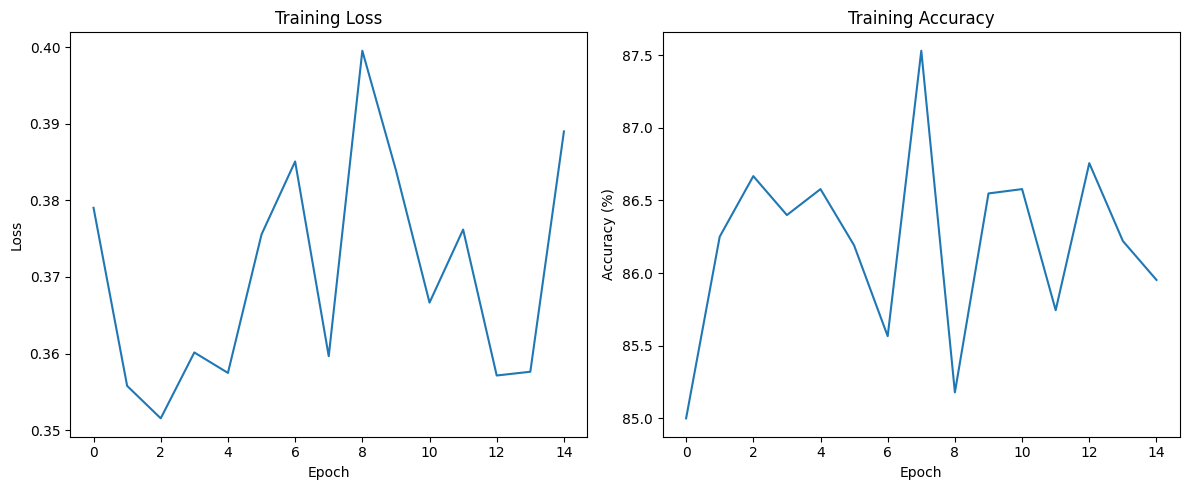


===== Generating Score-CAM Visualizations =====


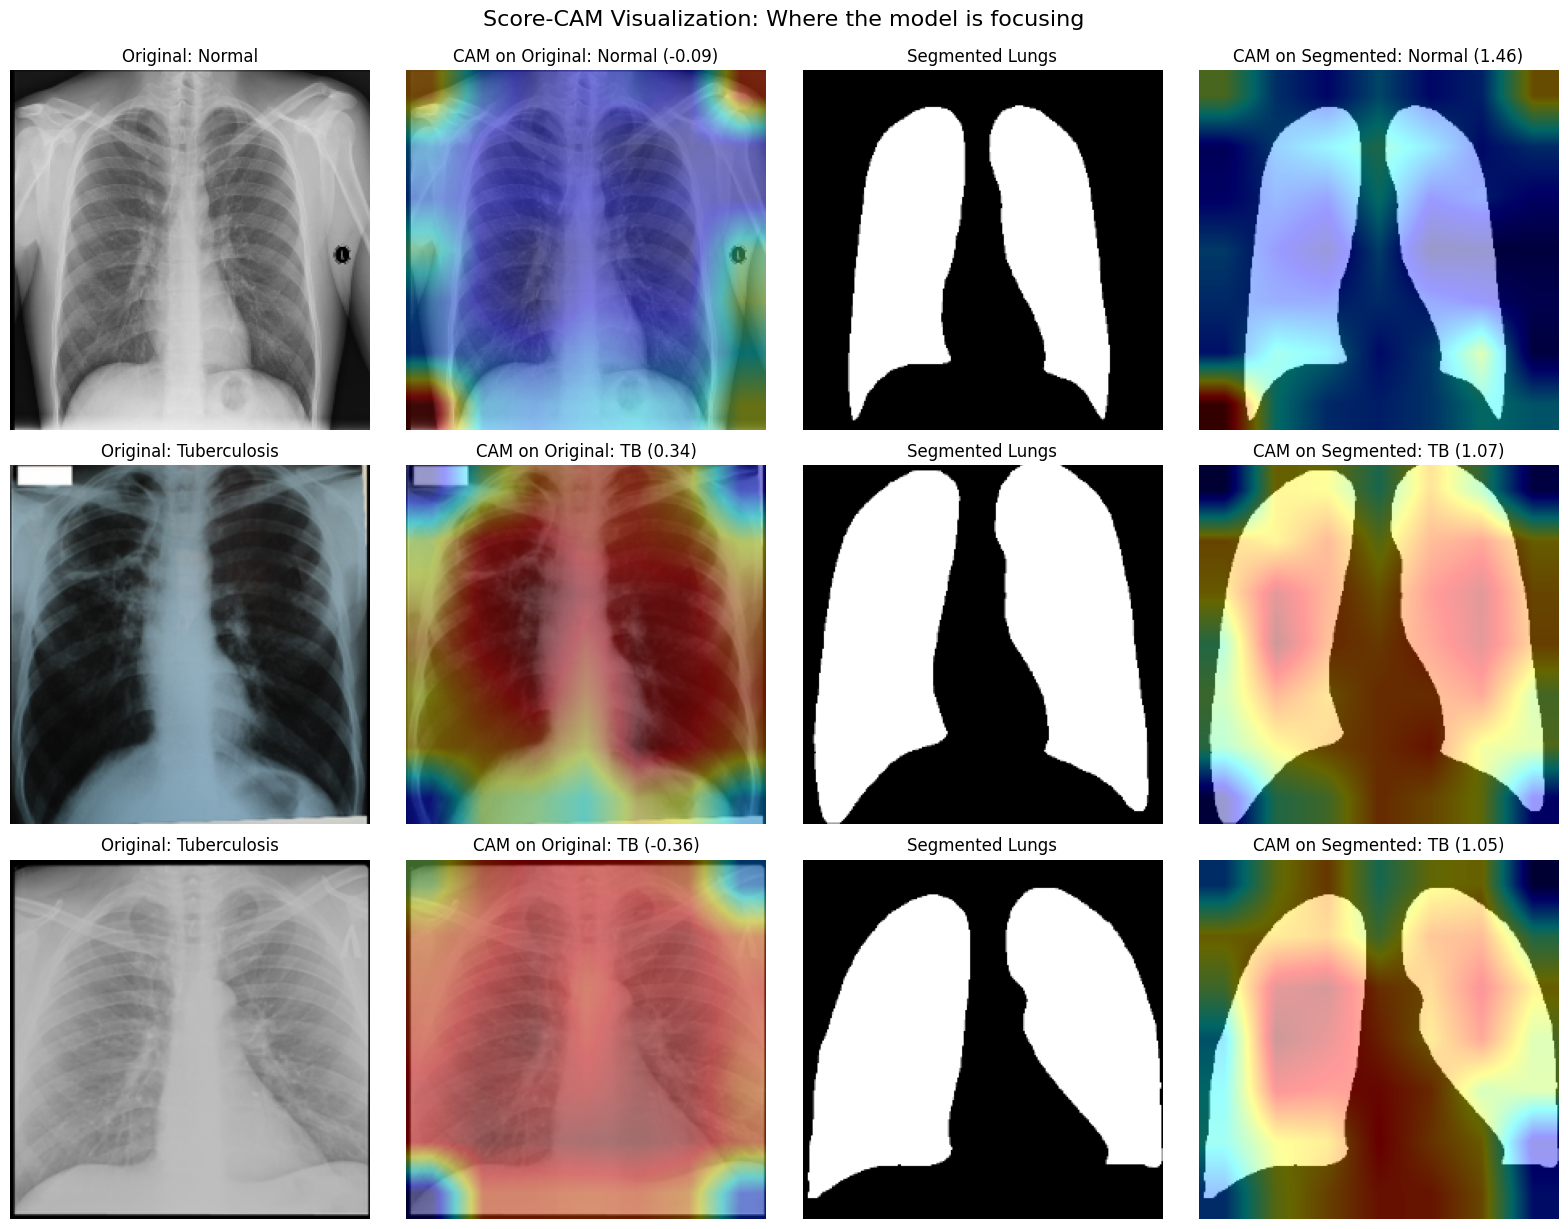

Score-CAM visualization saved

Model saved successfully.

Total runtime: 0h 9m 23s


In [ ]:

def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print_gpu_memory()


def load_segmentation_model():
    print("Loading pretrained chest X-ray segmentation model...")
    try:
        model = AutoModel.from_pretrained("ianpan/chest-x-ray-basic", trust_remote_code=True)
        model = model.eval().to(device)
        print("Successfully loaded pretrained segmentation model")
        return model
    except Exception as e:
        return None

# if unet doesnt work so manual
def basic_lung_segmentation(image):
    
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    
    
    _, binary = cv2.threshold(enhanced, 90, 255, cv2.THRESH_BINARY)
    
    
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    
    
    if len(image.shape) == 3:
        mask = np.stack([binary, binary, binary], axis=2) / 255.0
    else:
        mask = binary / 255.0
    
    segmented = image * mask
    
    return segmented


def segment_lungs(image, model=None):
    if model is None:
        return basic_lung_segmentation(image)
    orig_h, orig_w = image.shape[:2]
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = image
    try:
        x = model.preprocess(gray_img)  
        x = torch.from_numpy(x).unsqueeze(0).unsqueeze(0)  
        x = x.float().to(device)
        with torch.no_grad():
            out = model(x)
            torch.cuda.synchronize()  
        mask = out["mask"].squeeze().cpu().numpy()
        mask = mask.argmax(0) 
        binary_mask = np.zeros_like(mask)
        binary_mask[mask == 1] = 1  # Right lung
        binary_mask[mask == 2] = 1  # Left lung 
        if binary_mask.shape[0] != orig_h or binary_mask.shape[1] != orig_w:
            binary_mask = cv2.resize(binary_mask.astype(np.float32), (orig_w, orig_h))
        if len(image.shape) == 3:
            segmented = image * np.expand_dims(binary_mask, axis=2)
        else:
            segmented = image * binary_mask
        if segmented.dtype == np.float32 or segmented.dtype == np.float64:
            segmented = np.clip(segmented, 0, 1)
            segmented = (segmented * 255).astype(np.uint8)
        return segmented
    except Exception as e:
        print(f"Error in segmentation: {e}")
        print(traceback.format_exc())
        return basic_lung_segmentation(image)


def preprocess_and_cache_segmented_images(df, model, cache_dir='segmented_cache'):
    os.makedirs(cache_dir, exist_ok=True)
    print("Pre-processing and caching segmented images...")
    processed_count = 0
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        src_path = row['image_path']
        filename = os.path.basename(src_path)
        dest_path = os.path.join(cache_dir, filename)
        if os.path.exists(dest_path):
            processed_count += 1
            continue
        try:
            img = cv2.imread(src_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            segmented = segment_lungs(img, model)
            segmented = cv2.resize(segmented, (224, 224))
            cv2.imwrite(dest_path, cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))
            processed_count += 1
            if idx % 100 == 0:
                torch.cuda.empty_cache()        
        except Exception as e:
            print(f"Error processing {src_path}: {e}")
    print(f"Processed {processed_count} images. Cached at {cache_dir}/")
    new_df = df.copy()
    new_df['segmented_path'] = new_df['image_path'].apply(
        lambda x: os.path.join(cache_dir, os.path.basename(x))
    )
    
    return new_df


class OptimizedChestXRayDataset(Dataset):
    def __init__(self, dataframe, transform=None, use_segmented_paths=True):
        self.dataframe = dataframe
        self.transform = transform
        self.use_segmented_paths = use_segmented_paths and 'segmented_path' in dataframe.columns
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        
        if self.use_segmented_paths:
            img_path = self.dataframe.iloc[idx]['segmented_path']
        else:
            img_path = self.dataframe.iloc[idx]['image_path']
            
        label = 1 if self.dataframe.iloc[idx]['label'] == 'Tuberculosis' else 0
        
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        if img.shape[:2] != (224, 224):
            img = cv2.resize(img, (224, 224))
        
        
        if self.transform:
            if img.dtype == np.float32 or img.dtype == np.float64:
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)
            
            img = self.transform(img)
        
        return img, label


def get_transforms(is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

# optmize dataloader for faster training
def create_optimized_dataloaders(train_df, test_df, batch_size=8):
    train_transform = get_transforms(is_training=True)
    test_transform = get_transforms(is_training=False)
    
    train_dataset = OptimizedChestXRayDataset(
        train_df, 
        transform=train_transform,
        use_segmented_paths=True
    )
    
    test_dataset = OptimizedChestXRayDataset(
        test_df, 
        transform=test_transform,
        use_segmented_paths=True
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,  
        pin_memory=True  
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,  
        pin_memory=True  
    )
    
    return train_loader, test_loader


def setup_densenet201(num_classes=2):
    """Load and configure DenseNet201 for transfer learning"""
    
    model = models.densenet201(weights=models.DenseNet201_Weights.IMAGENET1K_V1)
    
    
    for param in model.parameters():
        param.requires_grad = False
    
    
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, num_classes)
    )
    
    
    for param in model.classifier.parameters():
        param.requires_grad = True
    
    return model


def train_model(model, train_loader, criterion, optimizer, device, num_epochs=15, use_early_stopping=False, patience=3):
    """Train the model with option to run full training without early stopping"""
    model.to(device)
    history = {'train_loss': [], 'train_acc': []}
    
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        start_time = time.time()
        
        try:
            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                
                if batch_count == 0:
                    print_gpu_memory()
                
                inputs, labels = inputs.to(device), labels.to(device)
                
                
                optimizer.zero_grad()
                
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                
                loss.backward()
                optimizer.step()
                
               
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                
                torch.cuda.empty_cache()
                batch_count += 1
                
                
                if batch_count % 10 == 0:
                    batch_acc = 100 * correct / total
                    print(f"Batch {batch_count}, Loss: {loss.item():.4f}, Running Acc: {batch_acc:.2f}%")
            
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = 100 * correct / total
            epoch_time = time.time() - start_time
            
            
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc)
            
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, '
                  f'Time: {epoch_time:.1f}s')
            
            
            torch.save(model.state_dict(), f'densenet201_tb_epoch_{epoch+1}.pth')
            
           
            if use_early_stopping:
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    patience_counter = 0
                    
                    torch.save(model.state_dict(), 'best_densenet201_tb.pth')
                    print("Saved best model checkpoint")
                else:
                    patience_counter += 1
                    print(f"Patience counter: {patience_counter}/{patience}")
                    
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            else:
                
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), 'best_densenet201_tb.pth')
                    print("Saved best model checkpoint")
                
        except Exception as e:
            print(f"Error during training: {e}")
            print(traceback.format_exc())
            
            torch.save(model.state_dict(), 'emergency_densenet201_tb.pth')
            print("Saved emergency checkpoint due to error")
            break
    
    
    try:
        model.load_state_dict(torch.load('best_densenet201_tb.pth'))
        print("Loaded best model for evaluation")
    except:
        print("Could not load best model, using current model")
    
    return model, history


def evaluate_model(model, test_loader, device):
    """Evaluate the model and calculate performance metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            
            torch.cuda.empty_cache()
    
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    
    if conf_matrix.size == 4:  
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
        
        print("Warning: Could not unpack confusion matrix")
        tn, fp, fn, tp = 0, 0, 0, 0
    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    
    
    try:
        precision = precision_score(all_labels, all_preds) * 100
    except:
        precision = 0
        
    try:
        recall = recall_score(all_labels, all_preds) * 100
    except:
        recall = 0
        
    try:
        f1 = f1_score(all_labels, all_preds) * 100
    except:
        f1 = 0
        
    try:
        specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
    except:
        specificity = 0
    
    try:
        auc = roc_auc_score(all_labels, all_preds) * 100
    except:
        auc = 0
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'auc': auc,
        'confusion_matrix': conf_matrix
    }
    
    return results

# visualization function
class ScoreCAM:
    """
    Implementation of Score-CAM visualization technique
    """
    def __init__(self, model, target_layer_name='features.denseblock4', device=None):
        self.model = model
        self.target_layer_name = target_layer_name
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
        self.outputs = []
        self.handles = []
        
        
        for name, module in self.model.named_modules():
            if target_layer_name in name:
                self.handles.append(
                    module.register_forward_hook(self._get_activation)
                )
    
    def _get_activation(self, module, input, output):
        
        self.outputs.append(output)
    
    def generate_cam(self, input_image, target_class=None):
        self.outputs = []
        with torch.no_grad():
            output = self.model(input_image)
        if target_class is None:
            pred_score, pred_class = torch.max(output, dim=1)
            target_class = pred_class.item()
        else:
            pred_class = target_class
            pred_score = output[0, target_class].item()
        activation_maps = self.outputs[0]  
        batch_size, channels, height, width = activation_maps.shape
        cam = torch.zeros((height, width), dtype=torch.float32, device=self.device)
        for i in range(channels):
            
            channel_map = activation_maps[0, i].unsqueeze(0).unsqueeze(0) 
            
            
            channel_map_norm = (channel_map - channel_map.min()) / (channel_map.max() - channel_map.min() + 1e-8)
            
            
            channel_map_upsampled = F.interpolate(
                channel_map_norm, 
                size=input_image.shape[2:], 
                mode='bilinear', 
                align_corners=False
            )
            
            
            with torch.no_grad():
                
                masked_input = input_image * channel_map_upsampled
                output = self.model(masked_input)
                score = output[0, target_class]
            
            
            cam += score.item() * channel_map[0, 0]
        
        
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        
        
        cam = cam.cpu().numpy()
        
        return cam, pred_class, pred_score
    
    def visualize(self, image_path, target_class=None, use_segmented=False, segmentation_model=None):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if use_segmented and segmentation_model is not None:
            img = segment_lungs(img, segmentation_model)
        img_resized = cv2.resize(img, (224, 224))
        if img_resized.dtype != np.uint8:
            img_resized = np.clip(img_resized, 0, 1) * 255
            img_resized = img_resized.astype(np.uint8)
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        cam, pred_class, pred_score = self.generate_cam(img_tensor, target_class)
        cam_resized = cv2.resize(cam, (img_resized.shape[1], img_resized.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        cam_img = (heatmap * 0.4 + img_resized * 0.6).astype(np.uint8)
        return img_resized, cam_img, pred_class, pred_score
    def __del__(self):
       
        for handle in self.handles:
            handle.remove()


def visualize_score_cam(model, test_df, segmentation_model=None, device=None, num_samples=3):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    
    normal_df = test_df[test_df['label'] == 'Normal'].sample(num_samples//2)
    tb_df = test_df[test_df['label'] == 'Tuberculosis'].sample(num_samples - num_samples//2)
    sample_df = pd.concat([normal_df, tb_df])
    score_cam = ScoreCAM(model, target_layer_name='features.denseblock4', device=device)
    fig, axes = plt.subplots(len(sample_df), 4, figsize=(16, 4*len(sample_df)))
    
    
    if len(sample_df) == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Process each image
    for i, (_, row) in enumerate(sample_df.iterrows()):
        try:
           
            img_path = row['image_path']
            label = row['label']
            
            
            if segmentation_model is not None and next(segmentation_model.parameters()).device != device:
                segmentation_model = segmentation_model.to(device)
            orig_img, orig_cam, orig_pred, orig_score = score_cam.visualize(
                img_path, 
                target_class=1 if label == 'Tuberculosis' else 0,
                use_segmented=False
            )
            # 2. Original image with segmentation
            seg_img, seg_cam, seg_pred, seg_score = score_cam.visualize(
                img_path, 
                target_class=1 if label == 'Tuberculosis' else 0,
                use_segmented=True,
                segmentation_model=segmentation_model
            )
            # Plot results
            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title(f"Original: {label}")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(orig_cam)
            axes[i, 1].set_title(f"CAM on Original: {'TB' if orig_pred == 1 else 'Normal'} ({orig_score:.2f})")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(seg_img)
            axes[i, 2].set_title(f"Segmented Lungs")
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(seg_cam)
            axes[i, 3].set_title(f"CAM on Segmented: {'TB' if seg_pred == 1 else 'Normal'} ({seg_score:.2f})")
            axes[i, 3].axis('off')
            
        except Exception as e:
            print(f"Error visualizing image {img_path}: {e}")
            traceback.print_exc()
    
    plt.tight_layout()
    plt.suptitle("Score-CAM Visualization: Where the model is focusing", fontsize=16, y=1.02)
    plt.savefig('score_cam_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Clean up
    if segmentation_model is not None:
        segmentation_model = segmentation_model.cpu()
    torch.cuda.empty_cache()
    
    return fig

# Main function with optimized workflow and Score-CAM
def main():
    total_start_time = time.time()
    base_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
    normal_path = os.path.join(base_path, 'Normal')
    tb_path = os.path.join(base_path, 'Tuberculosis')
    
    def create_dataset_df(normal_dir, tb_dir):
        normal_files = glob(os.path.join(normal_dir, '*.png'))
        tb_files = glob(os.path.join(tb_dir, '*.png'))
        
        files = normal_files + tb_files
        labels = ['Normal'] * len(normal_files) + ['Tuberculosis'] * len(tb_files)
        
        return pd.DataFrame({
            'image_path': files,
            'label': labels
        })
    
    df = create_dataset_df(normal_path, tb_path)
    print("\nDataset Information:")
    print(f"Total number of images: {len(df)}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    train_df, test_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42,
        stratify=df['label']
    )
    print("\nTrain/Test Split:")
    print(f"Training set: {len(train_df)} images")
    print(f"Testing set: {len(test_df)} images")
    try: 
        segmentation_model = load_segmentation_model()
        cache_dir = '/kaggle/working/segmented_cache'
        train_df = preprocess_and_cache_segmented_images(train_df, segmentation_model, cache_dir)
        test_df = preprocess_and_cache_segmented_images(test_df, segmentation_model, cache_dir) 
        segmentation_model = segmentation_model.cpu()
        torch.cuda.empty_cache()
        print_gpu_memory()
        print("\nCreating data loaders with pre-segmented lung images...")
        train_loader, test_loader = create_optimized_dataloaders(
            train_df, test_df, batch_size=8  
        )
        model = setup_densenet201(num_classes=2)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=0.001,
            momentum=0.9
        )

        print("\n===== Training DenseNet201 with Segmented Lungs =====")
        print_gpu_memory()
        model, history = train_model(
            model, train_loader, criterion, optimizer, device, 
            num_epochs=15,  
            use_early_stopping=False  
        )
        
        
        print("\n===== Evaluating Model =====")
        results = evaluate_model(model, test_loader, device)
        
        
        print("\n===== Results Summary =====")
        print(f"Accuracy: {results['accuracy']:.2f}% (Paper with segmentation: 99.90%)")
        print(f"Precision: {results['precision']:.2f}% (Paper with segmentation: 99.91%)")
        print(f"Sensitivity/Recall: {results['recall']:.2f}% (Paper with segmentation: 99.90%)")
        print(f"F1 Score: {results['f1_score']:.2f}% (Paper with segmentation: 99.90%)")
        print(f"Specificity: {results['specificity']:.2f}% (Paper with segmentation: 99.52%)")
        print(f"AUC: {results['auc']:.2f}%")
        print("\nConfusion Matrix:")
        print(results['confusion_matrix'])
        
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'])
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300)
        plt.show()
        
        
        print("\n===== Generating Score-CAM Visualizations =====")
        try:
            
            segmentation_model = segmentation_model.to(device)
            
            
            fig = visualize_score_cam(
                model=model,
                test_df=test_df,
                segmentation_model=segmentation_model,
                device=device,
                num_samples=3
            )
            
            
            fig.savefig('score_cam_visualization.png', dpi=300, bbox_inches='tight')
            print("Score-CAM visualization saved")
            
            
            segmentation_model = segmentation_model.cpu()
            torch.cuda.empty_cache()
            
        except Exception as e:
            print(f"Error in Score-CAM visualization: {e}")
            traceback.print_exc()
        
        
        torch.save(model.state_dict(), 'densenet201_tb_segmented.pth')
        print("\nModel saved successfully.")
        
    except Exception as e:
        print(f"Error in main execution: {e}")
        print(traceback.format_exc())
    
    finally:
        
        total_time = time.time() - total_start_time
        hours, remainder = divmod(total_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"\nTotal runtime: {int(hours)}h {int(minutes)}m {int(seconds)}s")


if __name__ == "__main__":
   
    try:
        import torch.multiprocessing as mp
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        # Method already set
        pass
    
    main()


# **Vision Transformers** 

Using device: cuda:0
GPU Memory Allocated: 9.90 GB
GPU Memory Reserved: 9.99 GB
Creating dataset dataframe...

Dataset Information:
Total number of images: 4200
Class distribution:
label
Normal          3500
Tuberculosis     700
Name: count, dtype: int64

Train/Test Split:
Training set: 3360 images
Testing set: 840 images
Loading pretrained chest X-ray segmentation model...
Successfully loaded pretrained segmentation model
Pre-processing and caching segmented images...


100%|██████████| 3360/3360 [00:00<00:00, 18606.16it/s]


Processed 3360 images. Cached at /kaggle/working/segmented_cache/
Pre-processing and caching segmented images...


100%|██████████| 840/840 [00:00<00:00, 17882.71it/s]


Processed 840 images. Cached at /kaggle/working/segmented_cache/
GPU Memory Allocated: 9.90 GB
GPU Memory Reserved: 9.99 GB

Creating data loaders with pre-segmented lung images...
Loading pretrained Vision Transformer: google/vit-base-patch16-224...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Vision Transformer loaded successfully with 2 output classes

===== Training Vision Transformer with Segmented Lungs =====
GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 1/15:   0%|          | 0/420 [00:00<?, ?it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 1/15:   3%|▎         | 11/420 [00:00<00:28, 14.30it/s]

Batch 10, Loss: 0.5539, Running Acc: 57.50%


Epoch 1/15:   5%|▌         | 23/420 [00:01<00:26, 14.83it/s]

Batch 20, Loss: 0.3972, Running Acc: 71.88%


Epoch 1/15:   7%|▋         | 31/420 [00:02<00:26, 14.74it/s]

Batch 30, Loss: 0.4330, Running Acc: 72.50%


Epoch 1/15:  10%|▉         | 41/420 [00:02<00:25, 14.83it/s]

Batch 40, Loss: 0.3959, Running Acc: 74.69%


Epoch 1/15:  13%|█▎        | 53/420 [00:03<00:24, 14.81it/s]

Batch 50, Loss: 0.8914, Running Acc: 75.00%


Epoch 1/15:  15%|█▍        | 61/420 [00:04<00:24, 14.81it/s]

Batch 60, Loss: 0.3230, Running Acc: 77.50%


Epoch 1/15:  17%|█▋        | 71/420 [00:04<00:23, 14.76it/s]

Batch 70, Loss: 0.3642, Running Acc: 79.29%


Epoch 1/15:  19%|█▉        | 81/420 [00:05<00:22, 14.75it/s]

Batch 80, Loss: 0.5409, Running Acc: 80.00%


Epoch 1/15:  22%|██▏       | 93/420 [00:06<00:21, 14.92it/s]

Batch 90, Loss: 0.5986, Running Acc: 80.56%


Epoch 1/15:  25%|██▍       | 103/420 [00:07<00:21, 14.92it/s]

Batch 100, Loss: 0.5340, Running Acc: 81.12%


Epoch 1/15:  26%|██▋       | 111/420 [00:07<00:20, 14.90it/s]

Batch 110, Loss: 0.3077, Running Acc: 81.48%


Epoch 1/15:  29%|██▉       | 121/420 [00:08<00:20, 14.81it/s]

Batch 120, Loss: 0.6076, Running Acc: 81.25%


Epoch 1/15:  32%|███▏      | 133/420 [00:09<00:19, 14.93it/s]

Batch 130, Loss: 0.3059, Running Acc: 82.12%


Epoch 1/15:  34%|███▍      | 143/420 [00:09<00:18, 14.90it/s]

Batch 140, Loss: 0.4884, Running Acc: 82.05%


Epoch 1/15:  36%|███▋      | 153/420 [00:10<00:18, 14.77it/s]

Batch 150, Loss: 0.2555, Running Acc: 81.92%


Epoch 1/15:  39%|███▉      | 163/420 [00:11<00:17, 14.91it/s]

Batch 160, Loss: 0.3376, Running Acc: 81.72%


Epoch 1/15:  41%|████      | 173/420 [00:11<00:16, 14.93it/s]

Batch 170, Loss: 0.4157, Running Acc: 81.91%


Epoch 1/15:  43%|████▎     | 181/420 [00:12<00:16, 14.72it/s]

Batch 180, Loss: 0.1095, Running Acc: 82.43%


Epoch 1/15:  45%|████▌     | 191/420 [00:12<00:15, 14.67it/s]

Batch 190, Loss: 0.8499, Running Acc: 82.37%


Epoch 1/15:  48%|████▊     | 203/420 [00:13<00:14, 14.75it/s]

Batch 200, Loss: 0.1346, Running Acc: 82.56%


Epoch 1/15:  51%|█████     | 213/420 [00:14<00:13, 14.86it/s]

Batch 210, Loss: 0.4604, Running Acc: 82.50%


Epoch 1/15:  53%|█████▎    | 223/420 [00:15<00:13, 14.80it/s]

Batch 220, Loss: 0.3833, Running Acc: 82.44%


Epoch 1/15:  55%|█████▌    | 231/420 [00:15<00:12, 14.90it/s]

Batch 230, Loss: 0.2427, Running Acc: 82.45%


Epoch 1/15:  57%|█████▋    | 241/420 [00:16<00:12, 14.85it/s]

Batch 240, Loss: 0.2808, Running Acc: 82.60%


Epoch 1/15:  60%|█████▉    | 251/420 [00:17<00:11, 14.80it/s]

Batch 250, Loss: 0.3311, Running Acc: 82.80%


Epoch 1/15:  63%|██████▎   | 263/420 [00:17<00:10, 14.85it/s]

Batch 260, Loss: 0.2976, Running Acc: 82.93%


Epoch 1/15:  65%|██████▌   | 273/420 [00:18<00:09, 14.94it/s]

Batch 270, Loss: 0.2118, Running Acc: 82.96%


Epoch 1/15:  67%|██████▋   | 281/420 [00:19<00:09, 14.91it/s]

Batch 280, Loss: 0.3113, Running Acc: 83.08%


Epoch 1/15:  69%|██████▉   | 291/420 [00:19<00:08, 14.80it/s]

Batch 290, Loss: 0.1701, Running Acc: 82.80%


Epoch 1/15:  72%|███████▏  | 301/420 [00:20<00:08, 14.80it/s]

Batch 300, Loss: 0.5550, Running Acc: 83.08%


Epoch 1/15:  74%|███████▍  | 311/420 [00:21<00:07, 14.76it/s]

Batch 310, Loss: 0.3805, Running Acc: 83.15%


Epoch 1/15:  76%|███████▋  | 321/420 [00:21<00:06, 14.88it/s]

Batch 320, Loss: 0.2266, Running Acc: 83.28%


Epoch 1/15:  79%|███████▉  | 333/420 [00:22<00:05, 14.81it/s]

Batch 330, Loss: 1.0210, Running Acc: 83.33%


Epoch 1/15:  82%|████████▏ | 343/420 [00:23<00:05, 14.74it/s]

Batch 340, Loss: 0.3069, Running Acc: 83.42%


Epoch 1/15:  84%|████████▎ | 351/420 [00:23<00:04, 14.76it/s]

Batch 350, Loss: 0.1447, Running Acc: 83.61%


Epoch 1/15:  86%|████████▋ | 363/420 [00:24<00:03, 14.83it/s]

Batch 360, Loss: 0.5400, Running Acc: 83.68%


Epoch 1/15:  88%|████████▊ | 371/420 [00:25<00:03, 14.90it/s]

Batch 370, Loss: 0.1225, Running Acc: 83.78%


Epoch 1/15:  91%|█████████ | 381/420 [00:25<00:02, 14.80it/s]

Batch 380, Loss: 0.2697, Running Acc: 83.82%


Epoch 1/15:  93%|█████████▎| 391/420 [00:26<00:01, 14.88it/s]

Batch 390, Loss: 0.3231, Running Acc: 83.81%


Epoch 1/15:  95%|█████████▌| 401/420 [00:27<00:01, 14.87it/s]

Batch 400, Loss: 0.2321, Running Acc: 83.84%


Epoch 1/15:  98%|█████████▊| 411/420 [00:27<00:00, 14.77it/s]

Batch 410, Loss: 0.4351, Running Acc: 83.84%


Epoch 1/15: 100%|██████████| 420/420 [00:28<00:00, 14.76it/s]


Batch 420, Loss: 0.2223, Running Acc: 83.99%
Epoch 1/15, Loss: 0.3749, Accuracy: 83.99%, Time: 28.5s
Saved best model checkpoint


Epoch 2/15:   0%|          | 2/420 [00:00<00:28, 14.60it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 2/15:   3%|▎         | 12/420 [00:00<00:28, 14.47it/s]

Batch 10, Loss: 0.2478, Running Acc: 90.00%


Epoch 2/15:   5%|▌         | 22/420 [00:01<00:27, 14.64it/s]

Batch 20, Loss: 0.1339, Running Acc: 88.12%


Epoch 2/15:   8%|▊         | 32/420 [00:02<00:26, 14.52it/s]

Batch 30, Loss: 0.1452, Running Acc: 87.92%


Epoch 2/15:  10%|█         | 42/420 [00:02<00:25, 14.64it/s]

Batch 40, Loss: 0.1355, Running Acc: 88.75%


Epoch 2/15:  12%|█▏        | 52/420 [00:03<00:24, 14.77it/s]

Batch 50, Loss: 0.1132, Running Acc: 87.75%


Epoch 2/15:  15%|█▍        | 62/420 [00:04<00:24, 14.72it/s]

Batch 60, Loss: 0.1256, Running Acc: 87.92%


Epoch 2/15:  17%|█▋        | 72/420 [00:04<00:23, 14.71it/s]

Batch 70, Loss: 0.3865, Running Acc: 87.86%


Epoch 2/15:  20%|█▉        | 82/420 [00:05<00:22, 14.81it/s]

Batch 80, Loss: 0.0961, Running Acc: 87.97%


Epoch 2/15:  22%|██▏       | 92/420 [00:06<00:22, 14.90it/s]

Batch 90, Loss: 0.0868, Running Acc: 88.47%


Epoch 2/15:  24%|██▍       | 102/420 [00:06<00:21, 14.79it/s]

Batch 100, Loss: 0.5528, Running Acc: 88.62%


Epoch 2/15:  27%|██▋       | 112/420 [00:07<00:20, 14.75it/s]

Batch 110, Loss: 0.2340, Running Acc: 88.52%


Epoch 2/15:  29%|██▉       | 122/420 [00:08<00:20, 14.85it/s]

Batch 120, Loss: 0.4290, Running Acc: 88.44%


Epoch 2/15:  31%|███▏      | 132/420 [00:08<00:19, 14.86it/s]

Batch 130, Loss: 0.2701, Running Acc: 88.37%


Epoch 2/15:  34%|███▍      | 142/420 [00:09<00:18, 14.72it/s]

Batch 140, Loss: 0.2596, Running Acc: 88.21%


Epoch 2/15:  36%|███▌      | 152/420 [00:10<00:18, 14.83it/s]

Batch 150, Loss: 0.2126, Running Acc: 88.67%


Epoch 2/15:  39%|███▊      | 162/420 [00:10<00:17, 14.90it/s]

Batch 160, Loss: 0.2433, Running Acc: 88.20%


Epoch 2/15:  41%|████      | 172/420 [00:11<00:16, 14.89it/s]

Batch 170, Loss: 0.3306, Running Acc: 88.24%


Epoch 2/15:  43%|████▎     | 182/420 [00:12<00:16, 14.70it/s]

Batch 180, Loss: 0.3121, Running Acc: 88.19%


Epoch 2/15:  46%|████▌     | 192/420 [00:13<00:15, 14.69it/s]

Batch 190, Loss: 0.2570, Running Acc: 88.09%


Epoch 2/15:  48%|████▊     | 202/420 [00:13<00:14, 14.62it/s]

Batch 200, Loss: 0.5842, Running Acc: 87.81%


Epoch 2/15:  50%|█████     | 212/420 [00:14<00:14, 14.64it/s]

Batch 210, Loss: 0.2424, Running Acc: 87.86%


Epoch 2/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.71it/s]

Batch 220, Loss: 0.3607, Running Acc: 87.67%


Epoch 2/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.76it/s]

Batch 230, Loss: 0.2410, Running Acc: 87.66%


Epoch 2/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.75it/s]

Batch 240, Loss: 0.2937, Running Acc: 87.92%


Epoch 2/15:  60%|██████    | 252/420 [00:17<00:11, 14.67it/s]

Batch 250, Loss: 0.3463, Running Acc: 88.00%


Epoch 2/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.67it/s]

Batch 260, Loss: 0.0582, Running Acc: 87.98%


Epoch 2/15:  65%|██████▍   | 272/420 [00:18<00:10, 14.74it/s]

Batch 270, Loss: 0.1876, Running Acc: 87.96%


Epoch 2/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.75it/s]

Batch 280, Loss: 0.3687, Running Acc: 87.99%


Epoch 2/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.67it/s]

Batch 290, Loss: 0.1178, Running Acc: 88.10%


Epoch 2/15:  72%|███████▏  | 302/420 [00:20<00:08, 14.66it/s]

Batch 300, Loss: 0.1430, Running Acc: 88.04%


Epoch 2/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.73it/s]

Batch 310, Loss: 0.2513, Running Acc: 88.10%


Epoch 2/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.78it/s]

Batch 320, Loss: 0.2552, Running Acc: 88.12%


Epoch 2/15:  79%|███████▉  | 332/420 [00:22<00:06, 14.62it/s]

Batch 330, Loss: 0.4396, Running Acc: 87.99%


Epoch 2/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.60it/s]

Batch 340, Loss: 0.1564, Running Acc: 87.98%


Epoch 2/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.64it/s]

Batch 350, Loss: 0.0708, Running Acc: 88.00%


Epoch 2/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.68it/s]

Batch 360, Loss: 0.0707, Running Acc: 87.88%


Epoch 2/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.70it/s]

Batch 370, Loss: 0.1166, Running Acc: 87.91%


Epoch 2/15:  91%|█████████ | 382/420 [00:25<00:02, 14.49it/s]

Batch 380, Loss: 0.6902, Running Acc: 87.80%


Epoch 2/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.61it/s]

Batch 390, Loss: 0.1862, Running Acc: 87.88%


Epoch 2/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.79it/s]

Batch 400, Loss: 1.1103, Running Acc: 87.97%


Epoch 2/15:  98%|█████████▊| 412/420 [00:28<00:00, 14.70it/s]

Batch 410, Loss: 0.4652, Running Acc: 88.02%


Epoch 2/15: 100%|██████████| 420/420 [00:28<00:00, 14.71it/s]


Batch 420, Loss: 0.2109, Running Acc: 87.98%
Epoch 2/15, Loss: 0.2964, Accuracy: 87.98%, Time: 28.6s
Saved best model checkpoint


Epoch 3/15:   0%|          | 2/420 [00:00<00:28, 14.58it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 3/15:   3%|▎         | 12/420 [00:00<00:27, 14.66it/s]

Batch 10, Loss: 0.2780, Running Acc: 90.00%


Epoch 3/15:   5%|▌         | 22/420 [00:01<00:26, 14.75it/s]

Batch 20, Loss: 0.4895, Running Acc: 88.75%


Epoch 3/15:   8%|▊         | 32/420 [00:02<00:26, 14.63it/s]

Batch 30, Loss: 0.2108, Running Acc: 89.58%


Epoch 3/15:  10%|█         | 42/420 [00:02<00:25, 14.87it/s]

Batch 40, Loss: 0.1138, Running Acc: 88.75%


Epoch 3/15:  12%|█▏        | 52/420 [00:03<00:24, 14.91it/s]

Batch 50, Loss: 0.1322, Running Acc: 89.50%


Epoch 3/15:  15%|█▍        | 62/420 [00:04<00:24, 14.85it/s]

Batch 60, Loss: 0.5314, Running Acc: 88.96%


Epoch 3/15:  17%|█▋        | 72/420 [00:04<00:23, 14.69it/s]

Batch 70, Loss: 0.1859, Running Acc: 88.75%


Epoch 3/15:  20%|█▉        | 82/420 [00:05<00:22, 14.73it/s]

Batch 80, Loss: 0.1309, Running Acc: 88.91%


Epoch 3/15:  22%|██▏       | 92/420 [00:06<00:22, 14.75it/s]

Batch 90, Loss: 0.4578, Running Acc: 88.47%


Epoch 3/15:  24%|██▍       | 102/420 [00:06<00:21, 14.73it/s]

Batch 100, Loss: 0.3619, Running Acc: 88.62%


Epoch 3/15:  27%|██▋       | 112/420 [00:07<00:20, 14.91it/s]

Batch 110, Loss: 0.5516, Running Acc: 88.30%


Epoch 3/15:  29%|██▉       | 122/420 [00:08<00:19, 14.99it/s]

Batch 120, Loss: 0.1754, Running Acc: 88.65%


Epoch 3/15:  31%|███▏      | 132/420 [00:08<00:19, 14.89it/s]

Batch 130, Loss: 0.2095, Running Acc: 88.75%


Epoch 3/15:  34%|███▍      | 142/420 [00:09<00:18, 14.76it/s]

Batch 140, Loss: 0.2713, Running Acc: 88.66%


Epoch 3/15:  36%|███▌      | 152/420 [00:10<00:18, 14.81it/s]

Batch 150, Loss: 0.9830, Running Acc: 88.50%


Epoch 3/15:  39%|███▊      | 162/420 [00:10<00:17, 14.82it/s]

Batch 160, Loss: 0.8032, Running Acc: 88.52%


Epoch 3/15:  41%|████      | 172/420 [00:11<00:16, 14.78it/s]

Batch 170, Loss: 0.1401, Running Acc: 88.68%


Epoch 3/15:  43%|████▎     | 182/420 [00:12<00:16, 14.70it/s]

Batch 180, Loss: 0.0907, Running Acc: 88.68%


Epoch 3/15:  46%|████▌     | 192/420 [00:12<00:15, 14.88it/s]

Batch 190, Loss: 0.2101, Running Acc: 88.68%


Epoch 3/15:  48%|████▊     | 202/420 [00:13<00:14, 14.87it/s]

Batch 200, Loss: 0.1681, Running Acc: 88.69%


Epoch 3/15:  50%|█████     | 212/420 [00:14<00:14, 14.75it/s]

Batch 210, Loss: 0.1617, Running Acc: 88.69%


Epoch 3/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.77it/s]

Batch 220, Loss: 0.3099, Running Acc: 88.75%


Epoch 3/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.81it/s]

Batch 230, Loss: 0.1339, Running Acc: 88.86%


Epoch 3/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.82it/s]

Batch 240, Loss: 0.1693, Running Acc: 88.85%


Epoch 3/15:  60%|██████    | 252/420 [00:17<00:11, 14.85it/s]

Batch 250, Loss: 0.0778, Running Acc: 88.80%


Epoch 3/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.88it/s]

Batch 260, Loss: 0.0935, Running Acc: 88.94%


Epoch 3/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.82it/s]

Batch 270, Loss: 0.6444, Running Acc: 88.89%


Epoch 3/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.81it/s]

Batch 280, Loss: 0.1322, Running Acc: 88.97%


Epoch 3/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.81it/s]

Batch 290, Loss: 0.1868, Running Acc: 89.01%


Epoch 3/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.79it/s]

Batch 300, Loss: 0.1043, Running Acc: 89.00%


Epoch 3/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.74it/s]

Batch 310, Loss: 0.1877, Running Acc: 89.11%


Epoch 3/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.73it/s]

Batch 320, Loss: 0.0623, Running Acc: 89.26%


Epoch 3/15:  79%|███████▉  | 332/420 [00:22<00:06, 14.66it/s]

Batch 330, Loss: 0.2553, Running Acc: 89.32%


Epoch 3/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.84it/s]

Batch 340, Loss: 0.1470, Running Acc: 89.30%


Epoch 3/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.82it/s]

Batch 350, Loss: 0.2739, Running Acc: 89.21%


Epoch 3/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.86it/s]

Batch 360, Loss: 0.4232, Running Acc: 89.31%


Epoch 3/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.77it/s]

Batch 370, Loss: 0.1158, Running Acc: 89.36%


Epoch 3/15:  91%|█████████ | 382/420 [00:25<00:02, 14.83it/s]

Batch 380, Loss: 0.6317, Running Acc: 89.38%


Epoch 3/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.87it/s]

Batch 390, Loss: 0.5367, Running Acc: 89.33%


Epoch 3/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.67it/s]

Batch 400, Loss: 0.2047, Running Acc: 89.34%


Epoch 3/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.82it/s]

Batch 410, Loss: 0.1681, Running Acc: 89.21%


Epoch 3/15: 100%|██████████| 420/420 [00:28<00:00, 14.79it/s]


Batch 420, Loss: 0.4466, Running Acc: 89.26%
Epoch 3/15, Loss: 0.2783, Accuracy: 89.26%, Time: 28.4s
Saved best model checkpoint


Epoch 4/15:   0%|          | 2/420 [00:00<00:28, 14.83it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 4/15:   3%|▎         | 12/420 [00:00<00:27, 14.82it/s]

Batch 10, Loss: 0.0823, Running Acc: 91.25%


Epoch 4/15:   5%|▌         | 22/420 [00:01<00:26, 14.87it/s]

Batch 20, Loss: 0.4158, Running Acc: 91.25%


Epoch 4/15:   8%|▊         | 32/420 [00:02<00:26, 14.48it/s]

Batch 30, Loss: 0.4981, Running Acc: 91.67%


Epoch 4/15:  10%|█         | 42/420 [00:02<00:25, 14.72it/s]

Batch 40, Loss: 0.0690, Running Acc: 90.94%


Epoch 4/15:  12%|█▏        | 52/420 [00:03<00:24, 14.82it/s]

Batch 50, Loss: 0.1478, Running Acc: 91.50%


Epoch 4/15:  15%|█▍        | 62/420 [00:04<00:24, 14.76it/s]

Batch 60, Loss: 0.1168, Running Acc: 91.88%


Epoch 4/15:  17%|█▋        | 72/420 [00:04<00:23, 14.68it/s]

Batch 70, Loss: 0.0735, Running Acc: 92.14%


Epoch 4/15:  20%|█▉        | 82/420 [00:05<00:22, 14.76it/s]

Batch 80, Loss: 0.1226, Running Acc: 92.19%


Epoch 4/15:  22%|██▏       | 92/420 [00:06<00:22, 14.59it/s]

Batch 90, Loss: 0.1769, Running Acc: 92.50%


Epoch 4/15:  24%|██▍       | 102/420 [00:06<00:21, 14.66it/s]

Batch 100, Loss: 0.1263, Running Acc: 92.00%


Epoch 4/15:  27%|██▋       | 112/420 [00:07<00:20, 14.86it/s]

Batch 110, Loss: 0.1757, Running Acc: 91.70%


Epoch 4/15:  29%|██▉       | 122/420 [00:08<00:19, 14.93it/s]

Batch 120, Loss: 0.2651, Running Acc: 91.56%


Epoch 4/15:  31%|███▏      | 132/420 [00:08<00:19, 14.77it/s]

Batch 130, Loss: 0.1695, Running Acc: 91.44%


Epoch 4/15:  34%|███▍      | 142/420 [00:09<00:18, 14.87it/s]

Batch 140, Loss: 0.2177, Running Acc: 90.98%


Epoch 4/15:  36%|███▌      | 152/420 [00:10<00:17, 14.95it/s]

Batch 150, Loss: 0.2306, Running Acc: 91.08%


Epoch 4/15:  39%|███▊      | 162/420 [00:10<00:17, 14.74it/s]

Batch 160, Loss: 0.2834, Running Acc: 91.09%


Epoch 4/15:  41%|████      | 172/420 [00:11<00:16, 14.77it/s]

Batch 170, Loss: 0.0657, Running Acc: 91.18%


Epoch 4/15:  43%|████▎     | 182/420 [00:12<00:16, 14.60it/s]

Batch 180, Loss: 0.0601, Running Acc: 91.32%


Epoch 4/15:  46%|████▌     | 192/420 [00:13<00:15, 14.80it/s]

Batch 190, Loss: 0.5353, Running Acc: 90.86%


Epoch 4/15:  48%|████▊     | 202/420 [00:13<00:14, 14.78it/s]

Batch 200, Loss: 0.1222, Running Acc: 90.94%


Epoch 4/15:  50%|█████     | 212/420 [00:14<00:14, 14.84it/s]

Batch 210, Loss: 0.1405, Running Acc: 91.07%


Epoch 4/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.88it/s]

Batch 220, Loss: 0.2040, Running Acc: 91.08%


Epoch 4/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.84it/s]

Batch 230, Loss: 0.4260, Running Acc: 91.14%


Epoch 4/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.80it/s]

Batch 240, Loss: 0.3122, Running Acc: 91.15%


Epoch 4/15:  60%|██████    | 252/420 [00:17<00:11, 14.85it/s]

Batch 250, Loss: 0.0988, Running Acc: 91.00%


Epoch 4/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.86it/s]

Batch 260, Loss: 0.4787, Running Acc: 90.82%


Epoch 4/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.87it/s]

Batch 270, Loss: 0.0722, Running Acc: 90.88%


Epoch 4/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.94it/s]

Batch 280, Loss: 0.3462, Running Acc: 90.76%


Epoch 4/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.78it/s]

Batch 290, Loss: 0.2736, Running Acc: 90.78%


Epoch 4/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.83it/s]

Batch 300, Loss: 0.1907, Running Acc: 90.54%


Epoch 4/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.83it/s]

Batch 310, Loss: 0.2563, Running Acc: 90.60%


Epoch 4/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.61it/s]

Batch 320, Loss: 0.3763, Running Acc: 90.51%


Epoch 4/15:  79%|███████▉  | 332/420 [00:22<00:06, 14.62it/s]

Batch 330, Loss: 0.4604, Running Acc: 90.42%


Epoch 4/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.81it/s]

Batch 340, Loss: 0.2452, Running Acc: 90.40%


Epoch 4/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.80it/s]

Batch 350, Loss: 0.5660, Running Acc: 90.29%


Epoch 4/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.82it/s]

Batch 360, Loss: 0.1402, Running Acc: 90.17%


Epoch 4/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.89it/s]

Batch 370, Loss: 0.4468, Running Acc: 90.17%


Epoch 4/15:  91%|█████████ | 382/420 [00:25<00:02, 14.95it/s]

Batch 380, Loss: 0.3560, Running Acc: 90.33%


Epoch 4/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.79it/s]

Batch 390, Loss: 0.1852, Running Acc: 90.32%


Epoch 4/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.73it/s]

Batch 400, Loss: 0.1294, Running Acc: 90.31%


Epoch 4/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.77it/s]

Batch 410, Loss: 0.0731, Running Acc: 90.43%


Epoch 4/15: 100%|██████████| 420/420 [00:28<00:00, 14.78it/s]


Batch 420, Loss: 0.1224, Running Acc: 90.45%
Epoch 4/15, Loss: 0.2582, Accuracy: 90.45%, Time: 28.4s
Saved best model checkpoint


Epoch 5/15:   0%|          | 2/420 [00:00<00:29, 14.22it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 5/15:   3%|▎         | 12/420 [00:00<00:27, 14.74it/s]

Batch 10, Loss: 0.5425, Running Acc: 92.50%


Epoch 5/15:   5%|▌         | 22/420 [00:01<00:26, 14.79it/s]

Batch 20, Loss: 0.0760, Running Acc: 91.25%


Epoch 5/15:   8%|▊         | 32/420 [00:02<00:26, 14.49it/s]

Batch 30, Loss: 0.6576, Running Acc: 90.42%


Epoch 5/15:  10%|█         | 42/420 [00:02<00:25, 14.80it/s]

Batch 40, Loss: 0.1406, Running Acc: 90.31%


Epoch 5/15:  12%|█▏        | 52/420 [00:03<00:24, 14.84it/s]

Batch 50, Loss: 0.2770, Running Acc: 89.25%


Epoch 5/15:  15%|█▍        | 62/420 [00:04<00:24, 14.74it/s]

Batch 60, Loss: 0.5284, Running Acc: 89.58%


Epoch 5/15:  17%|█▋        | 72/420 [00:04<00:23, 14.79it/s]

Batch 70, Loss: 0.4580, Running Acc: 89.64%


Epoch 5/15:  20%|█▉        | 82/420 [00:05<00:22, 14.73it/s]

Batch 80, Loss: 0.2117, Running Acc: 89.38%


Epoch 5/15:  22%|██▏       | 92/420 [00:06<00:22, 14.62it/s]

Batch 90, Loss: 0.2209, Running Acc: 89.44%


Epoch 5/15:  24%|██▍       | 102/420 [00:06<00:21, 14.71it/s]

Batch 100, Loss: 0.2975, Running Acc: 89.25%


Epoch 5/15:  27%|██▋       | 112/420 [00:07<00:20, 14.80it/s]

Batch 110, Loss: 0.0836, Running Acc: 89.55%


Epoch 5/15:  29%|██▉       | 122/420 [00:08<00:19, 14.92it/s]

Batch 120, Loss: 0.2198, Running Acc: 89.90%


Epoch 5/15:  31%|███▏      | 132/420 [00:08<00:19, 14.79it/s]

Batch 130, Loss: 0.1505, Running Acc: 89.81%


Epoch 5/15:  34%|███▍      | 142/420 [00:09<00:18, 14.82it/s]

Batch 140, Loss: 0.5364, Running Acc: 89.46%


Epoch 5/15:  36%|███▌      | 152/420 [00:10<00:18, 14.78it/s]

Batch 150, Loss: 0.5133, Running Acc: 89.83%


Epoch 5/15:  39%|███▊      | 162/420 [00:10<00:17, 14.70it/s]

Batch 160, Loss: 0.1971, Running Acc: 89.92%


Epoch 5/15:  41%|████      | 172/420 [00:11<00:16, 14.74it/s]

Batch 170, Loss: 0.1802, Running Acc: 90.00%


Epoch 5/15:  43%|████▎     | 182/420 [00:12<00:16, 14.63it/s]

Batch 180, Loss: 0.4542, Running Acc: 89.79%


Epoch 5/15:  46%|████▌     | 192/420 [00:13<00:15, 14.87it/s]

Batch 190, Loss: 0.1120, Running Acc: 90.00%


Epoch 5/15:  48%|████▊     | 202/420 [00:13<00:14, 14.72it/s]

Batch 200, Loss: 0.1877, Running Acc: 90.12%


Epoch 5/15:  50%|█████     | 212/420 [00:14<00:14, 14.66it/s]

Batch 210, Loss: 0.5073, Running Acc: 90.06%


Epoch 5/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.73it/s]

Batch 220, Loss: 0.3520, Running Acc: 90.00%


Epoch 5/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.70it/s]

Batch 230, Loss: 0.5810, Running Acc: 90.16%


Epoch 5/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.77it/s]

Batch 240, Loss: 0.1780, Running Acc: 90.36%


Epoch 5/15:  60%|██████    | 252/420 [00:17<00:11, 14.84it/s]

Batch 250, Loss: 0.3122, Running Acc: 90.40%


Epoch 5/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.80it/s]

Batch 260, Loss: 0.1163, Running Acc: 90.43%


Epoch 5/15:  65%|██████▍   | 272/420 [00:18<00:10, 14.77it/s]

Batch 270, Loss: 0.2577, Running Acc: 90.42%


Epoch 5/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.78it/s]

Batch 280, Loss: 0.3066, Running Acc: 90.31%


Epoch 5/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.75it/s]

Batch 290, Loss: 0.2758, Running Acc: 90.34%


Epoch 5/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.81it/s]

Batch 300, Loss: 0.4497, Running Acc: 90.25%


Epoch 5/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.84it/s]

Batch 310, Loss: 0.2476, Running Acc: 90.16%


Epoch 5/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.88it/s]

Batch 320, Loss: 0.2042, Running Acc: 90.12%


Epoch 5/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.74it/s]

Batch 330, Loss: 0.4697, Running Acc: 90.00%


Epoch 5/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.88it/s]

Batch 340, Loss: 0.4350, Running Acc: 89.96%


Epoch 5/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.96it/s]

Batch 350, Loss: 0.2534, Running Acc: 90.04%


Epoch 5/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.81it/s]

Batch 360, Loss: 0.1021, Running Acc: 90.00%


Epoch 5/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.86it/s]

Batch 370, Loss: 0.1047, Running Acc: 90.07%


Epoch 5/15:  91%|█████████ | 382/420 [00:25<00:02, 14.84it/s]

Batch 380, Loss: 0.0630, Running Acc: 90.03%


Epoch 5/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.77it/s]

Batch 390, Loss: 0.2493, Running Acc: 90.13%


Epoch 5/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.81it/s]

Batch 400, Loss: 0.1067, Running Acc: 90.16%


Epoch 5/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.88it/s]

Batch 410, Loss: 0.0745, Running Acc: 90.21%


Epoch 5/15: 100%|██████████| 420/420 [00:28<00:00, 14.77it/s]


Batch 420, Loss: 0.5857, Running Acc: 90.18%
Epoch 5/15, Loss: 0.2530, Accuracy: 90.18%, Time: 28.4s
Saved best model checkpoint


Epoch 6/15:   0%|          | 2/420 [00:00<00:30, 13.54it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 6/15:   3%|▎         | 12/420 [00:00<00:27, 14.67it/s]

Batch 10, Loss: 0.5022, Running Acc: 93.75%


Epoch 6/15:   5%|▌         | 22/420 [00:01<00:26, 14.75it/s]

Batch 20, Loss: 0.1607, Running Acc: 93.12%


Epoch 6/15:   8%|▊         | 32/420 [00:02<00:26, 14.65it/s]

Batch 30, Loss: 0.4526, Running Acc: 90.83%


Epoch 6/15:  10%|█         | 42/420 [00:02<00:25, 14.87it/s]

Batch 40, Loss: 0.1183, Running Acc: 90.62%


Epoch 6/15:  12%|█▏        | 52/420 [00:03<00:24, 14.88it/s]

Batch 50, Loss: 0.4188, Running Acc: 90.00%


Epoch 6/15:  15%|█▍        | 62/420 [00:04<00:24, 14.70it/s]

Batch 60, Loss: 0.1832, Running Acc: 90.21%


Epoch 6/15:  17%|█▋        | 72/420 [00:04<00:23, 14.82it/s]

Batch 70, Loss: 0.2676, Running Acc: 90.18%


Epoch 6/15:  20%|█▉        | 82/420 [00:05<00:22, 14.88it/s]

Batch 80, Loss: 0.1084, Running Acc: 90.31%


Epoch 6/15:  22%|██▏       | 92/420 [00:06<00:22, 14.78it/s]

Batch 90, Loss: 0.1644, Running Acc: 90.69%


Epoch 6/15:  24%|██▍       | 102/420 [00:06<00:21, 14.85it/s]

Batch 100, Loss: 0.0971, Running Acc: 90.75%


Epoch 6/15:  27%|██▋       | 112/420 [00:07<00:20, 14.98it/s]

Batch 110, Loss: 0.0248, Running Acc: 91.02%


Epoch 6/15:  29%|██▉       | 122/420 [00:08<00:20, 14.89it/s]

Batch 120, Loss: 0.0453, Running Acc: 91.25%


Epoch 6/15:  31%|███▏      | 132/420 [00:08<00:19, 14.78it/s]

Batch 130, Loss: 0.1537, Running Acc: 90.77%


Epoch 6/15:  34%|███▍      | 142/420 [00:09<00:18, 14.81it/s]

Batch 140, Loss: 0.0891, Running Acc: 91.07%


Epoch 6/15:  36%|███▌      | 152/420 [00:10<00:18, 14.81it/s]

Batch 150, Loss: 0.0618, Running Acc: 90.92%


Epoch 6/15:  39%|███▊      | 162/420 [00:10<00:17, 14.71it/s]

Batch 160, Loss: 0.5291, Running Acc: 90.70%


Epoch 6/15:  41%|████      | 172/420 [00:11<00:16, 14.87it/s]

Batch 170, Loss: 0.4120, Running Acc: 90.59%


Epoch 6/15:  43%|████▎     | 182/420 [00:12<00:16, 14.49it/s]

Batch 180, Loss: 0.2518, Running Acc: 90.90%


Epoch 6/15:  46%|████▌     | 192/420 [00:12<00:15, 14.83it/s]

Batch 190, Loss: 0.0813, Running Acc: 90.59%


Epoch 6/15:  48%|████▊     | 202/420 [00:13<00:14, 14.80it/s]

Batch 200, Loss: 0.4383, Running Acc: 90.75%


Epoch 6/15:  50%|█████     | 212/420 [00:14<00:14, 14.77it/s]

Batch 210, Loss: 0.3529, Running Acc: 90.65%


Epoch 6/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.83it/s]

Batch 220, Loss: 0.0792, Running Acc: 90.74%


Epoch 6/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.85it/s]

Batch 230, Loss: 0.1062, Running Acc: 90.71%


Epoch 6/15:  58%|█████▊    | 242/420 [00:16<00:11, 14.85it/s]

Batch 240, Loss: 0.0901, Running Acc: 90.78%


Epoch 6/15:  60%|██████    | 252/420 [00:17<00:11, 15.01it/s]

Batch 250, Loss: 0.1179, Running Acc: 90.85%


Epoch 6/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.85it/s]

Batch 260, Loss: 0.3404, Running Acc: 90.58%


Epoch 6/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.81it/s]

Batch 270, Loss: 0.2290, Running Acc: 90.65%


Epoch 6/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.81it/s]

Batch 280, Loss: 0.1542, Running Acc: 90.76%


Epoch 6/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.81it/s]

Batch 290, Loss: 0.2893, Running Acc: 90.69%


Epoch 6/15:  72%|███████▏  | 302/420 [00:20<00:08, 14.75it/s]

Batch 300, Loss: 0.1474, Running Acc: 90.62%


Epoch 6/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.78it/s]

Batch 310, Loss: 0.6233, Running Acc: 90.44%


Epoch 6/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.88it/s]

Batch 320, Loss: 0.0596, Running Acc: 90.55%


Epoch 6/15:  79%|███████▉  | 332/420 [00:22<00:06, 14.64it/s]

Batch 330, Loss: 0.3097, Running Acc: 90.64%


Epoch 6/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.97it/s]

Batch 340, Loss: 0.1035, Running Acc: 90.55%


Epoch 6/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.93it/s]

Batch 350, Loss: 0.2911, Running Acc: 90.54%


Epoch 6/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.74it/s]

Batch 360, Loss: 0.3105, Running Acc: 90.56%


Epoch 6/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.93it/s]

Batch 370, Loss: 0.1504, Running Acc: 90.61%


Epoch 6/15:  91%|█████████ | 382/420 [00:25<00:02, 14.85it/s]

Batch 380, Loss: 0.1047, Running Acc: 90.62%


Epoch 6/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.81it/s]

Batch 390, Loss: 0.0396, Running Acc: 90.67%


Epoch 6/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.67it/s]

Batch 400, Loss: 0.5241, Running Acc: 90.69%


Epoch 6/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.83it/s]

Batch 410, Loss: 0.2977, Running Acc: 90.76%


Epoch 6/15: 100%|██████████| 420/420 [00:28<00:00, 14.80it/s]


Batch 420, Loss: 0.1808, Running Acc: 90.80%
Epoch 6/15, Loss: 0.2469, Accuracy: 90.80%, Time: 28.4s
Saved best model checkpoint


Epoch 7/15:   0%|          | 2/420 [00:00<00:30, 13.81it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 7/15:   3%|▎         | 12/420 [00:00<00:27, 14.71it/s]

Batch 10, Loss: 0.0392, Running Acc: 87.50%


Epoch 7/15:   5%|▌         | 22/420 [00:01<00:27, 14.66it/s]

Batch 20, Loss: 0.3753, Running Acc: 85.00%


Epoch 7/15:   8%|▊         | 32/420 [00:02<00:26, 14.73it/s]

Batch 30, Loss: 0.1313, Running Acc: 86.25%


Epoch 7/15:  10%|█         | 42/420 [00:02<00:25, 14.69it/s]

Batch 40, Loss: 0.3725, Running Acc: 87.81%


Epoch 7/15:  12%|█▏        | 52/420 [00:03<00:24, 14.84it/s]

Batch 50, Loss: 0.4940, Running Acc: 89.00%


Epoch 7/15:  15%|█▍        | 62/420 [00:04<00:24, 14.84it/s]

Batch 60, Loss: 0.0719, Running Acc: 90.00%


Epoch 7/15:  17%|█▋        | 72/420 [00:04<00:23, 14.83it/s]

Batch 70, Loss: 0.1688, Running Acc: 89.82%


Epoch 7/15:  20%|█▉        | 82/420 [00:05<00:22, 14.80it/s]

Batch 80, Loss: 0.1231, Running Acc: 90.16%


Epoch 7/15:  22%|██▏       | 92/420 [00:06<00:22, 14.80it/s]

Batch 90, Loss: 0.6287, Running Acc: 90.56%


Epoch 7/15:  24%|██▍       | 102/420 [00:06<00:21, 14.94it/s]

Batch 100, Loss: 0.2462, Running Acc: 90.50%


Epoch 7/15:  27%|██▋       | 112/420 [00:07<00:20, 14.87it/s]

Batch 110, Loss: 0.0564, Running Acc: 90.45%


Epoch 7/15:  29%|██▉       | 122/420 [00:08<00:20, 14.86it/s]

Batch 120, Loss: 0.1176, Running Acc: 90.52%


Epoch 7/15:  31%|███▏      | 132/420 [00:08<00:19, 14.75it/s]

Batch 130, Loss: 0.1740, Running Acc: 90.96%


Epoch 7/15:  34%|███▍      | 142/420 [00:09<00:18, 14.80it/s]

Batch 140, Loss: 0.0495, Running Acc: 91.16%


Epoch 7/15:  36%|███▌      | 152/420 [00:10<00:18, 14.82it/s]

Batch 150, Loss: 0.2179, Running Acc: 90.75%


Epoch 7/15:  39%|███▊      | 162/420 [00:10<00:17, 14.80it/s]

Batch 160, Loss: 0.3010, Running Acc: 91.02%


Epoch 7/15:  41%|████      | 172/420 [00:11<00:16, 14.89it/s]

Batch 170, Loss: 0.3935, Running Acc: 91.03%


Epoch 7/15:  43%|████▎     | 182/420 [00:12<00:16, 14.87it/s]

Batch 180, Loss: 0.0468, Running Acc: 91.04%


Epoch 7/15:  46%|████▌     | 192/420 [00:12<00:15, 14.65it/s]

Batch 190, Loss: 0.4163, Running Acc: 91.12%


Epoch 7/15:  48%|████▊     | 202/420 [00:13<00:14, 14.73it/s]

Batch 200, Loss: 0.0417, Running Acc: 91.31%


Epoch 7/15:  50%|█████     | 212/420 [00:14<00:14, 14.82it/s]

Batch 210, Loss: 0.0655, Running Acc: 90.95%


Epoch 7/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.86it/s]

Batch 220, Loss: 1.0761, Running Acc: 90.62%


Epoch 7/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.78it/s]

Batch 230, Loss: 0.2348, Running Acc: 90.49%


Epoch 7/15:  58%|█████▊    | 242/420 [00:16<00:11, 14.85it/s]

Batch 240, Loss: 0.1752, Running Acc: 90.57%


Epoch 7/15:  60%|██████    | 252/420 [00:17<00:11, 14.91it/s]

Batch 250, Loss: 0.0639, Running Acc: 90.65%


Epoch 7/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.87it/s]

Batch 260, Loss: 0.1717, Running Acc: 90.91%


Epoch 7/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.85it/s]

Batch 270, Loss: 0.0503, Running Acc: 90.97%


Epoch 7/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.79it/s]

Batch 280, Loss: 0.0276, Running Acc: 91.03%


Epoch 7/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.72it/s]

Batch 290, Loss: 0.1160, Running Acc: 90.73%


Epoch 7/15:  72%|███████▏  | 302/420 [00:20<00:08, 14.71it/s]

Batch 300, Loss: 0.3492, Running Acc: 90.62%


Epoch 7/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.80it/s]

Batch 310, Loss: 0.2591, Running Acc: 90.85%


Epoch 7/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.87it/s]

Batch 320, Loss: 0.1729, Running Acc: 90.78%


Epoch 7/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.75it/s]

Batch 330, Loss: 0.1649, Running Acc: 90.72%


Epoch 7/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.86it/s]

Batch 340, Loss: 0.0483, Running Acc: 90.62%


Epoch 7/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.93it/s]

Batch 350, Loss: 0.3616, Running Acc: 90.61%


Epoch 7/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.73it/s]

Batch 360, Loss: 0.3104, Running Acc: 90.66%


Epoch 7/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.69it/s]

Batch 370, Loss: 0.5980, Running Acc: 90.68%


Epoch 7/15:  91%|█████████ | 382/420 [00:25<00:02, 14.80it/s]

Batch 380, Loss: 0.1532, Running Acc: 90.62%


Epoch 7/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.74it/s]

Batch 390, Loss: 0.0321, Running Acc: 90.77%


Epoch 7/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.87it/s]

Batch 400, Loss: 0.0679, Running Acc: 90.84%


Epoch 7/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.91it/s]

Batch 410, Loss: 0.1934, Running Acc: 90.88%


Epoch 7/15: 100%|██████████| 420/420 [00:28<00:00, 14.79it/s]


Batch 420, Loss: 0.4232, Running Acc: 90.83%
Epoch 7/15, Loss: 0.2378, Accuracy: 90.83%, Time: 28.4s
Saved best model checkpoint


Epoch 8/15:   0%|          | 2/420 [00:00<00:30, 13.64it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 8/15:   3%|▎         | 12/420 [00:00<00:27, 14.79it/s]

Batch 10, Loss: 0.3022, Running Acc: 91.25%


Epoch 8/15:   5%|▌         | 22/420 [00:01<00:27, 14.71it/s]

Batch 20, Loss: 0.7688, Running Acc: 90.62%


Epoch 8/15:   8%|▊         | 32/420 [00:02<00:26, 14.83it/s]

Batch 30, Loss: 0.0661, Running Acc: 91.25%


Epoch 8/15:  10%|█         | 42/420 [00:02<00:25, 14.57it/s]

Batch 40, Loss: 0.0820, Running Acc: 91.56%


Epoch 8/15:  12%|█▏        | 52/420 [00:03<00:25, 14.70it/s]

Batch 50, Loss: 0.2178, Running Acc: 91.00%


Epoch 8/15:  15%|█▍        | 62/420 [00:04<00:24, 14.72it/s]

Batch 60, Loss: 0.0720, Running Acc: 90.42%


Epoch 8/15:  17%|█▋        | 72/420 [00:04<00:23, 14.79it/s]

Batch 70, Loss: 0.2484, Running Acc: 90.89%


Epoch 8/15:  20%|█▉        | 82/420 [00:05<00:22, 14.70it/s]

Batch 80, Loss: 0.1555, Running Acc: 90.00%


Epoch 8/15:  22%|██▏       | 92/420 [00:06<00:22, 14.71it/s]

Batch 90, Loss: 0.1998, Running Acc: 89.72%


Epoch 8/15:  24%|██▍       | 102/420 [00:06<00:21, 14.81it/s]

Batch 100, Loss: 0.5321, Running Acc: 90.00%


Epoch 8/15:  27%|██▋       | 112/420 [00:07<00:20, 14.83it/s]

Batch 110, Loss: 0.1322, Running Acc: 90.00%


Epoch 8/15:  29%|██▉       | 122/420 [00:08<00:20, 14.76it/s]

Batch 120, Loss: 0.2977, Running Acc: 90.00%


Epoch 8/15:  31%|███▏      | 132/420 [00:08<00:19, 14.79it/s]

Batch 130, Loss: 0.3075, Running Acc: 89.81%


Epoch 8/15:  34%|███▍      | 142/420 [00:09<00:18, 14.85it/s]

Batch 140, Loss: 0.3066, Running Acc: 89.82%


Epoch 8/15:  36%|███▌      | 152/420 [00:10<00:18, 14.87it/s]

Batch 150, Loss: 0.1132, Running Acc: 90.08%


Epoch 8/15:  39%|███▊      | 162/420 [00:10<00:17, 14.76it/s]

Batch 160, Loss: 0.4553, Running Acc: 89.92%


Epoch 8/15:  41%|████      | 172/420 [00:11<00:16, 14.73it/s]

Batch 170, Loss: 0.2242, Running Acc: 90.15%


Epoch 8/15:  43%|████▎     | 182/420 [00:12<00:16, 14.77it/s]

Batch 180, Loss: 0.0897, Running Acc: 90.42%


Epoch 8/15:  46%|████▌     | 192/420 [00:13<00:15, 14.62it/s]

Batch 190, Loss: 0.2927, Running Acc: 90.46%


Epoch 8/15:  48%|████▊     | 202/420 [00:13<00:14, 14.78it/s]

Batch 200, Loss: 0.2836, Running Acc: 90.25%


Epoch 8/15:  50%|█████     | 212/420 [00:14<00:14, 14.85it/s]

Batch 210, Loss: 0.0623, Running Acc: 90.42%


Epoch 8/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.84it/s]

Batch 220, Loss: 0.0841, Running Acc: 90.57%


Epoch 8/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.72it/s]

Batch 230, Loss: 0.4345, Running Acc: 90.60%


Epoch 8/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.79it/s]

Batch 240, Loss: 0.3627, Running Acc: 90.36%


Epoch 8/15:  60%|██████    | 252/420 [00:17<00:11, 14.77it/s]

Batch 250, Loss: 0.0795, Running Acc: 90.40%


Epoch 8/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.83it/s]

Batch 260, Loss: 0.3956, Running Acc: 90.34%


Epoch 8/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.94it/s]

Batch 270, Loss: 0.1681, Running Acc: 90.56%


Epoch 8/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.93it/s]

Batch 280, Loss: 0.3610, Running Acc: 90.49%


Epoch 8/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.88it/s]

Batch 290, Loss: 0.1292, Running Acc: 90.73%


Epoch 8/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.86it/s]

Batch 300, Loss: 0.6416, Running Acc: 90.75%


Epoch 8/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.72it/s]

Batch 310, Loss: 0.5903, Running Acc: 90.77%


Epoch 8/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.76it/s]

Batch 320, Loss: 0.1378, Running Acc: 90.86%


Epoch 8/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.91it/s]

Batch 330, Loss: 0.1255, Running Acc: 90.83%


Epoch 8/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.84it/s]

Batch 340, Loss: 0.0794, Running Acc: 90.92%


Epoch 8/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.84it/s]

Batch 350, Loss: 0.1680, Running Acc: 90.89%


Epoch 8/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.50it/s]

Batch 360, Loss: 0.0801, Running Acc: 90.90%


Epoch 8/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.53it/s]

Batch 370, Loss: 0.3256, Running Acc: 90.91%


Epoch 8/15:  91%|█████████ | 382/420 [00:25<00:02, 14.65it/s]

Batch 380, Loss: 0.0649, Running Acc: 90.86%


Epoch 8/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.73it/s]

Batch 390, Loss: 0.2061, Running Acc: 90.74%


Epoch 8/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.84it/s]

Batch 400, Loss: 0.1929, Running Acc: 90.84%


Epoch 8/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.87it/s]

Batch 410, Loss: 0.0415, Running Acc: 90.91%


Epoch 8/15: 100%|██████████| 420/420 [00:28<00:00, 14.76it/s]


Batch 420, Loss: 0.3481, Running Acc: 90.86%
Epoch 8/15, Loss: 0.2375, Accuracy: 90.86%, Time: 28.5s
Saved best model checkpoint


Epoch 9/15:   0%|          | 2/420 [00:00<00:28, 14.45it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 9/15:   3%|▎         | 12/420 [00:00<00:27, 14.69it/s]

Batch 10, Loss: 0.2171, Running Acc: 96.25%


Epoch 9/15:   5%|▌         | 22/420 [00:01<00:26, 14.87it/s]

Batch 20, Loss: 0.4444, Running Acc: 90.00%


Epoch 9/15:   8%|▊         | 32/420 [00:02<00:26, 14.90it/s]

Batch 30, Loss: 0.3035, Running Acc: 90.42%


Epoch 9/15:  10%|█         | 42/420 [00:02<00:26, 14.53it/s]

Batch 40, Loss: 0.1004, Running Acc: 90.94%


Epoch 9/15:  12%|█▏        | 52/420 [00:03<00:24, 14.73it/s]

Batch 50, Loss: 0.1661, Running Acc: 89.75%


Epoch 9/15:  15%|█▍        | 62/420 [00:04<00:24, 14.85it/s]

Batch 60, Loss: 0.0916, Running Acc: 90.62%


Epoch 9/15:  17%|█▋        | 72/420 [00:04<00:23, 14.82it/s]

Batch 70, Loss: 0.3360, Running Acc: 90.89%


Epoch 9/15:  20%|█▉        | 82/420 [00:05<00:22, 14.71it/s]

Batch 80, Loss: 0.0856, Running Acc: 91.09%


Epoch 9/15:  22%|██▏       | 92/420 [00:06<00:22, 14.88it/s]

Batch 90, Loss: 0.7467, Running Acc: 90.97%


Epoch 9/15:  24%|██▍       | 102/420 [00:06<00:21, 14.90it/s]

Batch 100, Loss: 0.2484, Running Acc: 90.88%


Epoch 9/15:  27%|██▋       | 112/420 [00:07<00:20, 14.86it/s]

Batch 110, Loss: 0.2691, Running Acc: 91.02%


Epoch 9/15:  29%|██▉       | 122/420 [00:08<00:20, 14.77it/s]

Batch 120, Loss: 0.2827, Running Acc: 91.04%


Epoch 9/15:  31%|███▏      | 132/420 [00:08<00:19, 14.83it/s]

Batch 130, Loss: 0.1680, Running Acc: 91.06%


Epoch 9/15:  34%|███▍      | 142/420 [00:09<00:18, 14.89it/s]

Batch 140, Loss: 0.3242, Running Acc: 90.98%


Epoch 9/15:  36%|███▌      | 152/420 [00:10<00:18, 14.82it/s]

Batch 150, Loss: 0.0869, Running Acc: 91.25%


Epoch 9/15:  39%|███▊      | 162/420 [00:10<00:17, 14.97it/s]

Batch 160, Loss: 0.0655, Running Acc: 91.64%


Epoch 9/15:  41%|████      | 172/420 [00:11<00:16, 14.88it/s]

Batch 170, Loss: 0.4018, Running Acc: 91.69%


Epoch 9/15:  43%|████▎     | 182/420 [00:12<00:16, 14.81it/s]

Batch 180, Loss: 0.4343, Running Acc: 91.81%


Epoch 9/15:  46%|████▌     | 192/420 [00:12<00:15, 14.60it/s]

Batch 190, Loss: 0.1903, Running Acc: 91.91%


Epoch 9/15:  48%|████▊     | 202/420 [00:13<00:14, 14.77it/s]

Batch 200, Loss: 0.1060, Running Acc: 92.06%


Epoch 9/15:  50%|█████     | 212/420 [00:14<00:13, 14.91it/s]

Batch 210, Loss: 0.2470, Running Acc: 91.96%


Epoch 9/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.83it/s]

Batch 220, Loss: 0.2501, Running Acc: 92.16%


Epoch 9/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.95it/s]

Batch 230, Loss: 0.0546, Running Acc: 92.07%


Epoch 9/15:  58%|█████▊    | 242/420 [00:16<00:11, 14.93it/s]

Batch 240, Loss: 0.1076, Running Acc: 92.14%


Epoch 9/15:  60%|██████    | 252/420 [00:16<00:11, 14.82it/s]

Batch 250, Loss: 0.1663, Running Acc: 92.05%


Epoch 9/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.77it/s]

Batch 260, Loss: 0.3000, Running Acc: 91.83%


Epoch 9/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.81it/s]

Batch 270, Loss: 0.2139, Running Acc: 91.81%


Epoch 9/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.84it/s]

Batch 280, Loss: 0.1575, Running Acc: 91.65%


Epoch 9/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.81it/s]

Batch 290, Loss: 0.2704, Running Acc: 91.59%


Epoch 9/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.86it/s]

Batch 300, Loss: 0.0808, Running Acc: 91.58%


Epoch 9/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.85it/s]

Batch 310, Loss: 0.1400, Running Acc: 91.57%


Epoch 9/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.69it/s]

Batch 320, Loss: 0.2492, Running Acc: 91.52%


Epoch 9/15:  79%|███████▉  | 332/420 [00:22<00:06, 14.64it/s]

Batch 330, Loss: 0.1035, Running Acc: 91.55%


Epoch 9/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.36it/s]

Batch 340, Loss: 0.0887, Running Acc: 91.51%


Epoch 9/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.36it/s]

Batch 350, Loss: 0.3434, Running Acc: 91.50%


Epoch 9/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.72it/s]

Batch 360, Loss: 0.0941, Running Acc: 91.49%


Epoch 9/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.62it/s]

Batch 370, Loss: 0.0659, Running Acc: 91.49%


Epoch 9/15:  91%|█████████ | 382/420 [00:25<00:02, 14.74it/s]

Batch 380, Loss: 0.0877, Running Acc: 91.64%


Epoch 9/15:  93%|█████████▎| 392/420 [00:26<00:02, 13.98it/s]

Batch 390, Loss: 0.0833, Running Acc: 91.76%


Epoch 9/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.33it/s]

Batch 400, Loss: 0.0197, Running Acc: 91.88%


Epoch 9/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.57it/s]

Batch 410, Loss: 0.0120, Running Acc: 91.95%


Epoch 9/15: 100%|██████████| 420/420 [00:28<00:00, 14.74it/s]


Batch 420, Loss: 0.2801, Running Acc: 91.79%
Epoch 9/15, Loss: 0.2311, Accuracy: 91.79%, Time: 28.5s
Saved best model checkpoint


Epoch 10/15:   0%|          | 2/420 [00:00<00:29, 14.31it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 10/15:   3%|▎         | 12/420 [00:00<00:27, 14.75it/s]

Batch 10, Loss: 0.1062, Running Acc: 85.00%


Epoch 10/15:   5%|▌         | 22/420 [00:01<00:26, 14.86it/s]

Batch 20, Loss: 0.2925, Running Acc: 89.38%


Epoch 10/15:   8%|▊         | 32/420 [00:02<00:26, 14.91it/s]

Batch 30, Loss: 0.5752, Running Acc: 88.75%


Epoch 10/15:  10%|█         | 42/420 [00:02<00:25, 14.61it/s]

Batch 40, Loss: 0.0791, Running Acc: 89.06%


Epoch 10/15:  12%|█▏        | 52/420 [00:03<00:24, 14.90it/s]

Batch 50, Loss: 0.5224, Running Acc: 89.25%


Epoch 10/15:  15%|█▍        | 62/420 [00:04<00:24, 14.91it/s]

Batch 60, Loss: 0.2262, Running Acc: 88.54%


Epoch 10/15:  17%|█▋        | 72/420 [00:04<00:23, 14.80it/s]

Batch 70, Loss: 0.0743, Running Acc: 88.93%


Epoch 10/15:  20%|█▉        | 82/420 [00:05<00:22, 14.78it/s]

Batch 80, Loss: 0.0608, Running Acc: 89.53%


Epoch 10/15:  22%|██▏       | 92/420 [00:06<00:22, 14.59it/s]

Batch 90, Loss: 0.1456, Running Acc: 89.58%


Epoch 10/15:  24%|██▍       | 102/420 [00:06<00:21, 14.77it/s]

Batch 100, Loss: 0.6299, Running Acc: 89.50%


Epoch 10/15:  27%|██▋       | 112/420 [00:07<00:20, 14.81it/s]

Batch 110, Loss: 0.0659, Running Acc: 89.89%


Epoch 10/15:  29%|██▉       | 122/420 [00:08<00:19, 15.00it/s]

Batch 120, Loss: 0.2339, Running Acc: 89.79%


Epoch 10/15:  31%|███▏      | 132/420 [00:08<00:19, 15.00it/s]

Batch 130, Loss: 0.0716, Running Acc: 90.00%


Epoch 10/15:  34%|███▍      | 142/420 [00:09<00:18, 14.89it/s]

Batch 140, Loss: 0.1993, Running Acc: 90.09%


Epoch 10/15:  36%|███▌      | 152/420 [00:10<00:18, 14.73it/s]

Batch 150, Loss: 0.1595, Running Acc: 90.17%


Epoch 10/15:  39%|███▊      | 162/420 [00:10<00:17, 14.87it/s]

Batch 160, Loss: 0.3472, Running Acc: 89.84%


Epoch 10/15:  41%|████      | 172/420 [00:11<00:16, 14.82it/s]

Batch 170, Loss: 0.2700, Running Acc: 89.63%


Epoch 10/15:  43%|████▎     | 182/420 [00:12<00:15, 14.88it/s]

Batch 180, Loss: 0.1109, Running Acc: 89.93%


Epoch 10/15:  46%|████▌     | 192/420 [00:12<00:15, 14.53it/s]

Batch 190, Loss: 0.6748, Running Acc: 89.87%


Epoch 10/15:  48%|████▊     | 202/420 [00:13<00:14, 14.96it/s]

Batch 200, Loss: 0.6134, Running Acc: 89.50%


Epoch 10/15:  50%|█████     | 212/420 [00:14<00:13, 14.92it/s]

Batch 210, Loss: 0.1637, Running Acc: 89.76%


Epoch 10/15:  53%|█████▎    | 222/420 [00:14<00:13, 14.81it/s]

Batch 220, Loss: 0.1172, Running Acc: 89.83%


Epoch 10/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.92it/s]

Batch 230, Loss: 0.3094, Running Acc: 89.84%


Epoch 10/15:  58%|█████▊    | 242/420 [00:16<00:11, 15.04it/s]

Batch 240, Loss: 0.1738, Running Acc: 89.79%


Epoch 10/15:  60%|██████    | 252/420 [00:16<00:11, 14.87it/s]

Batch 250, Loss: 0.2535, Running Acc: 90.10%


Epoch 10/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.99it/s]

Batch 260, Loss: 0.6237, Running Acc: 90.10%


Epoch 10/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.92it/s]

Batch 270, Loss: 0.1350, Running Acc: 90.28%


Epoch 10/15:  67%|██████▋   | 282/420 [00:18<00:09, 14.94it/s]

Batch 280, Loss: 0.6944, Running Acc: 90.40%


Epoch 10/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.90it/s]

Batch 290, Loss: 0.1000, Running Acc: 90.52%


Epoch 10/15:  72%|███████▏  | 302/420 [00:20<00:08, 14.73it/s]

Batch 300, Loss: 0.0306, Running Acc: 90.50%


Epoch 10/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.72it/s]

Batch 310, Loss: 0.1637, Running Acc: 90.40%


Epoch 10/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.92it/s]

Batch 320, Loss: 0.1799, Running Acc: 90.39%


Epoch 10/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.98it/s]

Batch 330, Loss: 0.2105, Running Acc: 90.34%


Epoch 10/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.65it/s]

Batch 340, Loss: 0.0333, Running Acc: 90.40%


Epoch 10/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.85it/s]

Batch 350, Loss: 0.0623, Running Acc: 90.36%


Epoch 10/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.92it/s]

Batch 360, Loss: 0.4117, Running Acc: 90.49%


Epoch 10/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.96it/s]

Batch 370, Loss: 0.2912, Running Acc: 90.57%


Epoch 10/15:  91%|█████████ | 382/420 [00:25<00:02, 14.85it/s]

Batch 380, Loss: 0.1132, Running Acc: 90.66%


Epoch 10/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.96it/s]

Batch 390, Loss: 0.1090, Running Acc: 90.71%


Epoch 10/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.97it/s]

Batch 400, Loss: 0.0606, Running Acc: 90.59%


Epoch 10/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.53it/s]

Batch 410, Loss: 0.1684, Running Acc: 90.61%


Epoch 10/15: 100%|██████████| 420/420 [00:28<00:00, 14.85it/s]


Batch 420, Loss: 0.4355, Running Acc: 90.71%
Epoch 10/15, Loss: 0.2387, Accuracy: 90.71%, Time: 28.3s


Epoch 11/15:   0%|          | 2/420 [00:00<00:28, 14.57it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 11/15:   3%|▎         | 12/420 [00:00<00:27, 14.87it/s]

Batch 10, Loss: 0.0758, Running Acc: 88.75%


Epoch 11/15:   5%|▌         | 22/420 [00:01<00:26, 14.76it/s]

Batch 20, Loss: 0.7403, Running Acc: 87.50%


Epoch 11/15:   8%|▊         | 32/420 [00:02<00:26, 14.77it/s]

Batch 30, Loss: 0.4302, Running Acc: 89.58%


Epoch 11/15:  10%|█         | 42/420 [00:02<00:25, 14.73it/s]

Batch 40, Loss: 0.0713, Running Acc: 90.00%


Epoch 11/15:  12%|█▏        | 52/420 [00:03<00:24, 14.78it/s]

Batch 50, Loss: 0.2652, Running Acc: 90.25%


Epoch 11/15:  15%|█▍        | 62/420 [00:04<00:24, 14.55it/s]

Batch 60, Loss: 0.2631, Running Acc: 91.04%


Epoch 11/15:  17%|█▋        | 72/420 [00:04<00:23, 14.71it/s]

Batch 70, Loss: 0.0925, Running Acc: 90.89%


Epoch 11/15:  20%|█▉        | 82/420 [00:05<00:23, 14.67it/s]

Batch 80, Loss: 0.0539, Running Acc: 91.09%


Epoch 11/15:  22%|██▏       | 92/420 [00:06<00:22, 14.67it/s]

Batch 90, Loss: 0.2193, Running Acc: 90.97%


Epoch 11/15:  24%|██▍       | 102/420 [00:06<00:21, 14.64it/s]

Batch 100, Loss: 0.1048, Running Acc: 91.25%


Epoch 11/15:  27%|██▋       | 112/420 [00:07<00:20, 14.74it/s]

Batch 110, Loss: 0.0962, Running Acc: 91.59%


Epoch 11/15:  29%|██▉       | 122/420 [00:08<00:20, 14.69it/s]

Batch 120, Loss: 0.1510, Running Acc: 91.77%


Epoch 11/15:  31%|███▏      | 132/420 [00:08<00:19, 14.61it/s]

Batch 130, Loss: 0.0892, Running Acc: 91.92%


Epoch 11/15:  34%|███▍      | 142/420 [00:09<00:18, 14.77it/s]

Batch 140, Loss: 0.2620, Running Acc: 91.79%


Epoch 11/15:  36%|███▌      | 152/420 [00:10<00:18, 14.87it/s]

Batch 150, Loss: 0.2715, Running Acc: 91.50%


Epoch 11/15:  39%|███▊      | 162/420 [00:11<00:17, 14.78it/s]

Batch 160, Loss: 0.0697, Running Acc: 91.80%


Epoch 11/15:  41%|████      | 172/420 [00:11<00:16, 14.77it/s]

Batch 170, Loss: 0.0978, Running Acc: 92.06%


Epoch 11/15:  43%|████▎     | 182/420 [00:12<00:16, 14.86it/s]

Batch 180, Loss: 0.0893, Running Acc: 92.22%


Epoch 11/15:  46%|████▌     | 192/420 [00:13<00:15, 14.74it/s]

Batch 190, Loss: 0.1171, Running Acc: 92.50%


Epoch 11/15:  48%|████▊     | 202/420 [00:13<00:14, 14.92it/s]

Batch 200, Loss: 0.5492, Running Acc: 92.38%


Epoch 11/15:  50%|█████     | 212/420 [00:14<00:14, 14.77it/s]

Batch 210, Loss: 0.5754, Running Acc: 92.20%


Epoch 11/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.84it/s]

Batch 220, Loss: 0.3978, Running Acc: 92.44%


Epoch 11/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.72it/s]

Batch 230, Loss: 0.2041, Running Acc: 92.39%


Epoch 11/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.82it/s]

Batch 240, Loss: 0.1129, Running Acc: 92.40%


Epoch 11/15:  60%|██████    | 252/420 [00:17<00:11, 14.84it/s]

Batch 250, Loss: 0.1866, Running Acc: 92.20%


Epoch 11/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.82it/s]

Batch 260, Loss: 0.2029, Running Acc: 92.21%


Epoch 11/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.93it/s]

Batch 270, Loss: 0.3032, Running Acc: 92.22%


Epoch 11/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.87it/s]

Batch 280, Loss: 0.1698, Running Acc: 92.14%


Epoch 11/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.91it/s]

Batch 290, Loss: 0.0805, Running Acc: 92.33%


Epoch 11/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.83it/s]

Batch 300, Loss: 0.3344, Running Acc: 92.25%


Epoch 11/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.73it/s]

Batch 310, Loss: 0.2848, Running Acc: 92.18%


Epoch 11/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.73it/s]

Batch 320, Loss: 0.0776, Running Acc: 92.03%


Epoch 11/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.82it/s]

Batch 330, Loss: 0.0950, Running Acc: 91.97%


Epoch 11/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.81it/s]

Batch 340, Loss: 0.1820, Running Acc: 91.99%


Epoch 11/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.54it/s]

Batch 350, Loss: 0.1153, Running Acc: 91.79%


Epoch 11/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.79it/s]

Batch 360, Loss: 0.4642, Running Acc: 91.77%


Epoch 11/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.86it/s]

Batch 370, Loss: 0.0998, Running Acc: 91.69%


Epoch 11/15:  91%|█████████ | 382/420 [00:25<00:02, 14.87it/s]

Batch 380, Loss: 0.0321, Running Acc: 91.61%


Epoch 11/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.75it/s]

Batch 390, Loss: 0.3084, Running Acc: 91.60%


Epoch 11/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.77it/s]

Batch 400, Loss: 0.3171, Running Acc: 91.66%


Epoch 11/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.83it/s]

Batch 410, Loss: 0.1063, Running Acc: 91.59%


Epoch 11/15: 100%|██████████| 420/420 [00:28<00:00, 14.77it/s]


Batch 420, Loss: 0.0344, Running Acc: 91.67%
Epoch 11/15, Loss: 0.2252, Accuracy: 91.67%, Time: 28.4s
Saved best model checkpoint


Epoch 12/15:   0%|          | 2/420 [00:00<00:28, 14.48it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 12/15:   3%|▎         | 12/420 [00:00<00:29, 13.95it/s]

Batch 10, Loss: 0.3056, Running Acc: 87.50%


Epoch 12/15:   5%|▌         | 22/420 [00:01<00:28, 14.07it/s]

Batch 20, Loss: 0.4075, Running Acc: 90.00%


Epoch 12/15:   8%|▊         | 32/420 [00:02<00:26, 14.67it/s]

Batch 30, Loss: 0.5240, Running Acc: 92.08%


Epoch 12/15:  10%|█         | 42/420 [00:02<00:25, 14.71it/s]

Batch 40, Loss: 0.0227, Running Acc: 91.88%


Epoch 12/15:  12%|█▏        | 52/420 [00:03<00:24, 14.77it/s]

Batch 50, Loss: 0.8260, Running Acc: 91.25%


Epoch 12/15:  15%|█▍        | 62/420 [00:04<00:24, 14.72it/s]

Batch 60, Loss: 0.2297, Running Acc: 91.04%


Epoch 12/15:  17%|█▋        | 72/420 [00:04<00:23, 14.80it/s]

Batch 70, Loss: 0.1489, Running Acc: 91.07%


Epoch 12/15:  20%|█▉        | 82/420 [00:05<00:22, 14.82it/s]

Batch 80, Loss: 0.0618, Running Acc: 91.09%


Epoch 12/15:  22%|██▏       | 92/420 [00:06<00:22, 14.82it/s]

Batch 90, Loss: 0.4358, Running Acc: 91.39%


Epoch 12/15:  24%|██▍       | 102/420 [00:06<00:21, 14.88it/s]

Batch 100, Loss: 0.1940, Running Acc: 90.75%


Epoch 12/15:  27%|██▋       | 112/420 [00:07<00:20, 14.72it/s]

Batch 110, Loss: 0.1754, Running Acc: 91.14%


Epoch 12/15:  29%|██▉       | 122/420 [00:08<00:20, 14.67it/s]

Batch 120, Loss: 0.1613, Running Acc: 91.04%


Epoch 12/15:  31%|███▏      | 132/420 [00:09<00:19, 14.79it/s]

Batch 130, Loss: 0.4337, Running Acc: 90.96%


Epoch 12/15:  34%|███▍      | 142/420 [00:09<00:18, 14.87it/s]

Batch 140, Loss: 0.2678, Running Acc: 90.80%


Epoch 12/15:  36%|███▌      | 152/420 [00:10<00:18, 14.78it/s]

Batch 150, Loss: 0.1411, Running Acc: 90.92%


Epoch 12/15:  39%|███▊      | 162/420 [00:11<00:17, 14.86it/s]

Batch 160, Loss: 0.2407, Running Acc: 91.09%


Epoch 12/15:  41%|████      | 172/420 [00:11<00:16, 14.88it/s]

Batch 170, Loss: 0.0703, Running Acc: 90.81%


Epoch 12/15:  43%|████▎     | 182/420 [00:12<00:15, 14.98it/s]

Batch 180, Loss: 0.8377, Running Acc: 90.76%


Epoch 12/15:  46%|████▌     | 192/420 [00:13<00:15, 14.68it/s]

Batch 190, Loss: 0.2970, Running Acc: 90.92%


Epoch 12/15:  48%|████▊     | 202/420 [00:13<00:14, 14.64it/s]

Batch 200, Loss: 0.1298, Running Acc: 91.00%


Epoch 12/15:  50%|█████     | 212/420 [00:14<00:14, 14.62it/s]

Batch 210, Loss: 0.0745, Running Acc: 91.01%


Epoch 12/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.71it/s]

Batch 220, Loss: 0.4463, Running Acc: 90.85%


Epoch 12/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.75it/s]

Batch 230, Loss: 0.0403, Running Acc: 90.87%


Epoch 12/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.73it/s]

Batch 240, Loss: 0.1089, Running Acc: 91.20%


Epoch 12/15:  60%|██████    | 252/420 [00:17<00:11, 14.82it/s]

Batch 250, Loss: 0.1937, Running Acc: 91.35%


Epoch 12/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.82it/s]

Batch 260, Loss: 0.0440, Running Acc: 91.39%


Epoch 12/15:  65%|██████▍   | 272/420 [00:18<00:10, 14.70it/s]

Batch 270, Loss: 0.0364, Running Acc: 91.57%


Epoch 12/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.77it/s]

Batch 280, Loss: 0.0661, Running Acc: 91.43%


Epoch 12/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.90it/s]

Batch 290, Loss: 0.0283, Running Acc: 91.51%


Epoch 12/15:  72%|███████▏  | 302/420 [00:20<00:07, 14.77it/s]

Batch 300, Loss: 0.1359, Running Acc: 91.62%


Epoch 12/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.86it/s]

Batch 310, Loss: 0.4415, Running Acc: 91.53%


Epoch 12/15:  77%|███████▋  | 322/420 [00:21<00:06, 14.58it/s]

Batch 320, Loss: 0.4727, Running Acc: 91.41%


Epoch 12/15:  79%|███████▉  | 332/420 [00:22<00:06, 14.66it/s]

Batch 330, Loss: 0.0607, Running Acc: 91.48%


Epoch 12/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.64it/s]

Batch 340, Loss: 0.0803, Running Acc: 91.32%


Epoch 12/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.38it/s]

Batch 350, Loss: 0.0792, Running Acc: 91.36%


Epoch 12/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.69it/s]

Batch 360, Loss: 0.0626, Running Acc: 91.39%


Epoch 12/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.49it/s]

Batch 370, Loss: 0.7257, Running Acc: 91.28%


Epoch 12/15:  91%|█████████ | 382/420 [00:26<00:02, 14.54it/s]

Batch 380, Loss: 0.2476, Running Acc: 91.35%


Epoch 12/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.61it/s]

Batch 390, Loss: 0.1244, Running Acc: 91.31%


Epoch 12/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.73it/s]

Batch 400, Loss: 0.7508, Running Acc: 91.31%


Epoch 12/15:  98%|█████████▊| 412/420 [00:28<00:00, 14.63it/s]

Batch 410, Loss: 0.4417, Running Acc: 91.28%


Epoch 12/15: 100%|██████████| 420/420 [00:28<00:00, 14.68it/s]


Batch 420, Loss: 0.5282, Running Acc: 91.31%
Epoch 12/15, Loss: 0.2236, Accuracy: 91.31%, Time: 28.6s
Saved best model checkpoint


Epoch 13/15:   0%|          | 2/420 [00:00<00:31, 13.48it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 13/15:   3%|▎         | 12/420 [00:00<00:28, 14.53it/s]

Batch 10, Loss: 0.2270, Running Acc: 93.75%


Epoch 13/15:   5%|▌         | 22/420 [00:01<00:27, 14.55it/s]

Batch 20, Loss: 0.2334, Running Acc: 92.50%


Epoch 13/15:   8%|▊         | 32/420 [00:02<00:27, 14.12it/s]

Batch 30, Loss: 0.0967, Running Acc: 90.83%


Epoch 13/15:  10%|█         | 42/420 [00:02<00:27, 13.81it/s]

Batch 40, Loss: 0.2286, Running Acc: 90.94%


Epoch 13/15:  12%|█▏        | 52/420 [00:03<00:25, 14.35it/s]

Batch 50, Loss: 0.1175, Running Acc: 91.75%


Epoch 13/15:  15%|█▍        | 62/420 [00:04<00:24, 14.35it/s]

Batch 60, Loss: 0.0785, Running Acc: 92.08%


Epoch 13/15:  17%|█▋        | 72/420 [00:05<00:24, 14.40it/s]

Batch 70, Loss: 0.1225, Running Acc: 91.61%


Epoch 13/15:  20%|█▉        | 82/420 [00:05<00:23, 14.36it/s]

Batch 80, Loss: 0.2014, Running Acc: 92.03%


Epoch 13/15:  22%|██▏       | 92/420 [00:06<00:22, 14.37it/s]

Batch 90, Loss: 0.1940, Running Acc: 92.36%


Epoch 13/15:  24%|██▍       | 102/420 [00:07<00:22, 14.43it/s]

Batch 100, Loss: 0.1082, Running Acc: 92.38%


Epoch 13/15:  27%|██▋       | 112/420 [00:07<00:21, 14.53it/s]

Batch 110, Loss: 0.1651, Running Acc: 92.73%


Epoch 13/15:  29%|██▉       | 122/420 [00:08<00:20, 14.52it/s]

Batch 120, Loss: 0.1051, Running Acc: 92.92%


Epoch 13/15:  31%|███▏      | 132/420 [00:09<00:19, 14.53it/s]

Batch 130, Loss: 0.2239, Running Acc: 92.69%


Epoch 13/15:  34%|███▍      | 142/420 [00:09<00:19, 14.55it/s]

Batch 140, Loss: 0.0311, Running Acc: 92.95%


Epoch 13/15:  36%|███▌      | 152/420 [00:10<00:18, 14.54it/s]

Batch 150, Loss: 0.0513, Running Acc: 93.25%


Epoch 13/15:  39%|███▊      | 162/420 [00:11<00:17, 14.54it/s]

Batch 160, Loss: 0.6021, Running Acc: 92.73%


Epoch 13/15:  41%|████      | 172/420 [00:11<00:17, 14.42it/s]

Batch 170, Loss: 0.2721, Running Acc: 92.28%


Epoch 13/15:  43%|████▎     | 182/420 [00:12<00:16, 14.48it/s]

Batch 180, Loss: 0.5273, Running Acc: 92.08%


Epoch 13/15:  46%|████▌     | 192/420 [00:13<00:15, 14.49it/s]

Batch 190, Loss: 0.1218, Running Acc: 92.11%


Epoch 13/15:  48%|████▊     | 202/420 [00:14<00:15, 14.34it/s]

Batch 200, Loss: 0.0997, Running Acc: 92.06%


Epoch 13/15:  50%|█████     | 212/420 [00:14<00:14, 14.53it/s]

Batch 210, Loss: 0.1557, Running Acc: 92.08%


Epoch 13/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.45it/s]

Batch 220, Loss: 0.2109, Running Acc: 91.99%


Epoch 13/15:  55%|█████▌    | 232/420 [00:16<00:12, 14.47it/s]

Batch 230, Loss: 0.5554, Running Acc: 91.96%


Epoch 13/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.54it/s]

Batch 240, Loss: 0.0975, Running Acc: 92.03%


Epoch 13/15:  60%|██████    | 252/420 [00:17<00:11, 14.50it/s]

Batch 250, Loss: 0.3791, Running Acc: 91.90%


Epoch 13/15:  62%|██████▏   | 262/420 [00:18<00:10, 14.52it/s]

Batch 260, Loss: 0.2801, Running Acc: 91.88%


Epoch 13/15:  65%|██████▍   | 272/420 [00:18<00:10, 14.58it/s]

Batch 270, Loss: 0.5057, Running Acc: 91.85%


Epoch 13/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.51it/s]

Batch 280, Loss: 0.0427, Running Acc: 91.92%


Epoch 13/15:  70%|██████▉   | 292/420 [00:20<00:08, 14.54it/s]

Batch 290, Loss: 0.0620, Running Acc: 91.90%


Epoch 13/15:  72%|███████▏  | 302/420 [00:20<00:08, 14.49it/s]

Batch 300, Loss: 0.2509, Running Acc: 91.75%


Epoch 13/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.56it/s]

Batch 310, Loss: 0.4023, Running Acc: 91.69%


Epoch 13/15:  77%|███████▋  | 322/420 [00:22<00:06, 14.55it/s]

Batch 320, Loss: 0.2005, Running Acc: 91.64%


Epoch 13/15:  79%|███████▉  | 332/420 [00:22<00:06, 14.52it/s]

Batch 330, Loss: 0.1566, Running Acc: 91.59%


Epoch 13/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.47it/s]

Batch 340, Loss: 0.0576, Running Acc: 91.47%


Epoch 13/15:  84%|████████▍ | 352/420 [00:24<00:04, 14.33it/s]

Batch 350, Loss: 0.1566, Running Acc: 91.50%


Epoch 13/15:  86%|████████▌ | 362/420 [00:25<00:03, 14.52it/s]

Batch 360, Loss: 0.1050, Running Acc: 91.46%


Epoch 13/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.57it/s]

Batch 370, Loss: 0.2957, Running Acc: 91.49%


Epoch 13/15:  91%|█████████ | 382/420 [00:26<00:02, 14.48it/s]

Batch 380, Loss: 0.5104, Running Acc: 91.51%


Epoch 13/15:  93%|█████████▎| 392/420 [00:27<00:01, 14.54it/s]

Batch 390, Loss: 0.1028, Running Acc: 91.25%


Epoch 13/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.57it/s]

Batch 400, Loss: 0.0933, Running Acc: 91.28%


Epoch 13/15:  98%|█████████▊| 412/420 [00:28<00:00, 14.49it/s]

Batch 410, Loss: 0.3224, Running Acc: 91.31%


Epoch 13/15: 100%|██████████| 420/420 [00:29<00:00, 14.46it/s]


Batch 420, Loss: 0.2797, Running Acc: 91.43%
Epoch 13/15, Loss: 0.2278, Accuracy: 91.43%, Time: 29.0s


Epoch 14/15:   0%|          | 2/420 [00:00<00:29, 14.24it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 14/15:   3%|▎         | 12/420 [00:00<00:28, 14.49it/s]

Batch 10, Loss: 0.1737, Running Acc: 93.75%


Epoch 14/15:   5%|▌         | 22/420 [00:01<00:27, 14.45it/s]

Batch 20, Loss: 0.1065, Running Acc: 93.12%


Epoch 14/15:   8%|▊         | 32/420 [00:02<00:26, 14.48it/s]

Batch 30, Loss: 0.0513, Running Acc: 92.50%


Epoch 14/15:  10%|█         | 42/420 [00:02<00:26, 14.43it/s]

Batch 40, Loss: 0.2257, Running Acc: 91.88%


Epoch 14/15:  12%|█▏        | 52/420 [00:03<00:25, 14.54it/s]

Batch 50, Loss: 0.0659, Running Acc: 92.25%


Epoch 14/15:  15%|█▍        | 62/420 [00:04<00:26, 13.56it/s]

Batch 60, Loss: 0.0586, Running Acc: 92.50%


Epoch 14/15:  17%|█▋        | 72/420 [00:05<00:24, 14.09it/s]

Batch 70, Loss: 0.5925, Running Acc: 92.50%


Epoch 14/15:  20%|█▉        | 82/420 [00:05<00:23, 14.25it/s]

Batch 80, Loss: 0.2133, Running Acc: 92.81%


Epoch 14/15:  22%|██▏       | 92/420 [00:06<00:22, 14.45it/s]

Batch 90, Loss: 0.4342, Running Acc: 92.50%


Epoch 14/15:  24%|██▍       | 102/420 [00:07<00:21, 14.56it/s]

Batch 100, Loss: 0.0223, Running Acc: 93.00%


Epoch 14/15:  27%|██▋       | 112/420 [00:07<00:21, 14.58it/s]

Batch 110, Loss: 0.2940, Running Acc: 92.61%


Epoch 14/15:  29%|██▉       | 122/420 [00:08<00:20, 14.50it/s]

Batch 120, Loss: 0.1963, Running Acc: 92.71%


Epoch 14/15:  31%|███▏      | 132/420 [00:09<00:19, 14.57it/s]

Batch 130, Loss: 0.1966, Running Acc: 92.60%


Epoch 14/15:  34%|███▍      | 142/420 [00:09<00:19, 14.37it/s]

Batch 140, Loss: 0.1556, Running Acc: 92.68%


Epoch 14/15:  36%|███▌      | 152/420 [00:10<00:18, 14.58it/s]

Batch 150, Loss: 0.1043, Running Acc: 92.83%


Epoch 14/15:  39%|███▊      | 162/420 [00:11<00:17, 14.52it/s]

Batch 160, Loss: 0.0938, Running Acc: 92.97%


Epoch 14/15:  41%|████      | 172/420 [00:11<00:17, 14.52it/s]

Batch 170, Loss: 0.0316, Running Acc: 93.01%


Epoch 14/15:  43%|████▎     | 182/420 [00:12<00:16, 14.44it/s]

Batch 180, Loss: 0.4140, Running Acc: 93.06%


Epoch 14/15:  46%|████▌     | 192/420 [00:13<00:15, 14.49it/s]

Batch 190, Loss: 0.3419, Running Acc: 93.16%


Epoch 14/15:  48%|████▊     | 202/420 [00:14<00:15, 14.47it/s]

Batch 200, Loss: 0.1335, Running Acc: 93.19%


Epoch 14/15:  50%|█████     | 212/420 [00:14<00:14, 14.43it/s]

Batch 210, Loss: 0.0840, Running Acc: 93.04%


Epoch 14/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.44it/s]

Batch 220, Loss: 0.1165, Running Acc: 92.78%


Epoch 14/15:  55%|█████▌    | 232/420 [00:16<00:12, 14.51it/s]

Batch 230, Loss: 0.0727, Running Acc: 92.66%


Epoch 14/15:  58%|█████▊    | 242/420 [00:16<00:12, 14.45it/s]

Batch 240, Loss: 0.1846, Running Acc: 92.60%


Epoch 14/15:  60%|██████    | 252/420 [00:17<00:11, 14.53it/s]

Batch 250, Loss: 0.4207, Running Acc: 92.45%


Epoch 14/15:  62%|██████▏   | 262/420 [00:18<00:10, 14.41it/s]

Batch 260, Loss: 0.0632, Running Acc: 92.40%


Epoch 14/15:  65%|██████▍   | 272/420 [00:18<00:10, 14.58it/s]

Batch 270, Loss: 0.5314, Running Acc: 92.31%


Epoch 14/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.47it/s]

Batch 280, Loss: 0.2408, Running Acc: 92.32%


Epoch 14/15:  70%|██████▉   | 292/420 [00:20<00:08, 14.61it/s]

Batch 290, Loss: 0.0516, Running Acc: 92.41%


Epoch 14/15:  72%|███████▏  | 302/420 [00:20<00:08, 14.53it/s]

Batch 300, Loss: 0.2298, Running Acc: 92.12%


Epoch 14/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.61it/s]

Batch 310, Loss: 0.5213, Running Acc: 92.22%


Epoch 14/15:  77%|███████▋  | 322/420 [00:22<00:06, 14.53it/s]

Batch 320, Loss: 0.0482, Running Acc: 92.19%


Epoch 14/15:  79%|███████▉  | 332/420 [00:22<00:06, 14.44it/s]

Batch 330, Loss: 0.0677, Running Acc: 92.31%


Epoch 14/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.51it/s]

Batch 340, Loss: 0.5215, Running Acc: 92.13%


Epoch 14/15:  84%|████████▍ | 352/420 [00:24<00:04, 14.19it/s]

Batch 350, Loss: 0.0955, Running Acc: 92.25%


Epoch 14/15:  86%|████████▌ | 362/420 [00:25<00:04, 14.43it/s]

Batch 360, Loss: 0.1149, Running Acc: 92.12%


Epoch 14/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.57it/s]

Batch 370, Loss: 0.0523, Running Acc: 92.20%


Epoch 14/15:  91%|█████████ | 382/420 [00:26<00:02, 14.76it/s]

Batch 380, Loss: 0.2717, Running Acc: 92.27%


Epoch 14/15:  93%|█████████▎| 392/420 [00:27<00:01, 14.73it/s]

Batch 390, Loss: 0.1951, Running Acc: 92.18%


Epoch 14/15:  96%|█████████▌| 402/420 [00:27<00:01, 14.86it/s]

Batch 400, Loss: 0.1347, Running Acc: 92.31%


Epoch 14/15:  98%|█████████▊| 412/420 [00:28<00:00, 14.86it/s]

Batch 410, Loss: 0.6472, Running Acc: 92.35%


Epoch 14/15: 100%|██████████| 420/420 [00:28<00:00, 14.49it/s]


Batch 420, Loss: 0.1025, Running Acc: 92.29%
Epoch 14/15, Loss: 0.2201, Accuracy: 92.29%, Time: 29.0s
Saved best model checkpoint


Epoch 15/15:   0%|          | 2/420 [00:00<00:29, 14.39it/s]

GPU Memory Allocated: 10.24 GB
GPU Memory Reserved: 10.36 GB


Epoch 15/15:   3%|▎         | 12/420 [00:00<00:27, 14.88it/s]

Batch 10, Loss: 0.1947, Running Acc: 95.00%


Epoch 15/15:   5%|▌         | 22/420 [00:01<00:27, 14.67it/s]

Batch 20, Loss: 0.5434, Running Acc: 91.25%


Epoch 15/15:   8%|▊         | 32/420 [00:02<00:26, 14.77it/s]

Batch 30, Loss: 0.2569, Running Acc: 89.58%


Epoch 15/15:  10%|█         | 42/420 [00:02<00:25, 14.83it/s]

Batch 40, Loss: 0.1359, Running Acc: 91.25%


Epoch 15/15:  12%|█▏        | 52/420 [00:03<00:24, 14.80it/s]

Batch 50, Loss: 0.0184, Running Acc: 92.00%


Epoch 15/15:  15%|█▍        | 62/420 [00:04<00:24, 14.74it/s]

Batch 60, Loss: 0.1126, Running Acc: 92.29%


Epoch 15/15:  17%|█▋        | 72/420 [00:04<00:23, 14.96it/s]

Batch 70, Loss: 0.0362, Running Acc: 92.32%


Epoch 15/15:  20%|█▉        | 82/420 [00:05<00:23, 14.30it/s]

Batch 80, Loss: 0.0169, Running Acc: 92.03%


Epoch 15/15:  22%|██▏       | 92/420 [00:06<00:23, 14.03it/s]

Batch 90, Loss: 0.3927, Running Acc: 92.36%


Epoch 15/15:  24%|██▍       | 102/420 [00:06<00:21, 14.60it/s]

Batch 100, Loss: 0.5036, Running Acc: 92.38%


Epoch 15/15:  27%|██▋       | 112/420 [00:07<00:20, 14.77it/s]

Batch 110, Loss: 0.2586, Running Acc: 92.50%


Epoch 15/15:  29%|██▉       | 122/420 [00:08<00:20, 14.71it/s]

Batch 120, Loss: 0.1711, Running Acc: 92.71%


Epoch 15/15:  31%|███▏      | 132/420 [00:08<00:19, 14.84it/s]

Batch 130, Loss: 0.5136, Running Acc: 92.88%


Epoch 15/15:  34%|███▍      | 142/420 [00:09<00:18, 14.93it/s]

Batch 140, Loss: 0.2280, Running Acc: 92.77%


Epoch 15/15:  36%|███▌      | 152/420 [00:10<00:17, 15.04it/s]

Batch 150, Loss: 0.3634, Running Acc: 92.58%


Epoch 15/15:  39%|███▊      | 162/420 [00:11<00:17, 14.83it/s]

Batch 160, Loss: 0.4318, Running Acc: 92.11%


Epoch 15/15:  41%|████      | 172/420 [00:11<00:16, 14.89it/s]

Batch 170, Loss: 0.1679, Running Acc: 91.99%


Epoch 15/15:  43%|████▎     | 182/420 [00:12<00:15, 14.95it/s]

Batch 180, Loss: 0.4299, Running Acc: 91.94%


Epoch 15/15:  46%|████▌     | 192/420 [00:13<00:15, 14.84it/s]

Batch 190, Loss: 0.0735, Running Acc: 91.91%


Epoch 15/15:  48%|████▊     | 202/420 [00:13<00:14, 14.89it/s]

Batch 200, Loss: 0.3621, Running Acc: 91.94%


Epoch 15/15:  50%|█████     | 212/420 [00:14<00:14, 14.77it/s]

Batch 210, Loss: 0.0455, Running Acc: 91.61%


Epoch 15/15:  53%|█████▎    | 222/420 [00:15<00:13, 14.93it/s]

Batch 220, Loss: 0.5219, Running Acc: 91.88%


Epoch 15/15:  55%|█████▌    | 232/420 [00:15<00:12, 14.83it/s]

Batch 230, Loss: 0.2282, Running Acc: 91.85%


Epoch 15/15:  58%|█████▊    | 242/420 [00:16<00:11, 14.88it/s]

Batch 240, Loss: 0.2543, Running Acc: 91.67%


Epoch 15/15:  60%|██████    | 252/420 [00:17<00:11, 14.92it/s]

Batch 250, Loss: 0.2156, Running Acc: 91.85%


Epoch 15/15:  62%|██████▏   | 262/420 [00:17<00:10, 14.88it/s]

Batch 260, Loss: 0.4007, Running Acc: 91.92%


Epoch 15/15:  65%|██████▍   | 272/420 [00:18<00:09, 14.88it/s]

Batch 270, Loss: 0.1360, Running Acc: 91.94%


Epoch 15/15:  67%|██████▋   | 282/420 [00:19<00:09, 14.94it/s]

Batch 280, Loss: 0.0631, Running Acc: 91.96%


Epoch 15/15:  70%|██████▉   | 292/420 [00:19<00:08, 14.96it/s]

Batch 290, Loss: 0.0486, Running Acc: 91.98%


Epoch 15/15:  72%|███████▏  | 302/420 [00:20<00:08, 14.75it/s]

Batch 300, Loss: 0.5604, Running Acc: 91.96%


Epoch 15/15:  74%|███████▍  | 312/420 [00:21<00:07, 14.96it/s]

Batch 310, Loss: 0.1542, Running Acc: 92.06%


Epoch 15/15:  77%|███████▋  | 322/420 [00:21<00:06, 15.00it/s]

Batch 320, Loss: 0.0550, Running Acc: 91.99%


Epoch 15/15:  79%|███████▉  | 332/420 [00:22<00:05, 14.86it/s]

Batch 330, Loss: 0.1070, Running Acc: 91.93%


Epoch 15/15:  81%|████████▏ | 342/420 [00:23<00:05, 14.82it/s]

Batch 340, Loss: 0.0456, Running Acc: 91.91%


Epoch 15/15:  84%|████████▍ | 352/420 [00:23<00:04, 14.85it/s]

Batch 350, Loss: 0.0870, Running Acc: 91.86%


Epoch 15/15:  86%|████████▌ | 362/420 [00:24<00:03, 14.74it/s]

Batch 360, Loss: 0.1286, Running Acc: 91.84%


Epoch 15/15:  89%|████████▊ | 372/420 [00:25<00:03, 14.79it/s]

Batch 370, Loss: 0.0985, Running Acc: 91.79%


Epoch 15/15:  91%|█████████ | 382/420 [00:25<00:02, 14.91it/s]

Batch 380, Loss: 0.0582, Running Acc: 91.78%


Epoch 15/15:  93%|█████████▎| 392/420 [00:26<00:01, 14.90it/s]

Batch 390, Loss: 0.1038, Running Acc: 91.89%


Epoch 15/15:  96%|█████████▌| 402/420 [00:27<00:01, 15.00it/s]

Batch 400, Loss: 0.1289, Running Acc: 91.91%


Epoch 15/15:  98%|█████████▊| 412/420 [00:27<00:00, 14.98it/s]

Batch 410, Loss: 0.0408, Running Acc: 91.89%


Epoch 15/15: 100%|██████████| 420/420 [00:28<00:00, 14.81it/s]


Batch 420, Loss: 0.1082, Running Acc: 91.96%
Epoch 15/15, Loss: 0.2188, Accuracy: 91.96%, Time: 28.4s
Saved best model checkpoint


<ipython-input-8-f954c2a5794c>:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vit_tb.pth'))


Loaded best model for evaluation

===== Evaluating ViT Model =====


Evaluating: 100%|██████████| 105/105 [00:06<00:00, 15.37it/s]



===== Results Summary =====
Accuracy: 90.83%
Precision: 79.44%
Sensitivity/Recall: 60.71%
F1 Score: 68.83%
Specificity: 96.86%
AUC: 78.79%

Confusion Matrix:
[[678  22]
 [ 55  85]]


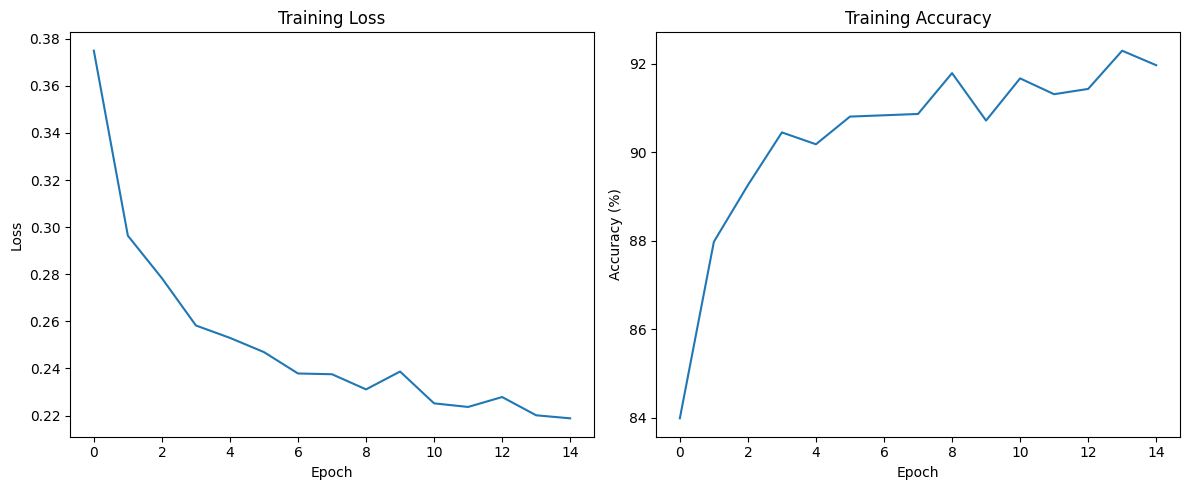


===== Generating ViT Attention Visualizations =====


`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


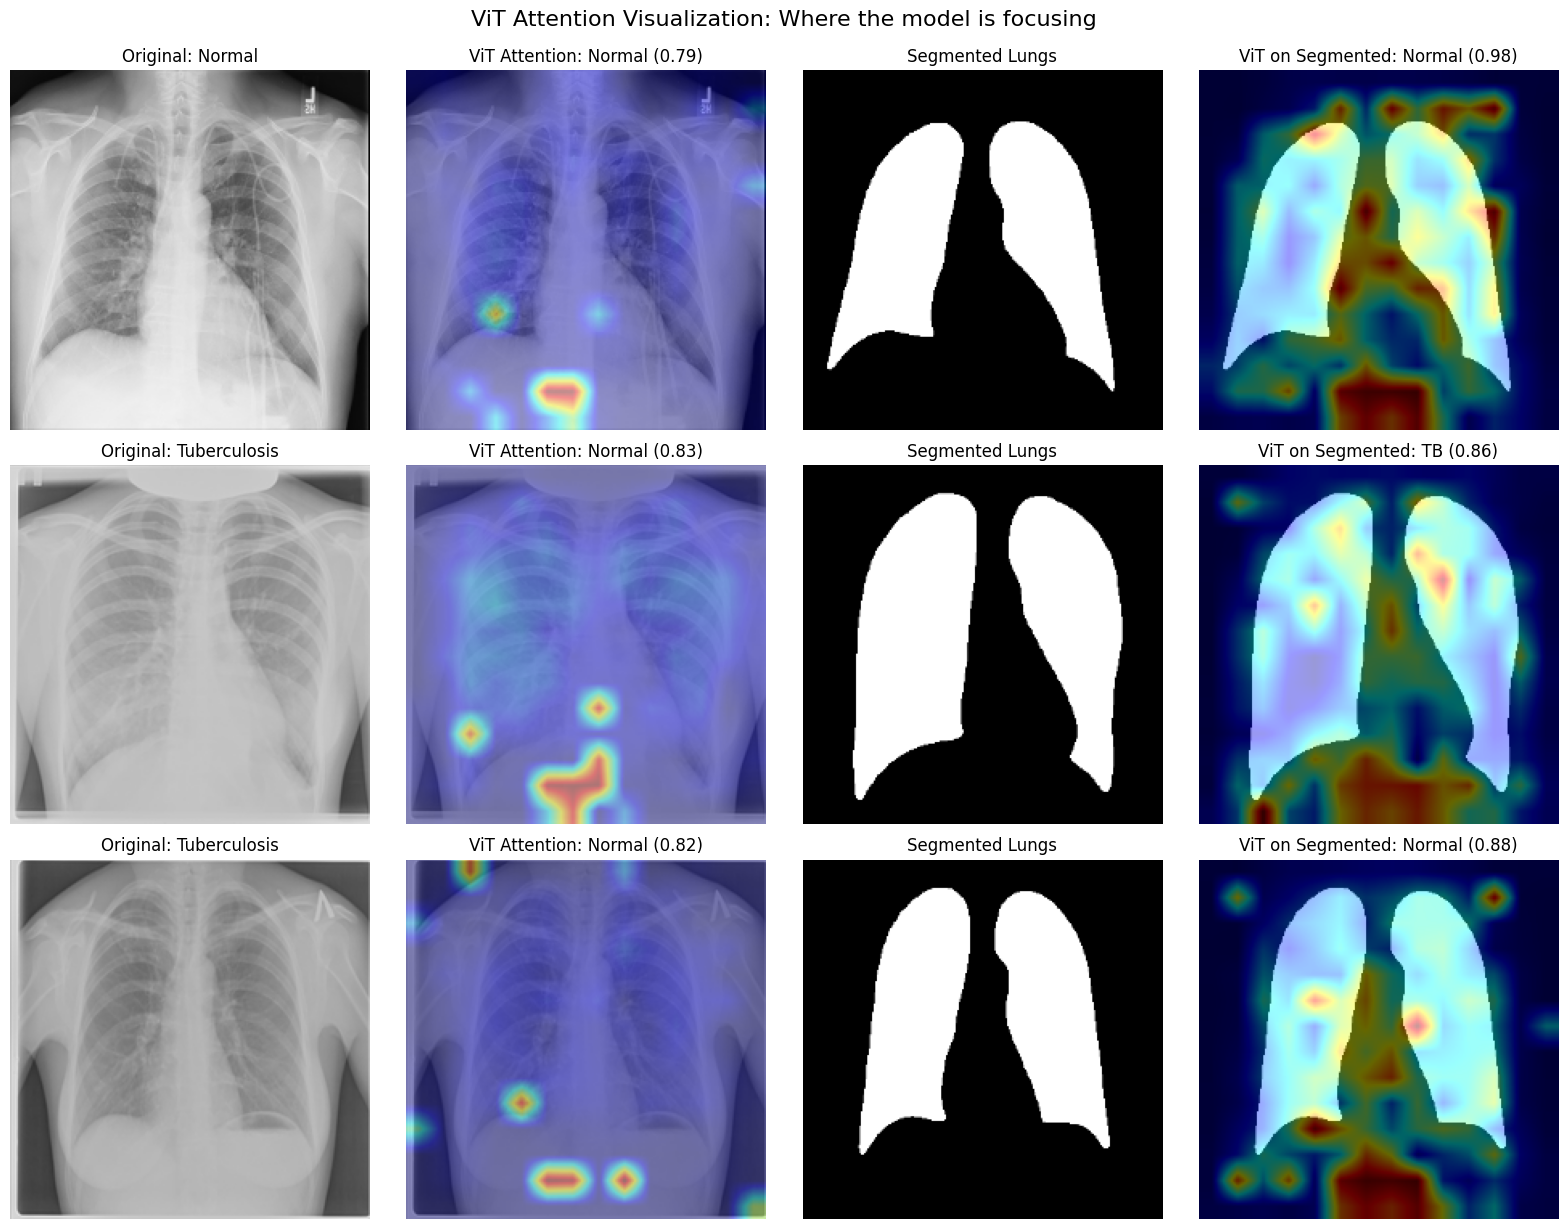


Model saved successfully.

Total runtime: 0h 7m 42s


In [ ]:
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print_gpu_memory()

def load_segmentation_model():
    try:
        model = AutoModel.from_pretrained("ianpan/chest-x-ray-basic", trust_remote_code=True)
        model = model.eval().to(device)
        print("Successfully loaded pretrained segmentation model")
        return model
    except Exception as e:
        print(f"Error loading pretrained model: {e}")
        print("Using fallback segmentation method")
        return None   
def basic_lung_segmentation(image):
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    _, binary = cv2.threshold(enhanced, 90, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    if len(image.shape) == 3:
        mask = np.stack([binary, binary, binary], axis=2) / 255.0
    else:
        mask = binary / 255.0
    segmented = image * mask
    return segmented

def segment_lungs(image, model=None):
    if model is None:
        return basic_lung_segmentation(image)
    orig_h, orig_w = image.shape[:2]
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = image
    try: 
        x = model.preprocess(gray_img)  
        x = torch.from_numpy(x).unsqueeze(0).unsqueeze(0)  
        x = x.float().to(device)
        with torch.no_grad():
            out = model(x)
            torch.cuda.synchronize()  
        mask = out["mask"].squeeze().cpu().numpy()
        mask = mask.argmax(0)
        binary_mask = np.zeros_like(mask)
        binary_mask[mask == 1] = 1 
        binary_mask[mask == 2] = 1    
        if binary_mask.shape[0] != orig_h or binary_mask.shape[1] != orig_w:
            binary_mask = cv2.resize(binary_mask.astype(np.float32), (orig_w, orig_h))
        if len(image.shape) == 3:
            segmented = image * np.expand_dims(binary_mask, axis=2)
        else:
            segmented = image * binary_mask
        if segmented.dtype == np.float32 or segmented.dtype == np.float64:
            
            segmented = np.clip(segmented, 0, 1)
            segmented = (segmented * 255).astype(np.uint8)
        return segmented   
    except Exception as e:
        print(f"Error in segmentation: {e}")
        print(traceback.format_exc())
        return basic_lung_segmentation(image)
    
def preprocess_and_cache_segmented_images(df, model, cache_dir='segmented_cache'):
    os.makedirs(cache_dir, exist_ok=True)
    processed_count = 0
    for idx, row in tqdm(df.iterrows(), total=len(df)): 
        src_path = row['image_path']
        filename = os.path.basename(src_path)
        dest_path = os.path.join(cache_dir, filename) 
        if os.path.exists(dest_path):
            processed_count += 1
            continue
        try:
            img = cv2.imread(src_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            segmented = segment_lungs(img, model)
            segmented = cv2.resize(segmented, (224, 224))
            cv2.imwrite(dest_path, cv2.cvtColor(segmented, cv2.COLOR_RGB2BGR))
            processed_count += 1
            if idx % 100 == 0:
                torch.cuda.empty_cache()
        except Exception as e:
            print(f"Error processing {src_path}: {e}")
    print(f"Processed {processed_count} images. Cached at {cache_dir}/")
    new_df = df.copy()
    new_df['segmented_path'] = new_df['image_path'].apply(
        lambda x: os.path.join(cache_dir, os.path.basename(x))
    )
    return new_df

class OptimizedChestXRayDataset(Dataset):
    def __init__(self, dataframe, transform=None, use_segmented_paths=True):
        self.dataframe = dataframe
        self.transform = transform
        self.use_segmented_paths = use_segmented_paths and 'segmented_path' in dataframe.columns    
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        if self.use_segmented_paths:
            img_path = self.dataframe.iloc[idx]['segmented_path']
        else:
            img_path = self.dataframe.iloc[idx]['image_path']     
        label = 1 if self.dataframe.iloc[idx]['label'] == 'Tuberculosis' else 0 
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
        if img.shape[:2] != (224, 224):
            img = cv2.resize(img, (224, 224)) 
        if self.transform:   
            if img.dtype == np.float32 or img.dtype == np.float64:
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)    
            img = self.transform(img) 
        return img, label
    
def get_vit_transforms(is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
        ])

def create_optimized_dataloaders(train_df, test_df, batch_size=8):
    train_transform = get_vit_transforms(is_training=True)
    test_transform = get_vit_transforms(is_training=False)
    
    train_dataset = OptimizedChestXRayDataset(
        train_df, 
        transform=train_transform,
        use_segmented_paths=True
    )
    
    test_dataset = OptimizedChestXRayDataset(
        test_df, 
        transform=test_transform,
        use_segmented_paths=True
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,  
        pin_memory=True  
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    return train_loader, test_loader

# used the best  hugging face vit model pretrained on chest xray images 
def setup_vit_model(num_classes=2, model_name="google/vit-base-patch16-224"):
    print(f"Loading pretrained Vision Transformer: {model_name}...") 
    model = ViTForImageClassification.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    )
    for param in model.vit.parameters():
        param.requires_grad = False
    for param in model.classifier.parameters():
        param.requires_grad = True 
    print(f"Vision Transformer loaded successfully with {num_classes} output classes")
    return model

def train_vit_model(model, train_loader, criterion, optimizer, device, num_epochs=15, use_early_stopping=False, patience=3):
    model.to(device)
    history = {'train_loss': [], 'train_acc': []} 
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        start_time = time.time()
        
        try:
            for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                if batch_count == 0:    
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs.logits, labels)  
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.logits, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                torch.cuda.empty_cache()
                batch_count += 1
                if batch_count % 10 == 0:
                    batch_acc = 100 * correct / total
                    print(f"Batch {batch_count}, Loss: {loss.item():.4f}, Running Acc: {batch_acc:.2f}%")
            
            
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_acc = 100 * correct / total
            epoch_time = time.time() - start_time
            
            
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(epoch_acc)
            
            print(f'Epoch {epoch+1}/{num_epochs}, '
                  f'Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, '
                  f'Time: {epoch_time:.1f}s')
            
            
            torch.save(model.state_dict(), f'vit_tb_epoch_{epoch+1}.pth')
            
            
            if use_early_stopping:
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), 'best_vit_tb.pth')
                    print("Saved best model checkpoint")
                else:
                    patience_counter += 1
                    print(f"No improvement in loss. Patience: {patience_counter}/{patience}")
                    
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch+1}")
                        break
            else:
                
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), 'best_vit_tb.pth')
                    print("Saved best model checkpoint")
                
        except Exception as e:
            print(f"Error during training: {e}")
            print(traceback.format_exc())
            
            torch.save(model.state_dict(), 'emergency_vit_tb.pth')
            print("Saved emergency checkpoint due to error")
            break
    try:
        model.load_state_dict(torch.load('best_vit_tb.pth'))
        print("Loaded best model for evaluation")
    except:
        print("Could not load best model, using current model")
    
    return model, history

def evaluate_vit_model(model, test_loader, device):
    """Evaluate the ViT model with memory optimization"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.logits, 1)  
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            
            torch.cuda.empty_cache()    
    conf_matrix = confusion_matrix(all_labels, all_preds)
    if conf_matrix.size == 4:  # If it's a 2x2 matrix
        tn, fp, fn, tp = conf_matrix.ravel()
    else:
       
        print("Warning: Could not unpack confusion matrix")
        tn, fp, fn, tp = 0, 0, 0, 0
    
    accuracy = accuracy_score(all_labels, all_preds) * 100
    try:
        precision = precision_score(all_labels, all_preds) * 100
    except:
        precision = 0    
    try:
        recall = recall_score(all_labels, all_preds) * 100
    except:
        recall = 0
        
    try:
        f1 = f1_score(all_labels, all_preds) * 100
    except:
        f1 = 0
        
    try:
        specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
    except:
        specificity = 0
    
    try:
        auc = roc_auc_score(all_labels, all_preds) * 100
    except:
        auc = 0
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'auc': auc,
        'confusion_matrix': conf_matrix
    }
    return results


class ViTAttentionVisualizer:
    """Visualize attention maps from Vision Transformer models"""
    def __init__(self, model, device=None):
        self.model = model
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.model.eval()
    
    def visualize(self, image_path, use_segmented=False, segmentation_model=None):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if use_segmented and segmentation_model is not None:
            img = segment_lungs(img, segmentation_model)
        img_resized = cv2.resize(img, (224, 224))
        if img_resized.dtype != np.uint8:
            img_resized = np.clip(img_resized, 0, 1) * 255
            img_resized = img_resized.astype(np.uint8)
        
        
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        
        img_tensor = transform(img_resized).unsqueeze(0).to(self.device)
        with torch.no_grad():
            outputs = self.model(img_tensor, output_attentions=True)
            logits = outputs.logits
            pred_class = torch.argmax(logits, dim=-1).item()
            pred_score = torch.softmax(logits, dim=-1)[0, pred_class].item()
            attn = outputs.attentions[-1]  
            attn = attn.mean(dim=1)[0]  
            cls_attn = attn[0, 1:]     
            patch_size = 16  
            grid_size = 224 // patch_size  
            attn_map = cls_attn.reshape(grid_size, grid_size).cpu().numpy() 
            attn_map = cv2.resize(attn_map, (img_resized.shape[1], img_resized.shape[0]))
            attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
            heatmap = cv2.applyColorMap(np.uint8(255 * attn_map), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            attn_img = (heatmap * 0.4 + img_resized * 0.6).astype(np.uint8)
            return img_resized, attn_img, pred_class, pred_score


def visualize_attention(model, test_df, segmentation_model=None, device=None, num_samples=3):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    normal_df = test_df[test_df['label'] == 'Normal'].sample(num_samples//2)
    tb_df = test_df[test_df['label'] == 'Tuberculosis'].sample(num_samples - num_samples//2)
    sample_df = pd.concat([normal_df, tb_df]) 
    visualizer = ViTAttentionVisualizer(model, device=device)
    fig, axes = plt.subplots(len(sample_df), 4, figsize=(16, 4*len(sample_df)))
    
    
    if len(sample_df) == 1:
        axes = np.expand_dims(axes, axis=0)
    
    
    for i, (_, row) in enumerate(sample_df.iterrows()):
        try:
            img_path = row['image_path']
            label = row['label']
            if segmentation_model is not None and next(segmentation_model.parameters()).device != device:
                segmentation_model = segmentation_model.to(device)
            
            
            orig_img, orig_attn, orig_pred, orig_score = visualizer.visualize(
                img_path, 
                use_segmented=False
            )
            seg_img, seg_attn, seg_pred, seg_score = visualizer.visualize(
                img_path, 
                use_segmented=True,
                segmentation_model=segmentation_model
            )
            # Plot results
            axes[i, 0].imshow(orig_img)
            axes[i, 0].set_title(f"Original: {label}")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(orig_attn)
            axes[i, 1].set_title(f"ViT Attention: {'TB' if orig_pred == 1 else 'Normal'} ({orig_score:.2f})")
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(seg_img)
            axes[i, 2].set_title(f"Segmented Lungs")
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(seg_attn)
            axes[i, 3].set_title(f"ViT on Segmented: {'TB' if seg_pred == 1 else 'Normal'} ({seg_score:.2f})")
            axes[i, 3].axis('off')
            
        except Exception as e:
            print(f"Error visualizing image {img_path}: {e}")
            traceback.print_exc()
    
    plt.tight_layout()
    plt.suptitle("ViT Attention Visualization: Where the model is focusing", fontsize=16, y=1.02)
    plt.savefig('vit_attention_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Clean up
    if segmentation_model is not None:
        segmentation_model = segmentation_model.cpu()
    torch.cuda.empty_cache()
    
    return fig


def main():
    
    total_start_time = time.time()
    
    
    base_path = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
    normal_path = os.path.join(base_path, 'Normal')
    tb_path = os.path.join(base_path, 'Tuberculosis')
    
    def create_dataset_df(normal_dir, tb_dir):
        normal_files = glob(os.path.join(normal_dir, '*.png'))
        tb_files = glob(os.path.join(tb_dir, '*.png'))
        
        files = normal_files + tb_files
        labels = ['Normal'] * len(normal_files) + ['Tuberculosis'] * len(tb_files)
        
        return pd.DataFrame({
            'image_path': files,
            'label': labels
        })
    
    
    print("Creating dataset dataframe...")
    df = create_dataset_df(normal_path, tb_path)
    
    print("\nDataset Information:")
    print(f"Total number of images: {len(df)}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    
    
    train_df, test_df = train_test_split(
        df, 
        test_size=0.2, 
        random_state=42,
        stratify=df['label']
    )
    
    print("\nTrain/Test Split:")
    print(f"Training set: {len(train_df)} images")
    print(f"Testing set: {len(test_df)} images")
    
    try:
        
        segmentation_model = load_segmentation_model()
        
        
        cache_dir = '/kaggle/working/segmented_cache'
        train_df = preprocess_and_cache_segmented_images(train_df, segmentation_model, cache_dir)
        test_df = preprocess_and_cache_segmented_images(test_df, segmentation_model, cache_dir)
        
        
        segmentation_model = segmentation_model.cpu()
        torch.cuda.empty_cache()
        print_gpu_memory()
        
        
        print("\nCreating data loaders with pre-segmented lung images...")
        train_loader, test_loader = create_optimized_dataloaders(
            train_df, test_df, batch_size=8
        )
        
        
        model = setup_vit_model(num_classes=2, model_name="google/vit-base-patch16-224")
        model = model.to(device)
        
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=1e-4,
            weight_decay=0.01
        )
        
        
        print("\n===== Training Vision Transformer with Segmented Lungs =====")
        print_gpu_memory()
        model, history = train_vit_model(
            model, train_loader, criterion, optimizer, device, 
            num_epochs=15,
            use_early_stopping=False
        )
        
        
        print("\n===== Evaluating ViT Model =====")
        results = evaluate_vit_model(model, test_loader, device)
        
        
        print("\n===== Results Summary =====")
        print(f"Accuracy: {results['accuracy']:.2f}%")
        print(f"Precision: {results['precision']:.2f}%")
        print(f"Sensitivity/Recall: {results['recall']:.2f}%")
        print(f"F1 Score: {results['f1_score']:.2f}%")
        print(f"Specificity: {results['specificity']:.2f}%")
        print(f"AUC: {results['auc']:.2f}%")
        print("\nConfusion Matrix:")
        print(results['confusion_matrix'])
        
        
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'])
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        
        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'])
        plt.title('Training Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        
        plt.tight_layout()
        plt.savefig('vit_training_history.png', dpi=300)
        plt.show()
        
        
        print("\n===== Generating ViT Attention Visualizations =====")
        try:
            
            visualize_attention(
                model=model,
                test_df=test_df,
                segmentation_model=segmentation_model,
                device=device,
                num_samples=3
            )
            
        except Exception as e:
            print(f"Error in visualization: {e}")
            traceback.print_exc()
        
        
        torch.save(model.state_dict(), 'vit_tb_segmented.pth')
        print("\nModel saved successfully.")
        
    except Exception as e:
        print(f"Error in main execution: {e}")
        print(traceback.format_exc())
    
    finally:
        
        total_time = time.time() - total_start_time
        hours, remainder = divmod(total_time, 3600)
        minutes, seconds = divmod(remainder, 60)
        print(f"\nTotal runtime: {int(hours)}h {int(minutes)}m {int(seconds)}s")


if __name__ == "__main__":
    try:
        import torch.multiprocessing as mp
        mp.set_start_method('spawn', force=True)
    except RuntimeError:
        
        pass
    
    main()
